# Position Reconstruction for XeBRA - Comparison

**Status:** August 2019

Position reconstruction for XeBRA using Centroids, LRFs and NNs as well as comparison performance simulations vs measurements.

In [1]:
## Imports:

import sys
import glob

import numpy as np
from numpy import exp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import pandas as pd
import math

from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence

## General Definitions and Parameters

In [2]:
## General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties
R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.
PMT_ID = np.array([1,2,3,4,5,6,7])
PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates
PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})

## Imports and Data Processing

### Measurements

In [4]:
!ls /home/ab602/Thesis/Xebra_Measurements_Analysis/Position_Reconstruction_*/output/run_00158*.pkl
!ls /home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_*/output/run_00158*.pkl

ls: cannot access '/home/ab602/Thesis/Xebra_Measurements_Analysis/Position_Reconstruction_*/output/run_00158*.pkl': No such file or directory
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_Centroid/output/run_00158_Kr83m_S2_AFT_Reconstruction_Centroid.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_LRF/output/run_00158_Kr83m_S2_AFT_Iterative_Reconstruciton.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_NN/output/run_00158_Kr83m_S2_AFT_Reconstruction_NN.pkl


In [5]:
#### Import processed measurements data

## Define run to be used
## Good Kr83m runs concerning S2 AFT: 00157, 00158, (00159,) 00163; best: 00158
run = "00158"

## Import pandas dataframe from pkl
try:
    df_Centroid = pd.read_pickle("/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_Centroid/output/run_"+run+"_Kr83m_S2_AFT_Reconstruction_Centroid.pkl")
    df_LRF      = pd.read_pickle("/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_LRF/output/run_"+run+"_Kr83m_S2_AFT_Iterative_Reconstruciton.pkl")
    df_NN       = pd.read_pickle("/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/Position_Reconstruction_NN/output/run_"+run+"_Kr83m_S2_AFT_Reconstruction_NN.pkl")
    file_exist = True
except:
    pass
try:
    df_Centroid = pd.read_pickle("/home/ab602/Thesis/Xebra_Measurements_Analysis/Position_Reconstruction_Centroid/output/run_"+run+"_Kr83m_S2_AFT_Reconstruction_Centroid.pkl")
    df_LRF      = pd.read_pickle("/home/ab602/Thesis/Xebra_Measurements_Analysis/Position_Reconstruction_LRF/output/run_"+run+"_Kr83m_S2_AFT_Iterative_Reconstruciton.pkl")
    df_NN       = pd.read_pickle("/home/ab602/Thesis/Xebra_Measurements_Analysis/Position_Reconstruction_NN/output/run_"+run+"_Kr83m_S2_AFT_Reconstruction_NN.pkl")
except:
    if file_exist:
        pass
    else:
        print('Selected file cannot be found.')
    
filenameprefix = "run_"+run+"_Kr83m_S2_AFT"
print(filenameprefix)

run_00158_Kr83m_S2_AFT


In [6]:
x_pos_Centroid = np.array(df_Centroid['x_pos'])
y_pos_Centroid = np.array(df_Centroid['y_pos'])
print(x_pos_Centroid.shape)

df_Centroid.head()

(18827,)


x_pos      y_pos
0  10.786233  10.913062
1  13.446973  12.508565
2 -13.775311  -3.993569
3   1.341471  -4.348050
4 -13.210608  -1.859828

In [7]:
x_pos_LRF_iteration0 = df_LRF['x_pos']['0']
x_pos_LRF_iteration1 = df_LRF['x_pos']['1']
x_pos_LRF_iteration2 = df_LRF['x_pos']['2']
x_pos_LRF_iteration3 = df_LRF['x_pos']['3']
x_pos_LRF_iteration4 = df_LRF['x_pos']['4']
x_pos_LRF_iteration5 = df_LRF['x_pos']['5']
y_pos_LRF_iteration0 = df_LRF['y_pos']['0']
y_pos_LRF_iteration1 = df_LRF['y_pos']['1']
y_pos_LRF_iteration2 = df_LRF['y_pos']['2']
y_pos_LRF_iteration3 = df_LRF['y_pos']['3']
y_pos_LRF_iteration4 = df_LRF['y_pos']['4']
y_pos_LRF_iteration5 = df_LRF['y_pos']['5']
print(x_pos_LRF_iteration5.shape)

df_LRF.head()

(18827,)


rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   
2         20               15                 32   
3         20               15                 32   
4         20               15                 32   

                                       fit_parameter  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...   
1  [[0.6016925420036606, 36.061586747735234, -3.0...   
2  [[0.6213197917541504, 36.69817529257881, -3.23...   
3  [[0.6262110565403661, 35.62948794775529, -2.63...   
4  [[0.6296958552450105, 33.84151139852634, -1.86...   

                                               x_pos  \
0  [15.067650109682376, 23.21576116642172, -19.06...   
1  [14.877927176548072, 21.528979814798372, -18.9...   
2  [14.475328762864487, 21.130269711541644, -18.7...   
3  [14.200224175195073, 20.65097662243528, -18.50...   
4  [13.922488346083757, 19.703058890654994, -18.2...   

                                               y_pos  \
0  [15.013278202566628, 18.183364395947017, -6.74...   
1  [14.669509095254746, 17.167255646907062, -6.68...   
2  [14.392954018545405, 16.919138998592572, -6.53...   
3  [14.133531136213001, 16.592993009023054, -6.40...   
4  [13.876226052984217, 16.0275835695048, -6.2783...   

                                        r_pos_binned  \
0  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
1  [[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5...   
2  [[3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11....   
3  [[4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12...   
4  [[4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12...   

                                           HF_binned  \
0  [[0.6148002732025396, 0.6026768041361014, 0.59...   
1  [[0.6285648450994098, 0.6083875843289961, 0.59...   
2  [[0.6201795732498544, 0.6042094375186153, 0.58...   
3  [[0.6113781291003003, 0.5969387524238264, 0.57...   
4  [[0.6151910109773345, 0.6013939293035435, 0.58...   

                                   fit_parameter_end  
0  [[0.6016925420036606, 36.061586747735234, -3.0...  
1  [[0.6213197917541504, 36.69817529257881, -3.23...  
2  [[0.6262110565403661, 35.62948794775529, -2.63...  
3  [[0.6296958552450105, 33.84151139852634, -1.86...  
4  [[0.6342629093210318, 34.36383729277455, -2.05...

In [8]:
x_pos_NN = np.array(df_NN['x_pos'])
y_pos_NN = np.array(df_NN['y_pos'])
print(x_pos_NN.shape)

df_NN.head()

(18827,)


x_pos      y_pos
0  15.291557  15.212932
1  24.357395  18.508663
2 -19.461060  -6.906969
3   2.264139  -7.366965
4 -18.602991  -3.554627

### Simulations

In [9]:
df_NN_sim = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_NN/MCfakemeasurement_optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Reconstruction_NN_full.pkl")
x_pos_NN_sim = np.array(df_NN_sim['x_pos'])
y_pos_NN_sim = np.array(df_NN_sim['y_pos'])
print(x_pos_NN_sim.shape)

df_NN_sim.head()

(1000000,)


x_pos      y_pos
0  18.397106  17.579727
1  31.665052  -2.186015
2 -16.702953  22.105122
3 -25.734169  16.920139
4  18.514349 -11.042530

In [10]:
df_Centroid_sim = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_Centroids/MCfakemeasurement_optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Reconstruction_Centroid_full.pkl")
x_pos_Centroid_sim = np.array(df_Centroid_sim['x_pos'])
y_pos_Centroid_sim = np.array(df_Centroid_sim['y_pos'])
print(x_pos_Centroid_sim.shape)

df_Centroid_sim.head()

(1000000,)


x_pos      y_pos
0  11.069510  12.230648
1  18.867099  -0.521880
2  -9.701342  15.409396
3 -13.316129   9.806452
4  12.965309  -7.052790

In [11]:
filename_LRF = "MCfakemeasurement_optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_Iterative_Reconstruciton"
df_LRF_sim = pd.read_pickle("/media/alex/TOSHIBA EXT/Simulation_Outputs/Position_Reconstruction_LRF/"+filename_LRF+".pkl")
x_pos_LRF_iteration0_sim = np.array(df_LRF_sim['x_pos']['0'])
y_pos_LRF_iteration0_sim = np.array(df_LRF_sim['y_pos']['0'])
print(x_pos_LRF_iteration0_sim.shape)
x_pos_LRF_iteration1_sim = np.array(df_LRF_sim['x_pos']['1'])
y_pos_LRF_iteration1_sim = np.array(df_LRF_sim['y_pos']['1'])
x_pos_LRF_iteration2_sim = np.array(df_LRF_sim['x_pos']['2'])
y_pos_LRF_iteration2_sim = np.array(df_LRF_sim['y_pos']['2'])
x_pos_LRF_iteration3_sim = np.array(df_LRF_sim['x_pos']['3'])
y_pos_LRF_iteration3_sim = np.array(df_LRF_sim['y_pos']['3'])
x_pos_LRF_iteration4_sim = np.array(df_LRF_sim['x_pos']['4'])
y_pos_LRF_iteration4_sim = np.array(df_LRF_sim['y_pos']['4'])
x_pos_LRF_iteration5_sim = np.array(df_LRF_sim['x_pos']['5'])
y_pos_LRF_iteration5_sim = np.array(df_LRF_sim['y_pos']['5'])

df_LRF_sim.head()

(10000,)


rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   
2         20               15                 32   
3         20               15                 32   
4         20               15                 32   

                                       fit_parameter  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...   
1  [[0.6017073963620089, 38.7302590431945, -4.027...   
2  [[0.6183459043835552, 43.129166330359276, -6.3...   
3  [[0.627798381471581, 48.34741093020025, -10.55...   
4  [[0.6345135617096274, 51.75905632867351, -13.8...   

                                               x_pos  \
0  [17.618000307344, 30.552376361769564, -15.4647...   
1  [17.3013291457405, 30.455956351607558, -15.082...   
2  [16.93612236692497, 30.154250957850888, -14.76...   
3  [16.615216386266592, 29.431376473767866, -14.5...   
4  [16.366924245315598, 28.182165820505343, -14.3...   

                                               y_pos  \
0  [16.91237920021913, -2.033241012730516, 20.361...   
1  [16.582137440360153, -2.0807944665584777, 19.6...   
2  [16.329175822028212, -1.996003322743022, 19.31...   
3  [16.096415515672177, -1.7864947948697543, 19.1...   
4  [15.900474259618305, -1.5392371168293755, 19.0...   

                                        r_pos_binned  \
0  [[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,...   
1  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
2  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
3  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
4  [[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5...   

                                           HF_binned  \
0  [[0.6149924051067908, 0.6068165928205498, 0.60...   
1  [[0.6306566897637992, 0.6148077704403064, 0.59...   
2  [[0.6381987577639752, 0.6234712766152656, 0.61...   
3  [[0.6381987577639752, 0.6338842975206612, 0.61...   
4  [[0.6381987577639752, 0.6224500911273406, 0.60...   

                                   fit_parameter_end  
0  [[0.6017073963620089, 38.7302590431945, -4.027...  
1  [[0.6183459043835552, 43.129166330359276, -6.3...  
2  [[0.627798381471581, 48.34741093020025, -10.55...  
3  [[0.6345135617096274, 51.75905632867351, -13.8...  
4  [[0.6349043341807443, 51.02000844229367, -13.2...

## Evaluation

### Comparison Methods

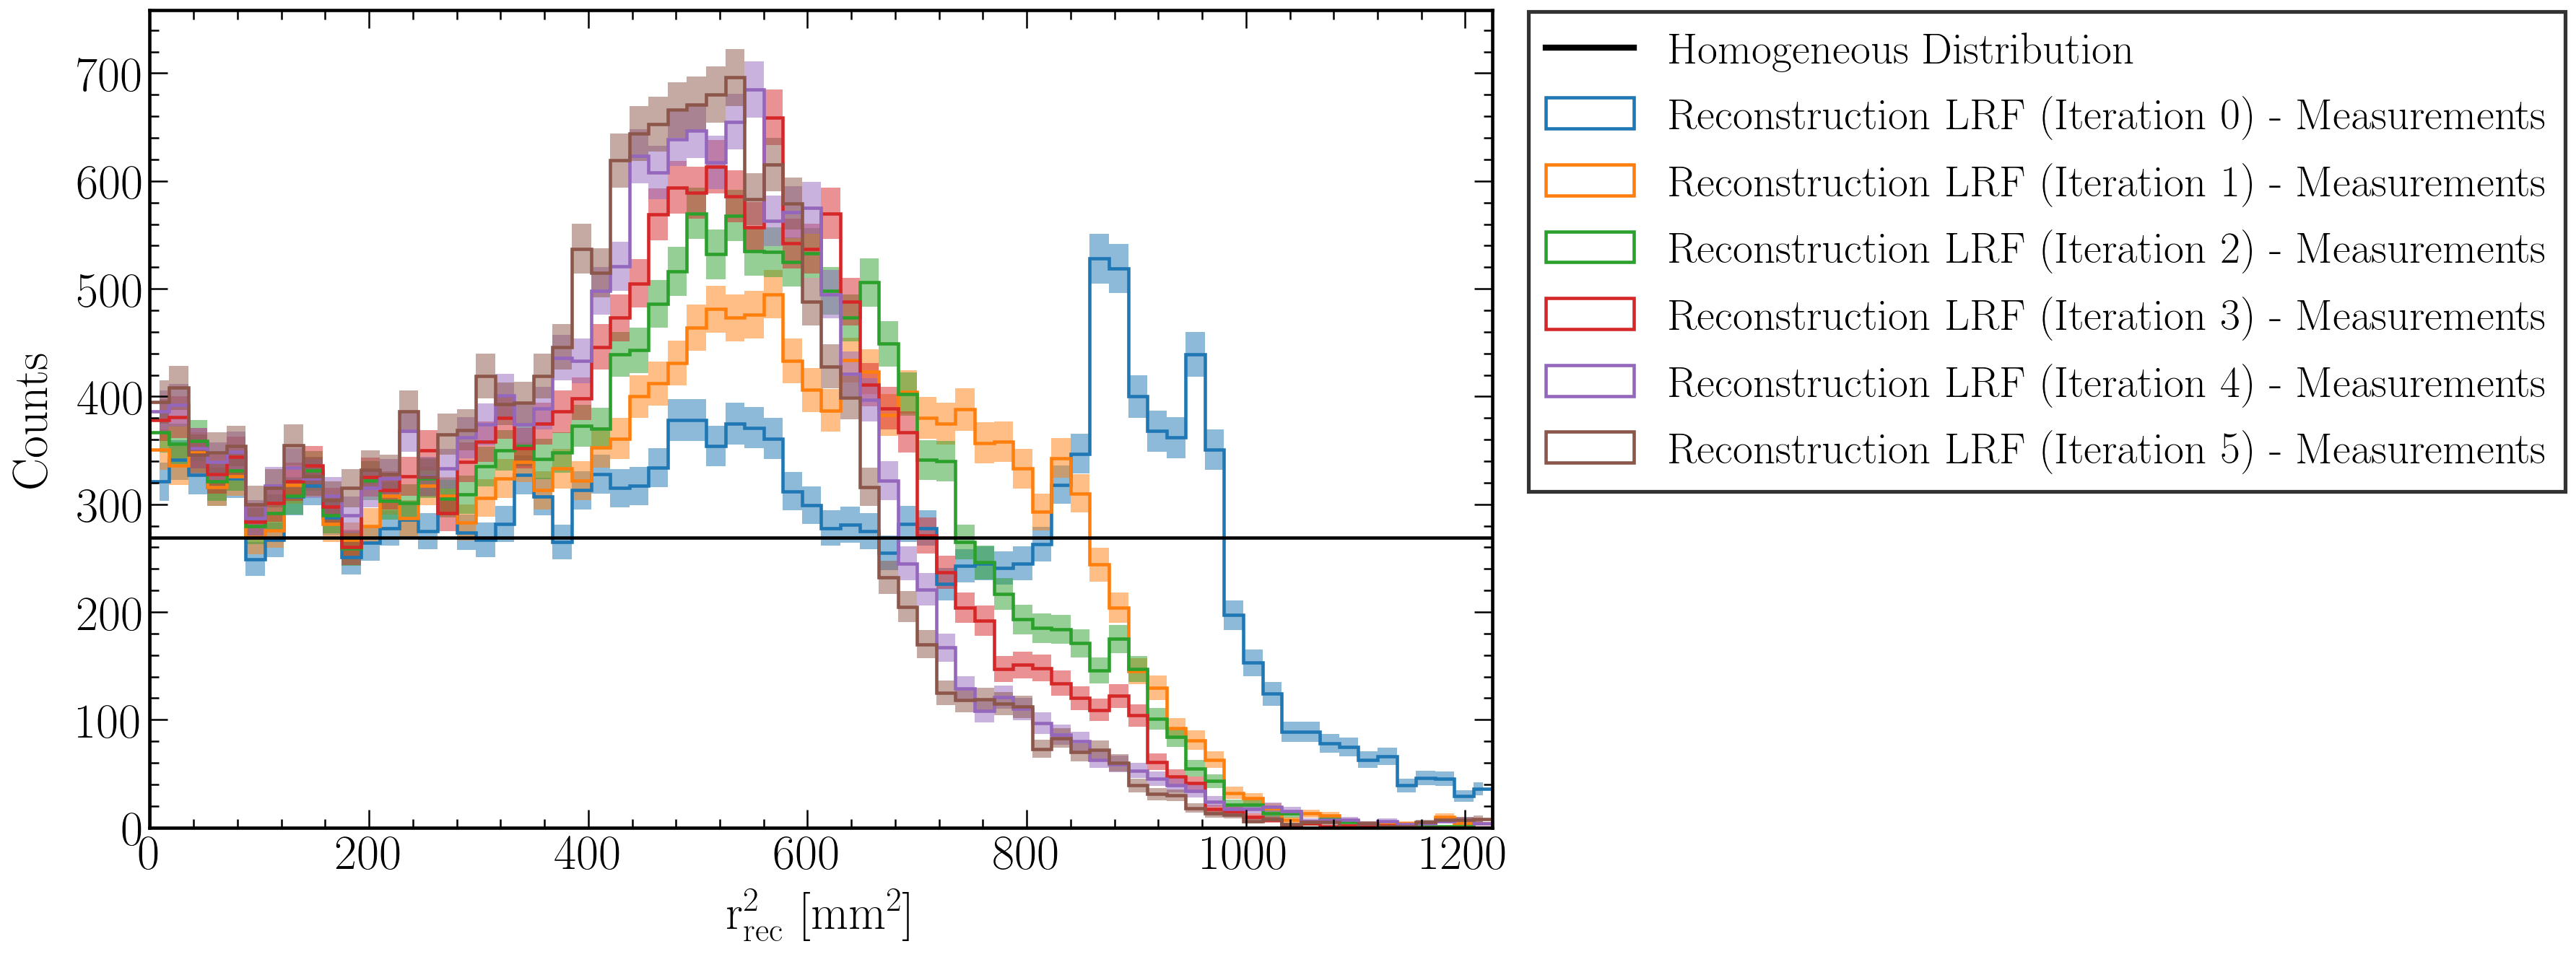

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration0, y_pos_LRF_iteration0)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction LRF (Iteration 0) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration1, y_pos_LRF_iteration1)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C1', label = 'Reconstruction LRF (Iteration 1) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C1', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration2, y_pos_LRF_iteration2)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C2', label = 'Reconstruction LRF (Iteration 2) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C2', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration3, y_pos_LRF_iteration3)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C3', label = 'Reconstruction LRF (Iteration 3) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C3', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration4, y_pos_LRF_iteration4)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C4', label = 'Reconstruction LRF (Iteration 4) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C4', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration5, y_pos_LRF_iteration5)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C5', label = 'Reconstruction LRF (Iteration 5) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C5', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_LRF_comparison_r2spectrum.png", bbox_inches = "tight")
plt.show()

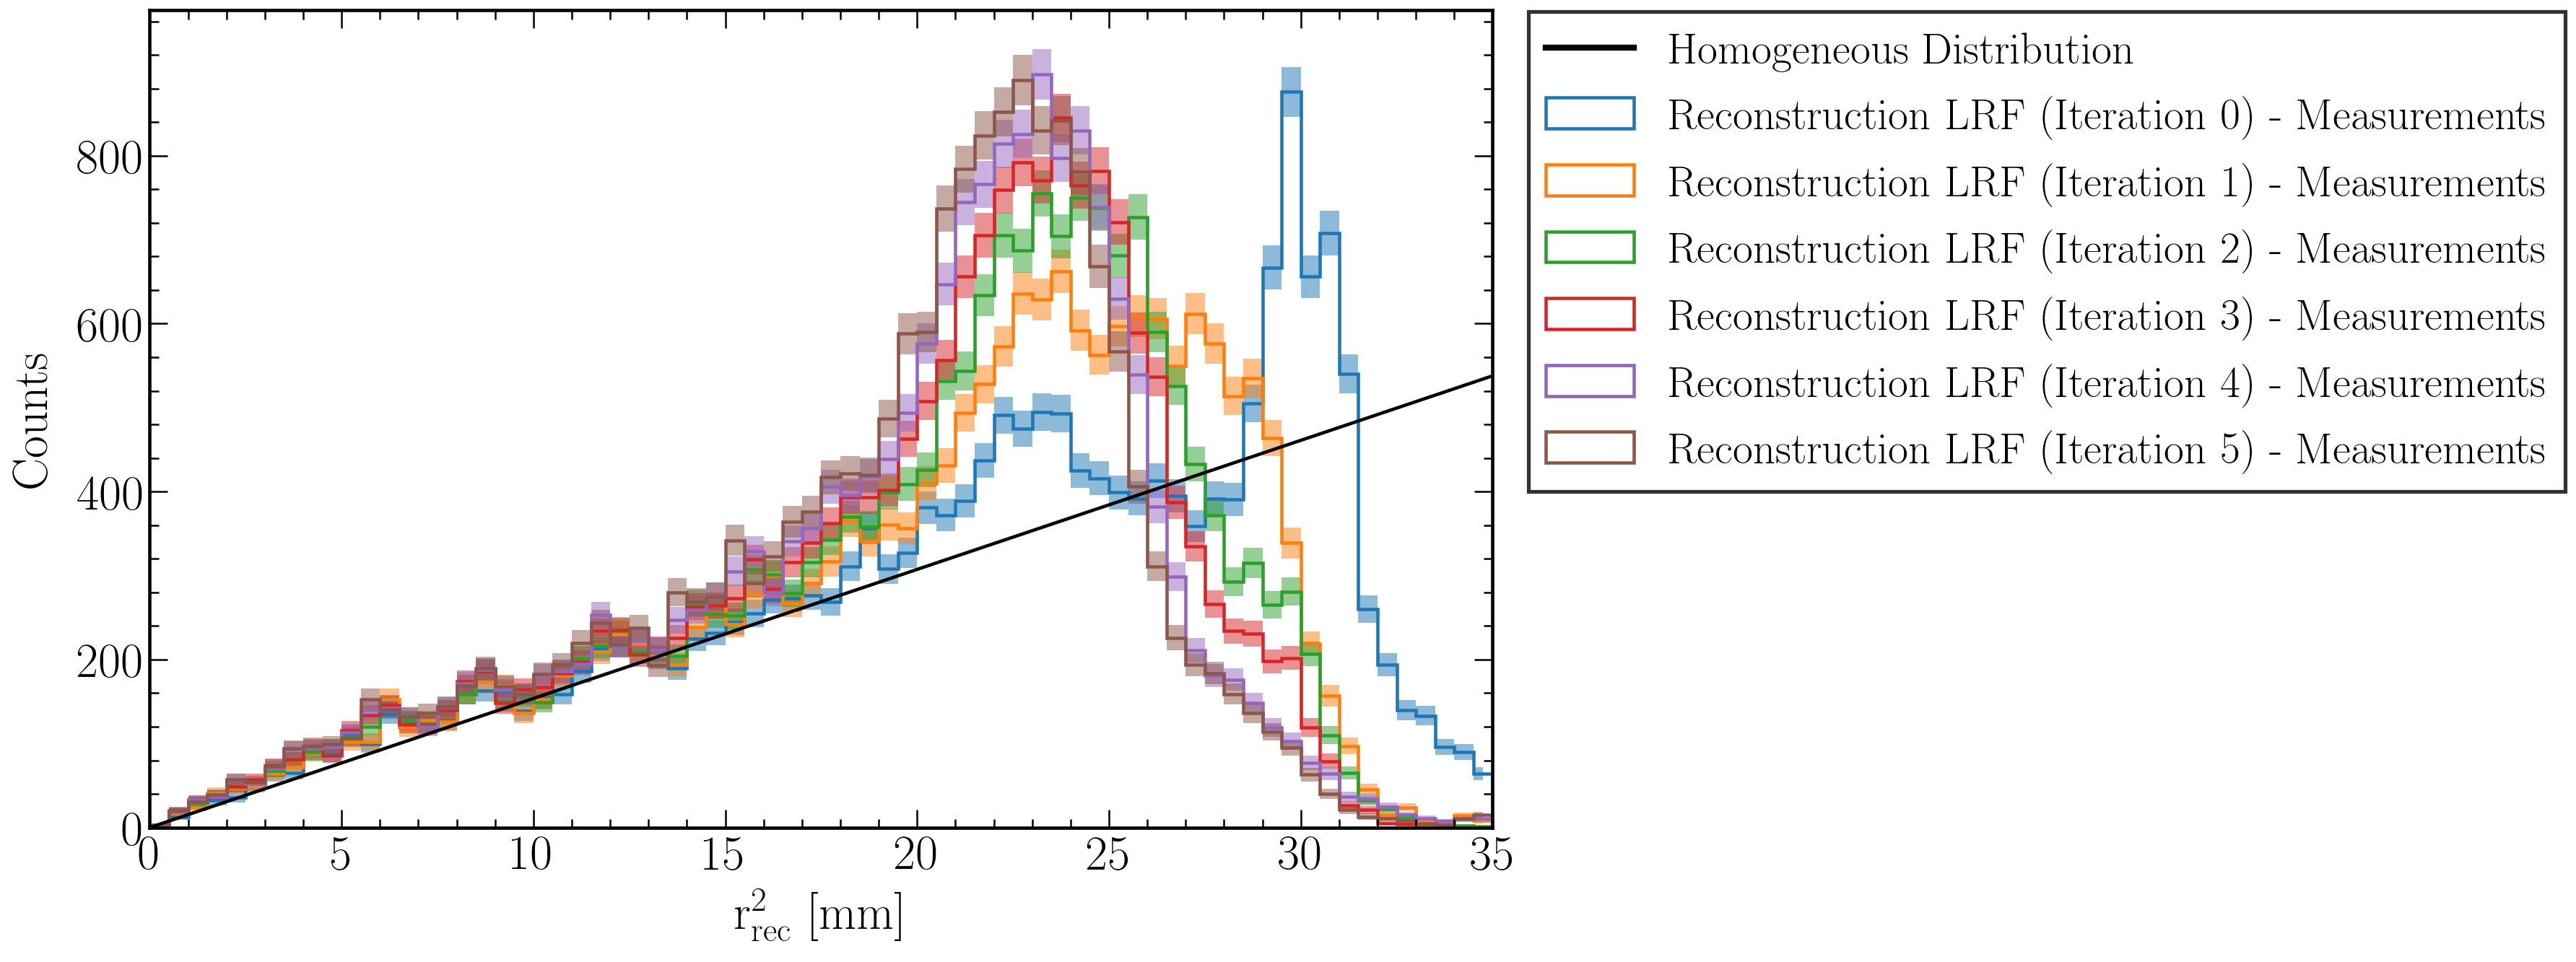

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration0, y_pos_LRF_iteration0), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction LRF (Iteration 0) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration1, y_pos_LRF_iteration1), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C1', label = 'Reconstruction LRF (Iteration 1) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C1', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration2, y_pos_LRF_iteration2), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C2', label = 'Reconstruction LRF (Iteration 2) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C2', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration3, y_pos_LRF_iteration3), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C3', label = 'Reconstruction LRF (Iteration 3) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C3', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration4, y_pos_LRF_iteration4), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C4', label = 'Reconstruction LRF (Iteration 4) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C4', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration5, y_pos_LRF_iteration5), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C5', label = 'Reconstruction LRF (Iteration 5) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C5', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_LRF_comparison_rspectrum.png", bbox_inches = "tight")
plt.show()

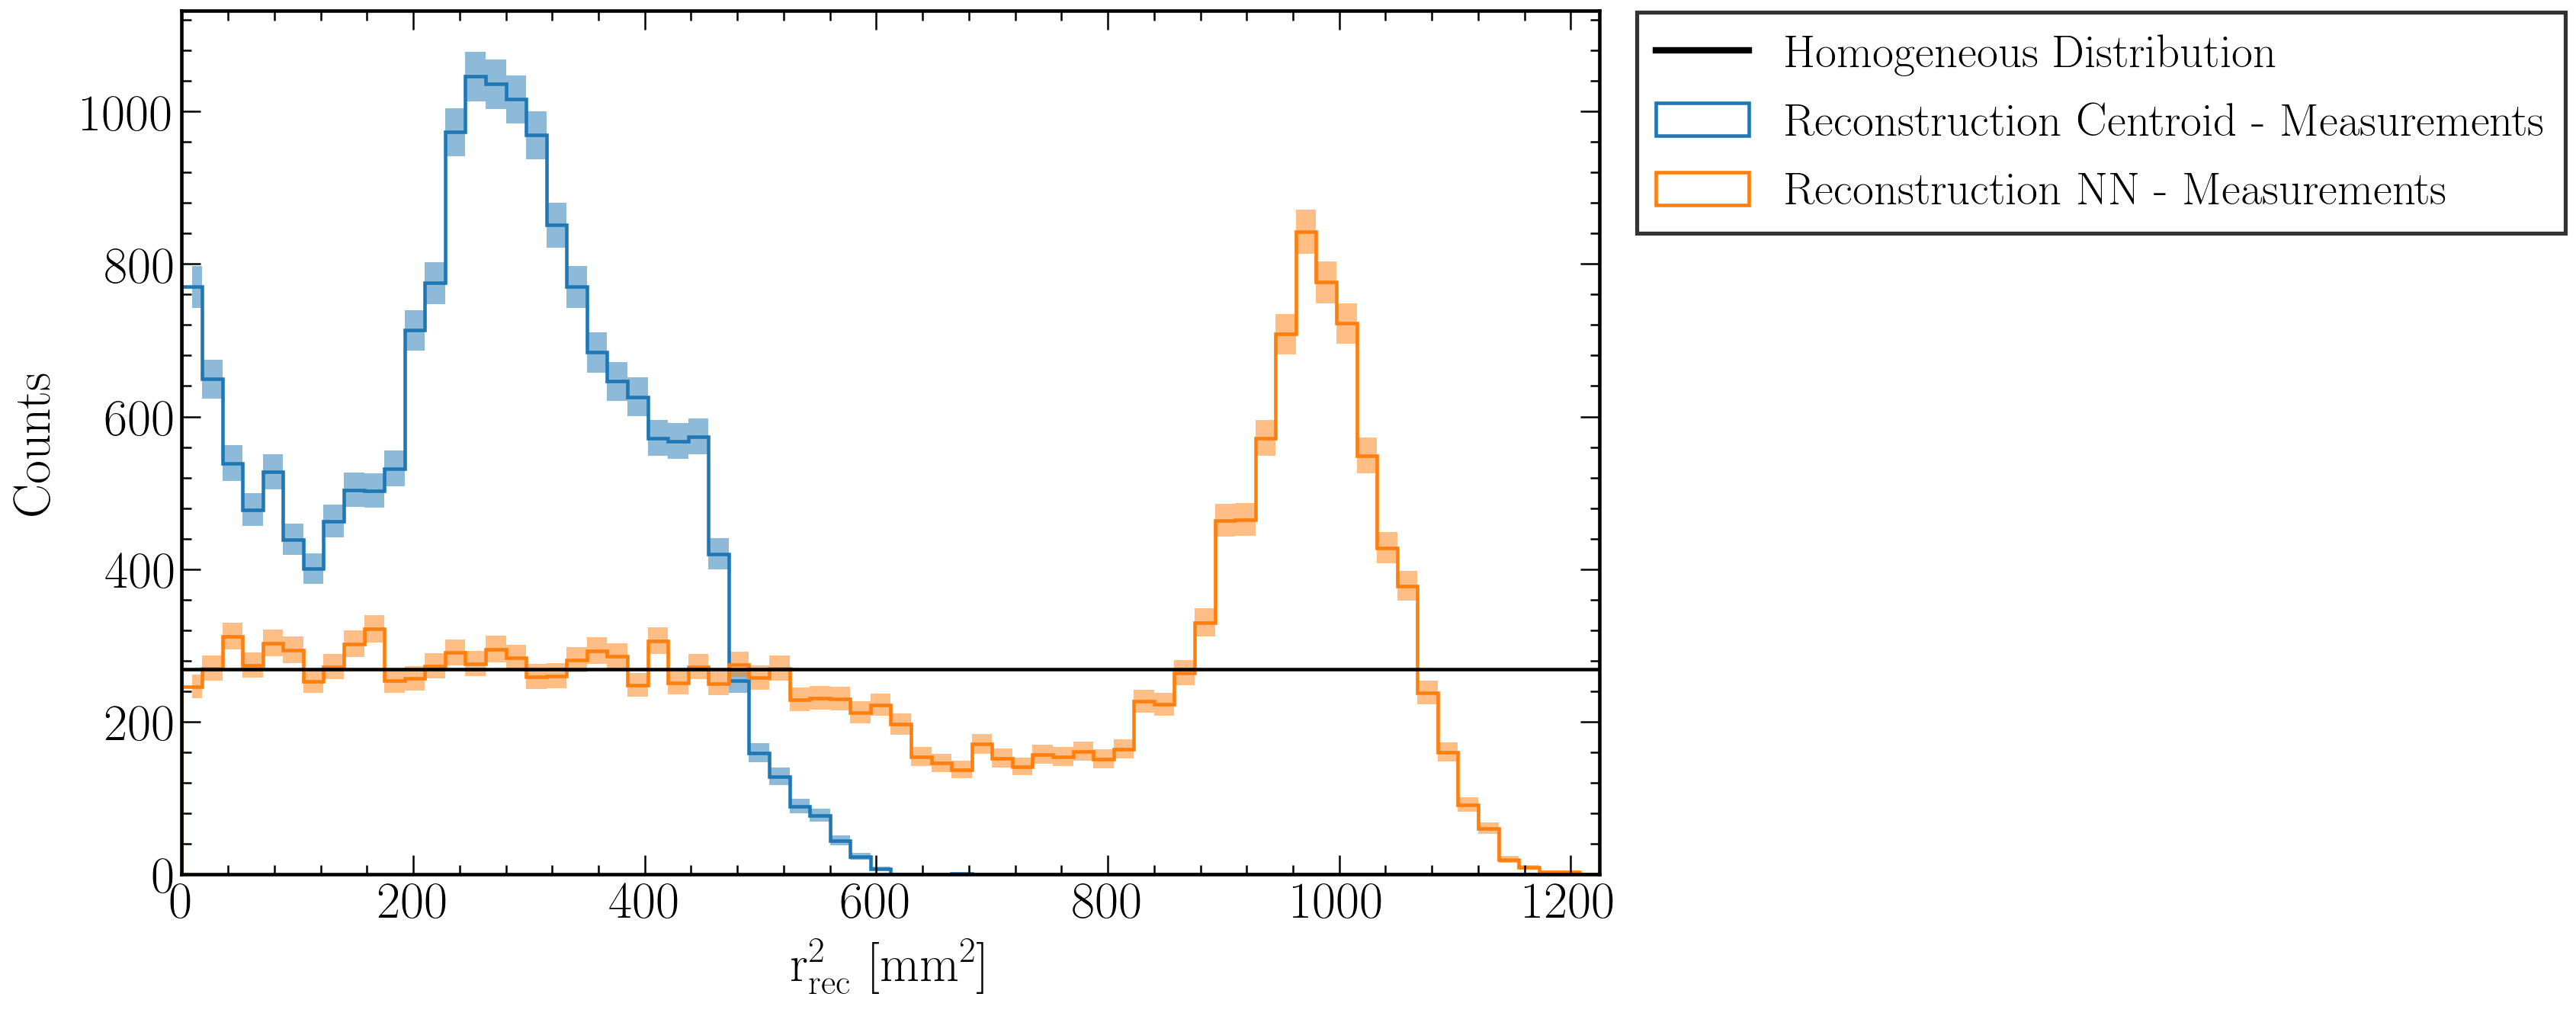

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid, y_pos_Centroid)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroid - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN, y_pos_NN)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C1', label = 'Reconstruction NN - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C1', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_Centroids_NN_r2spectrum.png", bbox_inches = "tight")
plt.show()

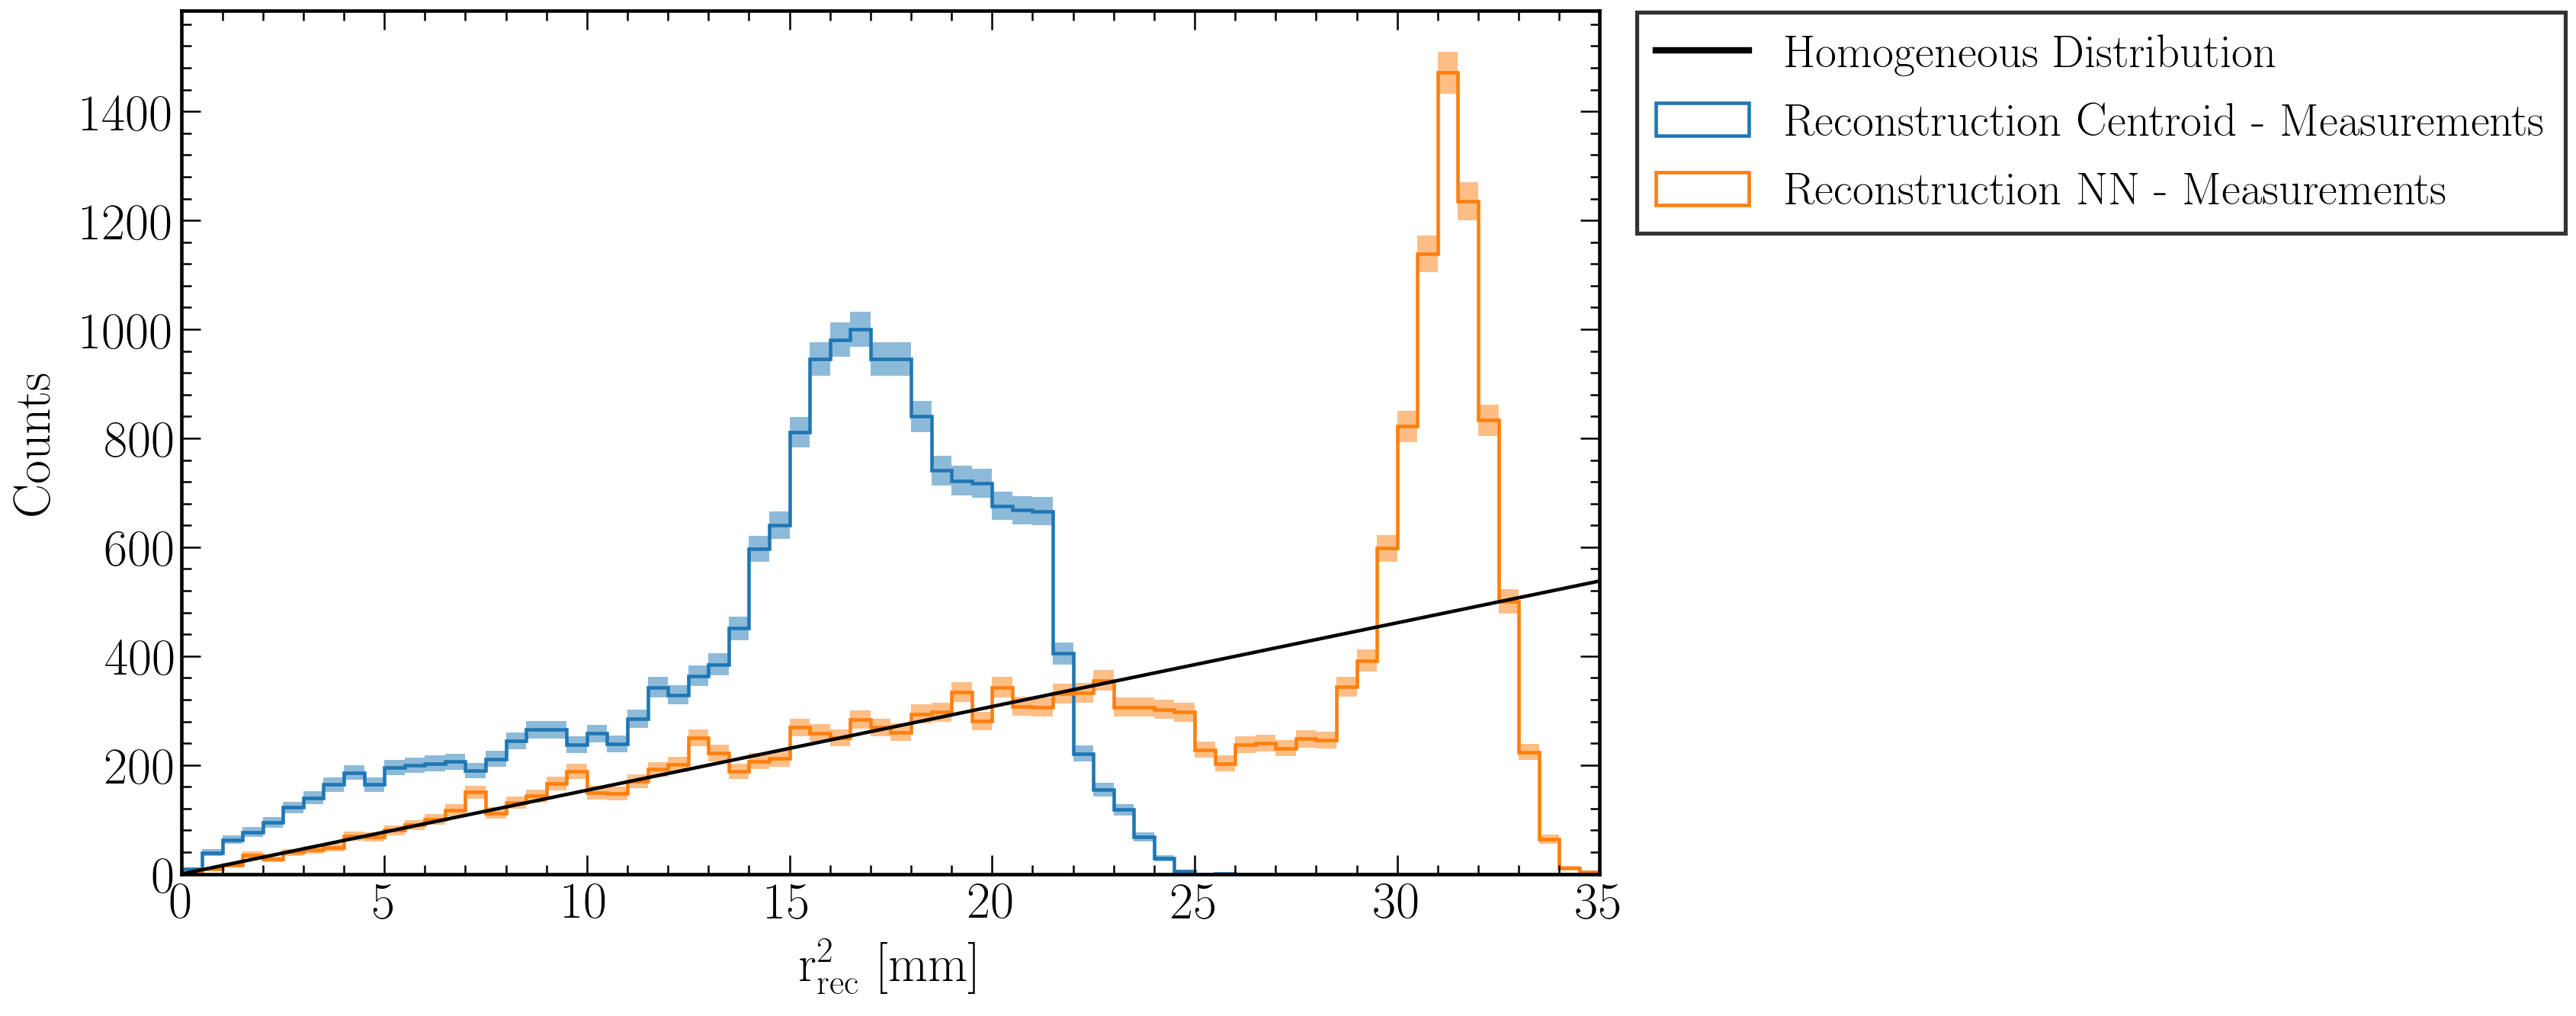

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid, y_pos_Centroid), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroid - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN, y_pos_NN), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C1', label = 'Reconstruction NN - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C1', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_Centroids_NN_rspectrum.png", bbox_inches = "tight")
plt.show()

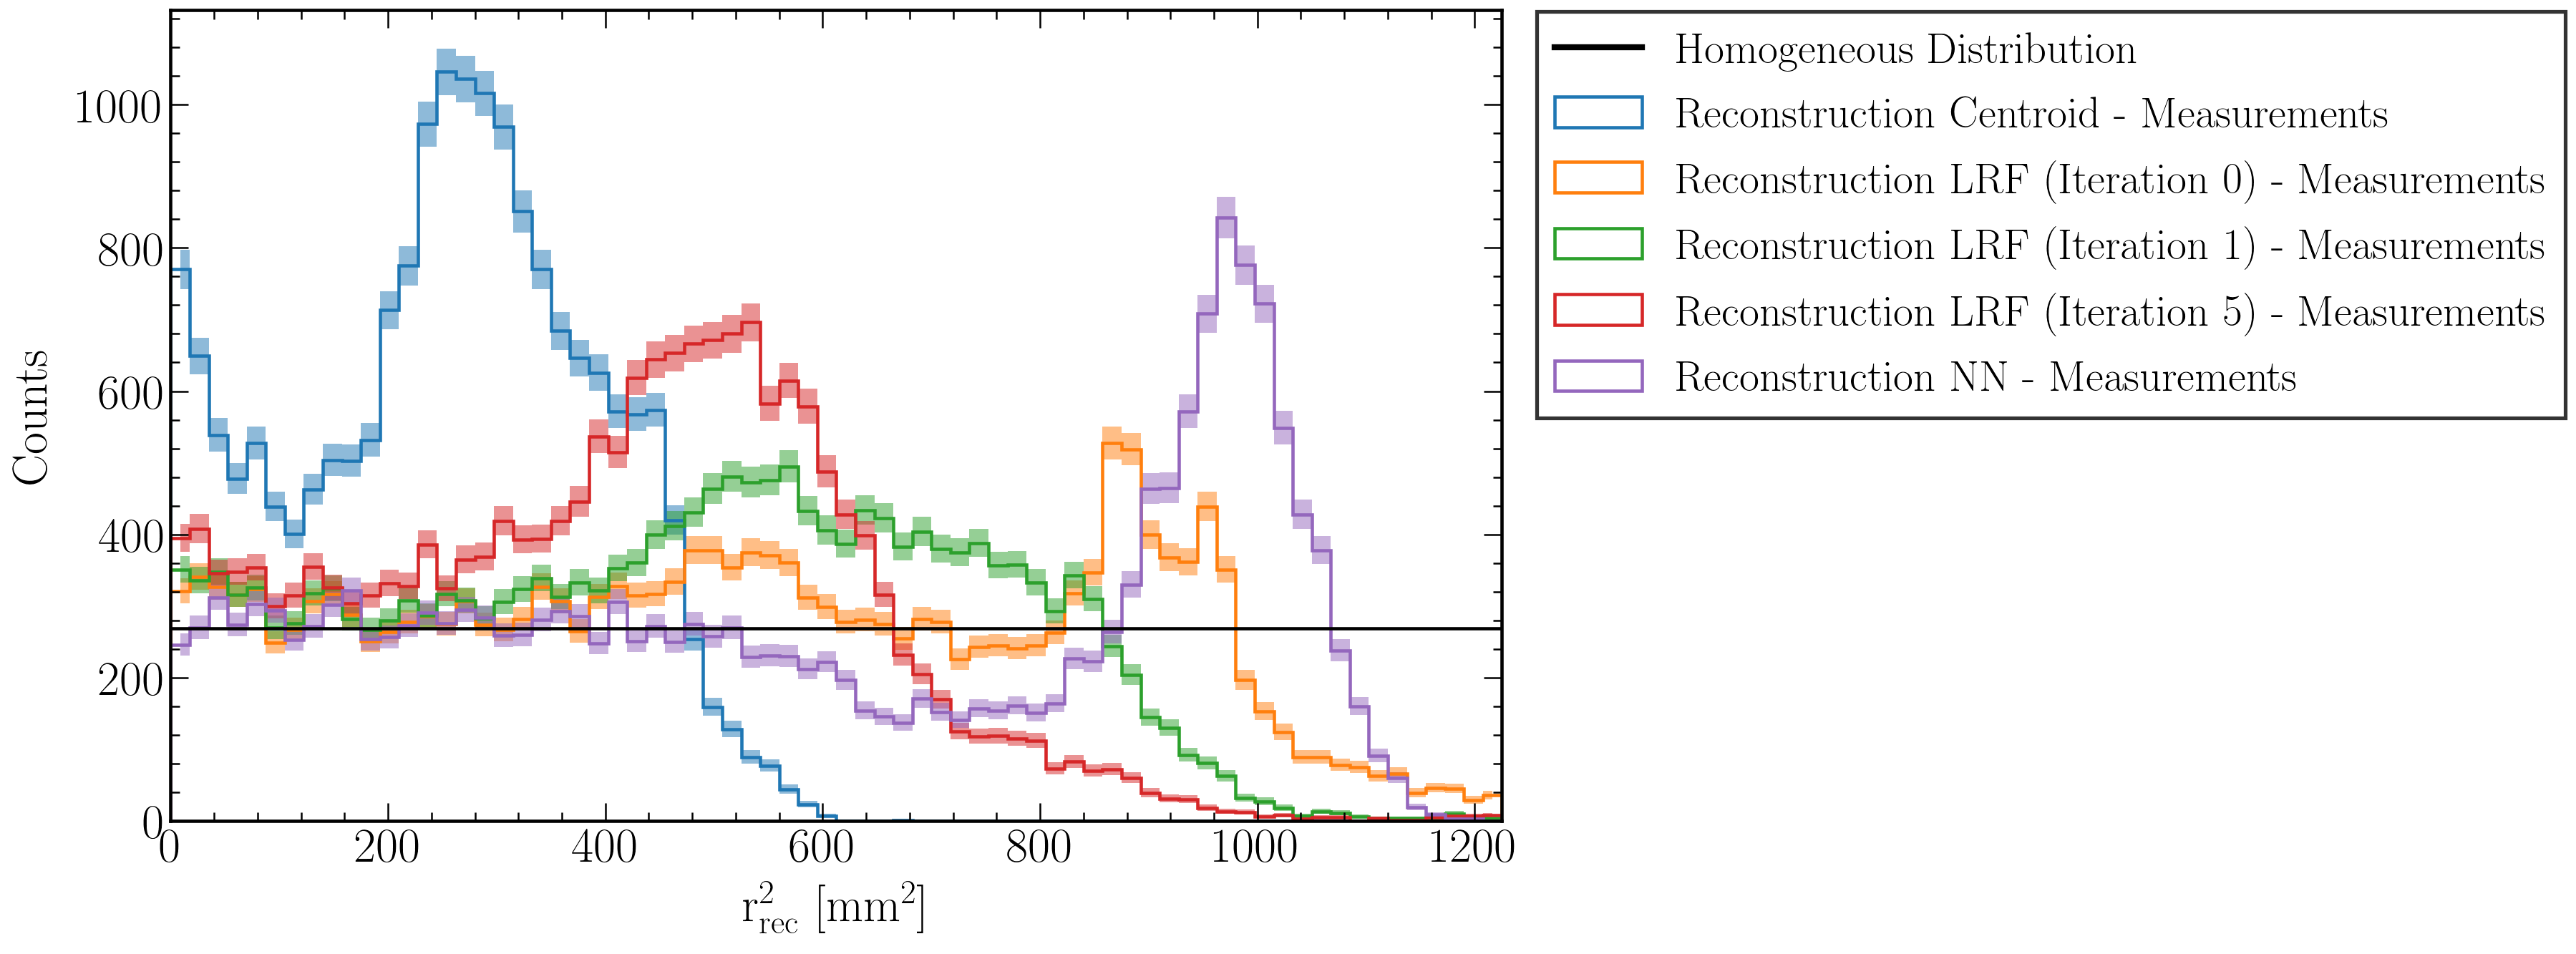

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid, y_pos_Centroid)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroid - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration0, y_pos_LRF_iteration0)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C1', label = 'Reconstruction LRF (Iteration 0) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C1', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration1, y_pos_LRF_iteration1)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C2', label = 'Reconstruction LRF (Iteration 1) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C2', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration5, y_pos_LRF_iteration5)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C3', label = 'Reconstruction LRF (Iteration 5) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C3', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN, y_pos_NN)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C4', label = 'Reconstruction NN - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C4', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_Centroids_LRF_NN_r2spectrum.png", bbox_inches = "tight")
plt.show()

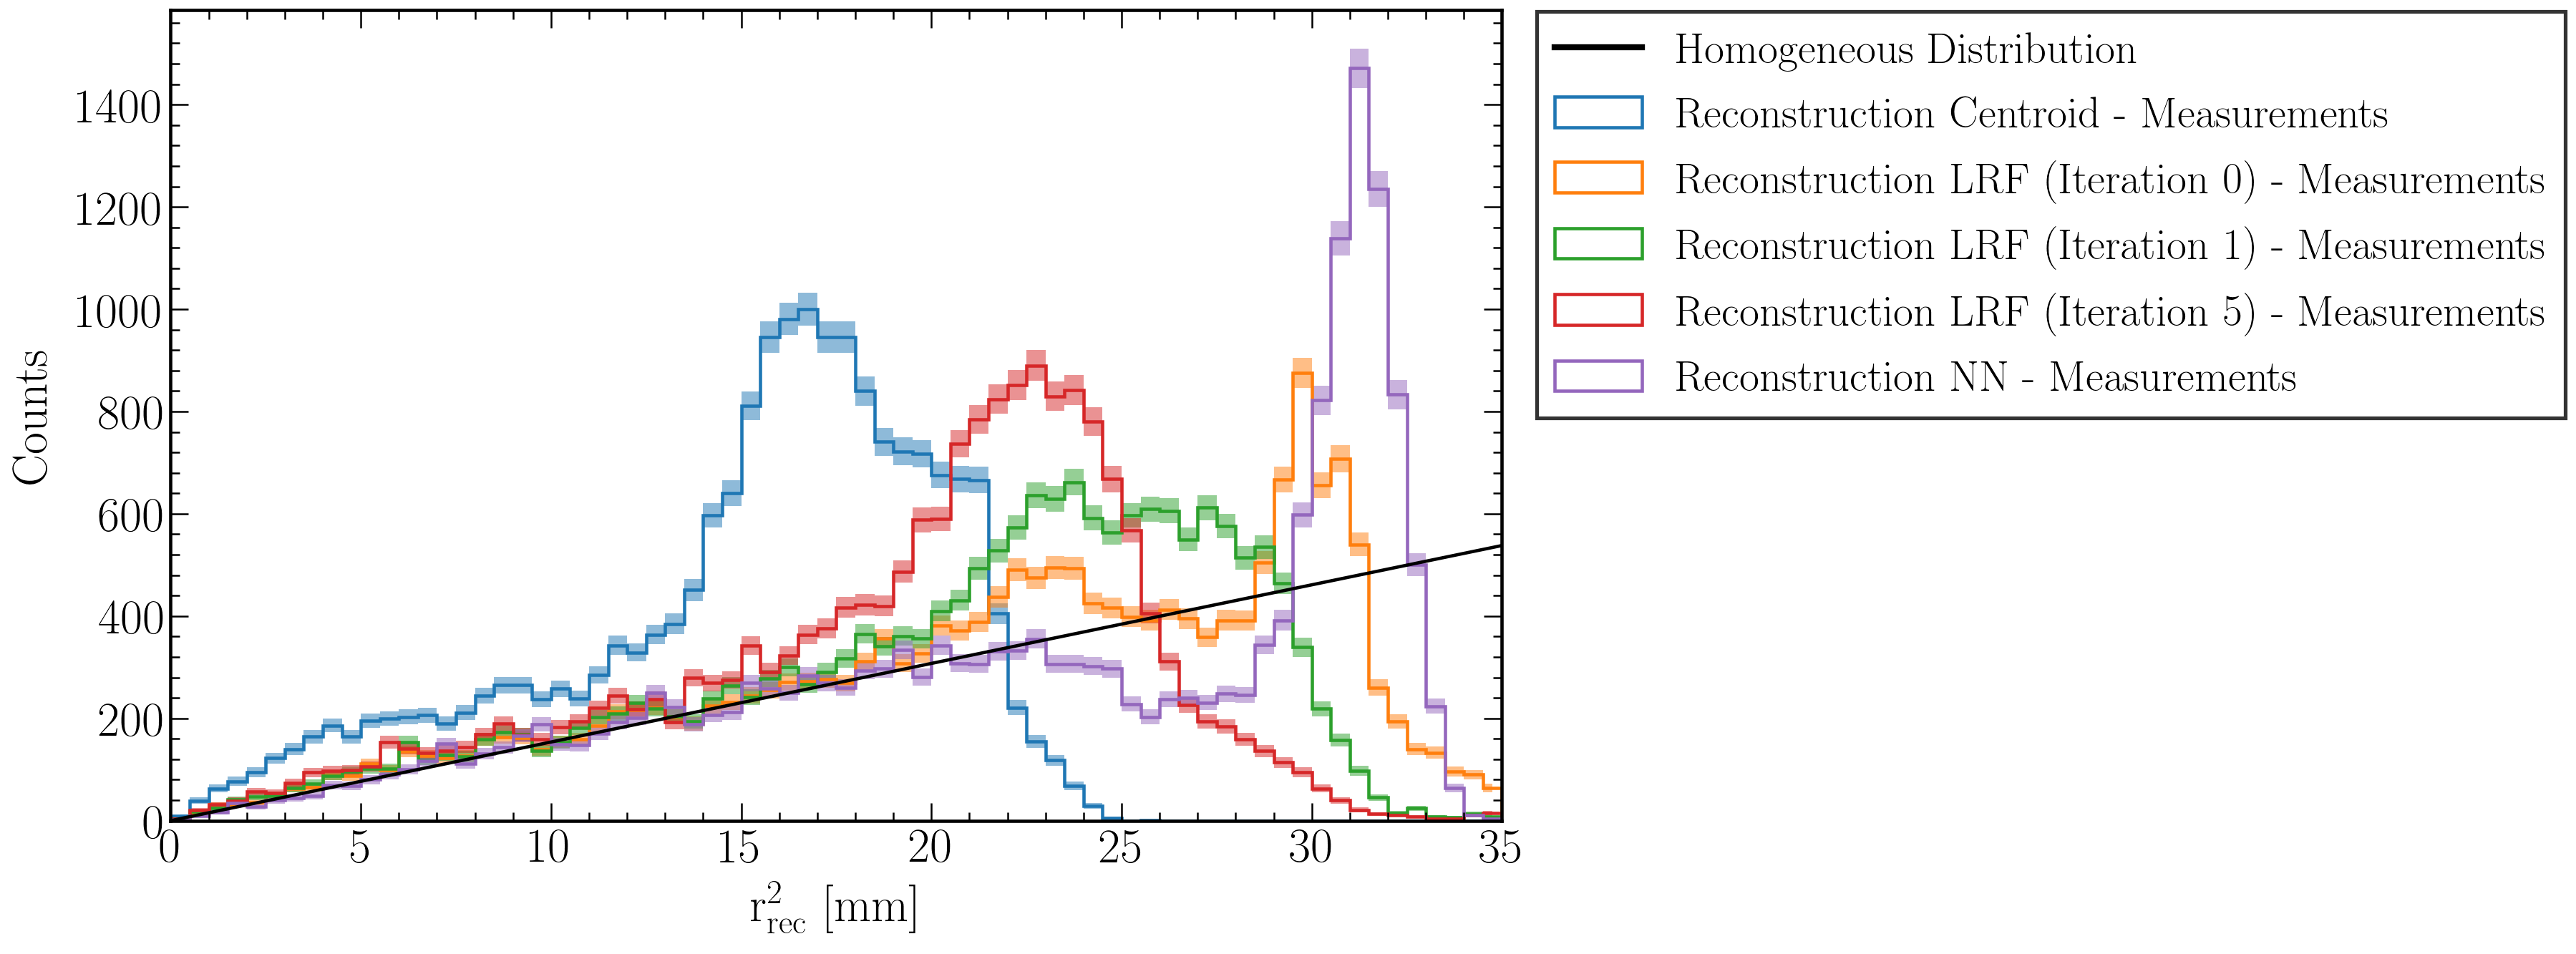

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid, y_pos_Centroid), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroid - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration0, y_pos_LRF_iteration0), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C1', label = 'Reconstruction LRF (Iteration 0) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C1', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration1, y_pos_LRF_iteration1), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C2', label = 'Reconstruction LRF (Iteration 1) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C2', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_LRF_iteration5, y_pos_LRF_iteration5), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C3', label = 'Reconstruction LRF (Iteration 5) - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C3', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN, y_pos_NN), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C4', label = 'Reconstruction NN - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C4', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_Centroids_LRF_NN_rspectrum.png", bbox_inches = "tight")
plt.show()

### Comparison Measurements - Simulations

#### NN

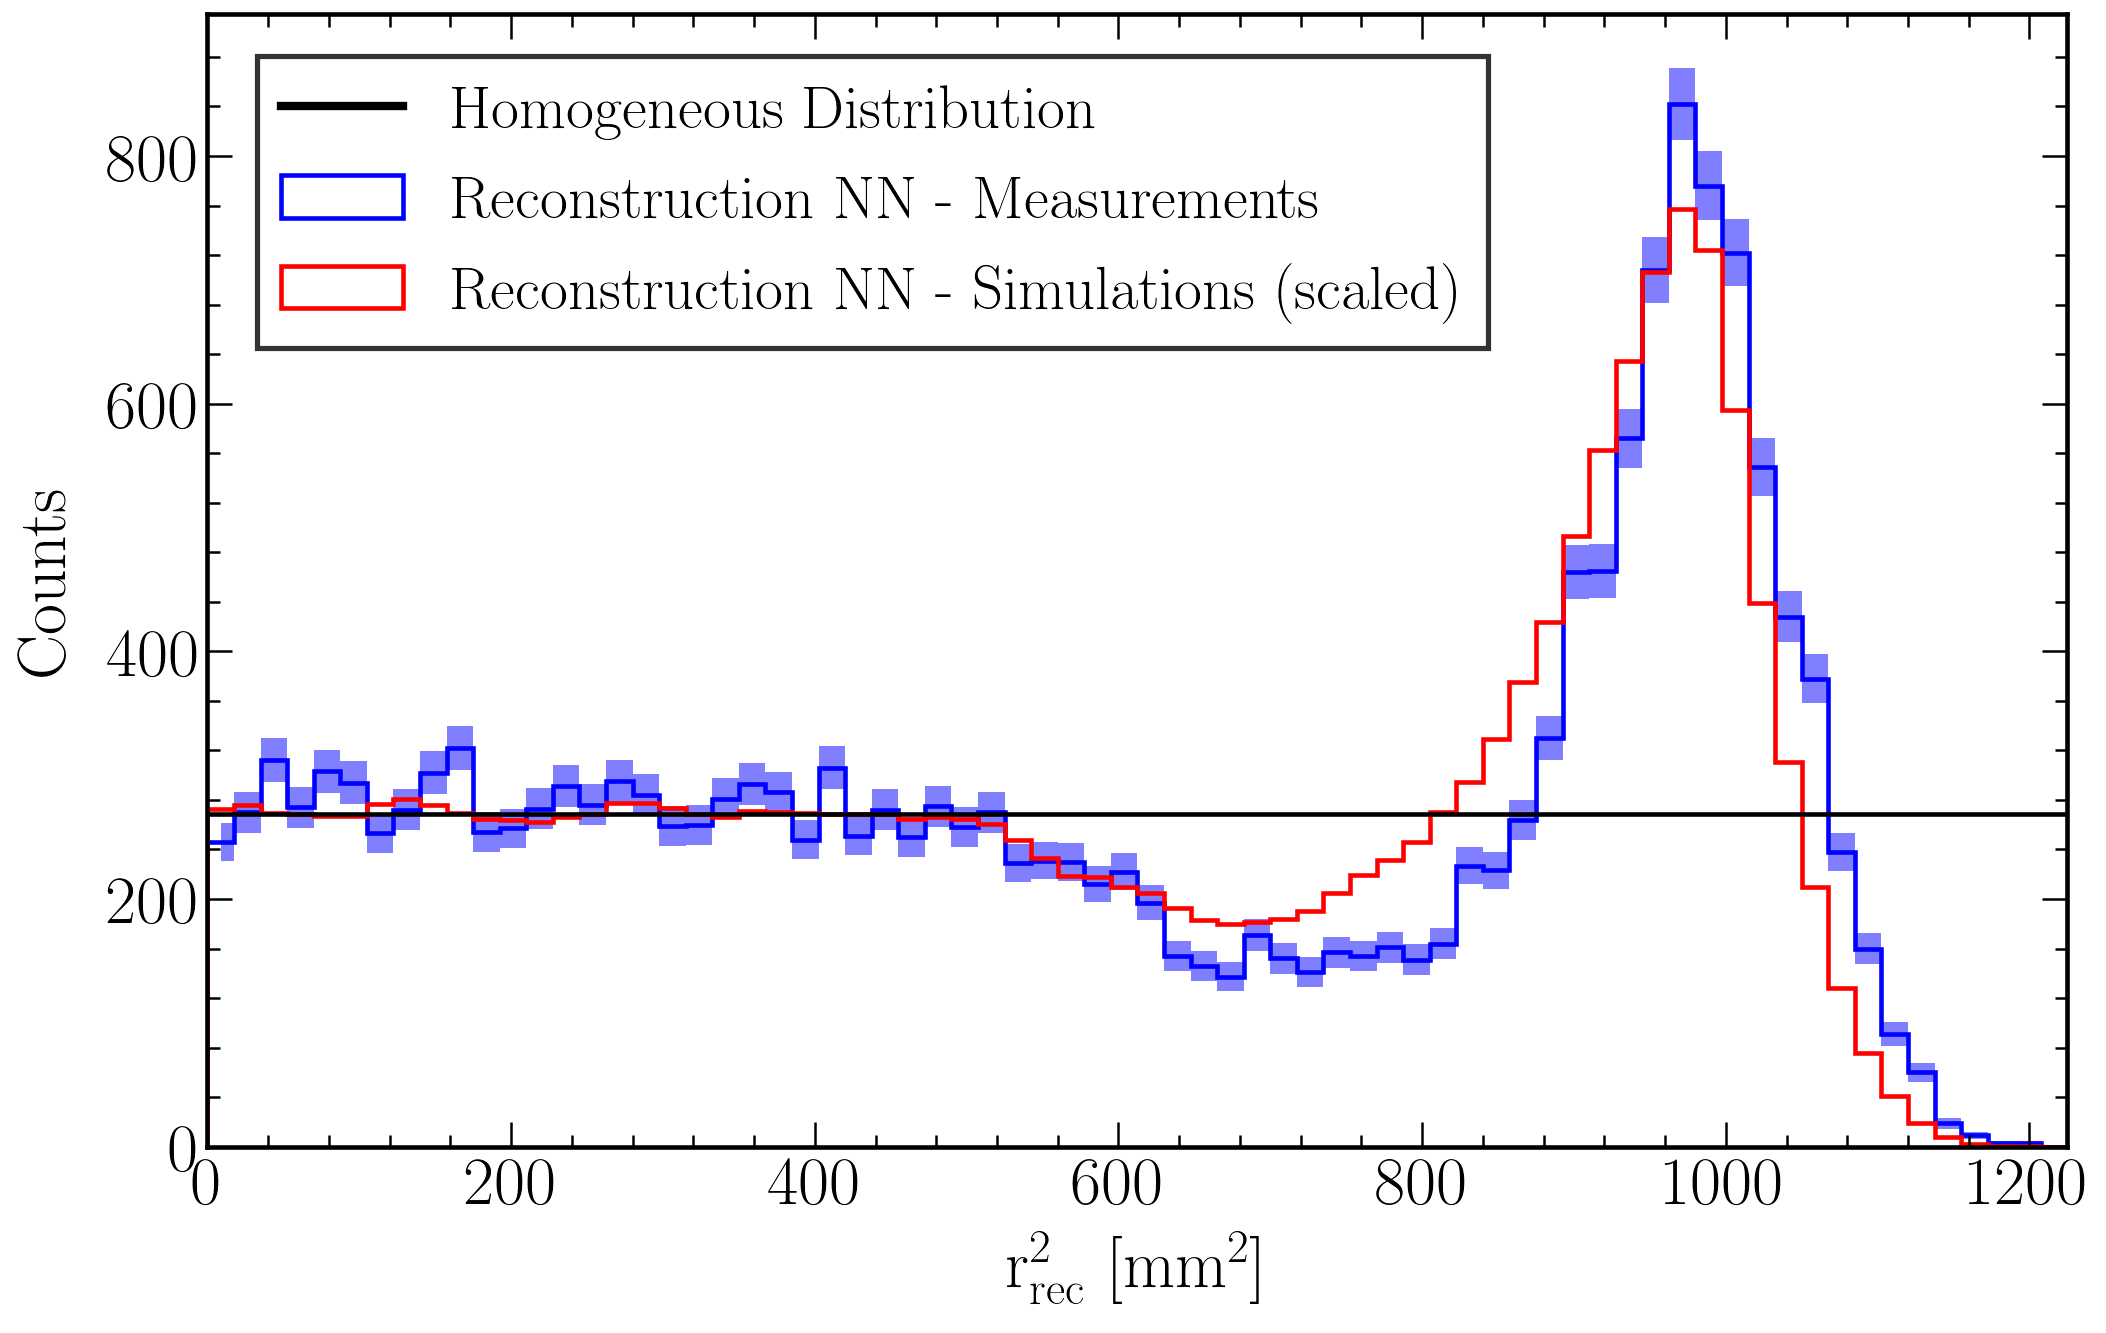

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN, y_pos_NN)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'blue', label = 'Reconstruction NN - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='blue', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN_sim, y_pos_NN_sim)**2, bins = bns, 
         weights = [x_pos_NN.shape[0] / x_pos_NN_sim.shape[0]]*x_pos_NN_sim.shape[0],
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'red', label = 'Reconstruction NN - Simulations (scaled)')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, 
                 (n - np.sqrt(n)*(x_pos_NN.shape[0] / x_pos_NN_sim.shape[0])), 
                 (n + np.sqrt(n)*(x_pos_NN.shape[0] / x_pos_NN_sim.shape[0])), 
                 facecolor='red', alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_NN_r2spectrum_vs_simulations.png", bbox_inches = "tight")
plt.show()

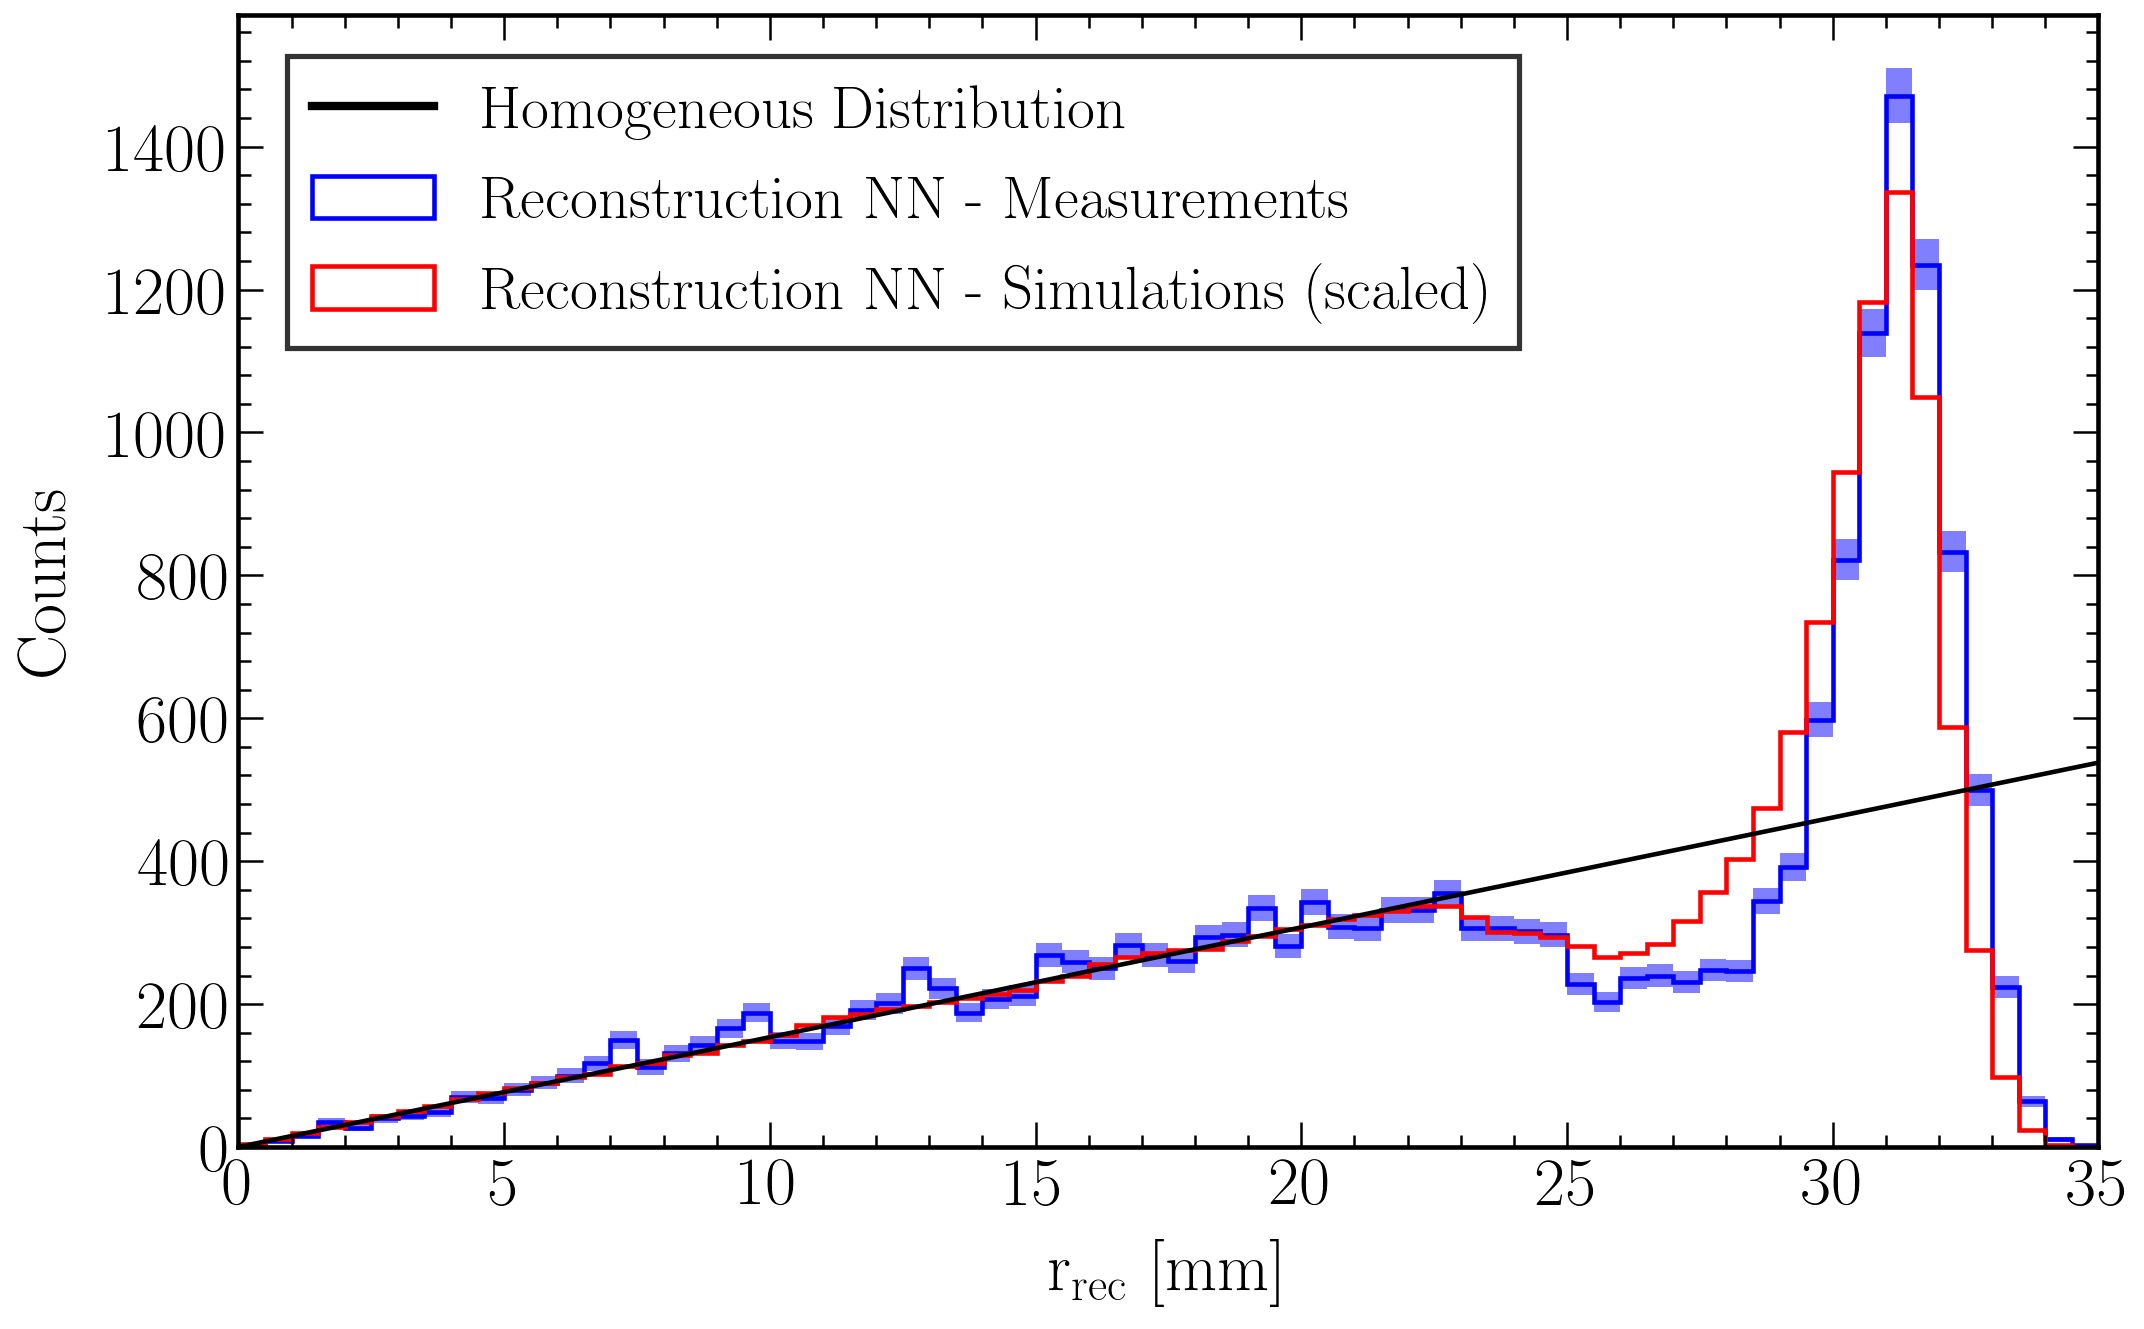

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_NN.shape[0] # min(x_pos_NN.shape[0], x_pos_NN_sim.shape[0])

plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN, y_pos_NN), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'blue', label = 'Reconstruction NN - Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='blue', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_NN_sim, y_pos_NN_sim), bins = bns, 
         weights = [x_pos_NN.shape[0] / x_pos_NN_sim.shape[0]]*x_pos_NN_sim.shape[0],
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'red', label = 'Reconstruction NN - Simulations (scaled)')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, 
                 (n - np.sqrt(n)*(x_pos_NN.shape[0] / x_pos_NN_sim.shape[0])), 
                 (n + np.sqrt(n)*(x_pos_NN.shape[0] / x_pos_NN_sim.shape[0])), 
                 facecolor='red', alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_NN_rspectrum_vs_simulations.png", bbox_inches = "tight")
plt.show()

#### Centroids

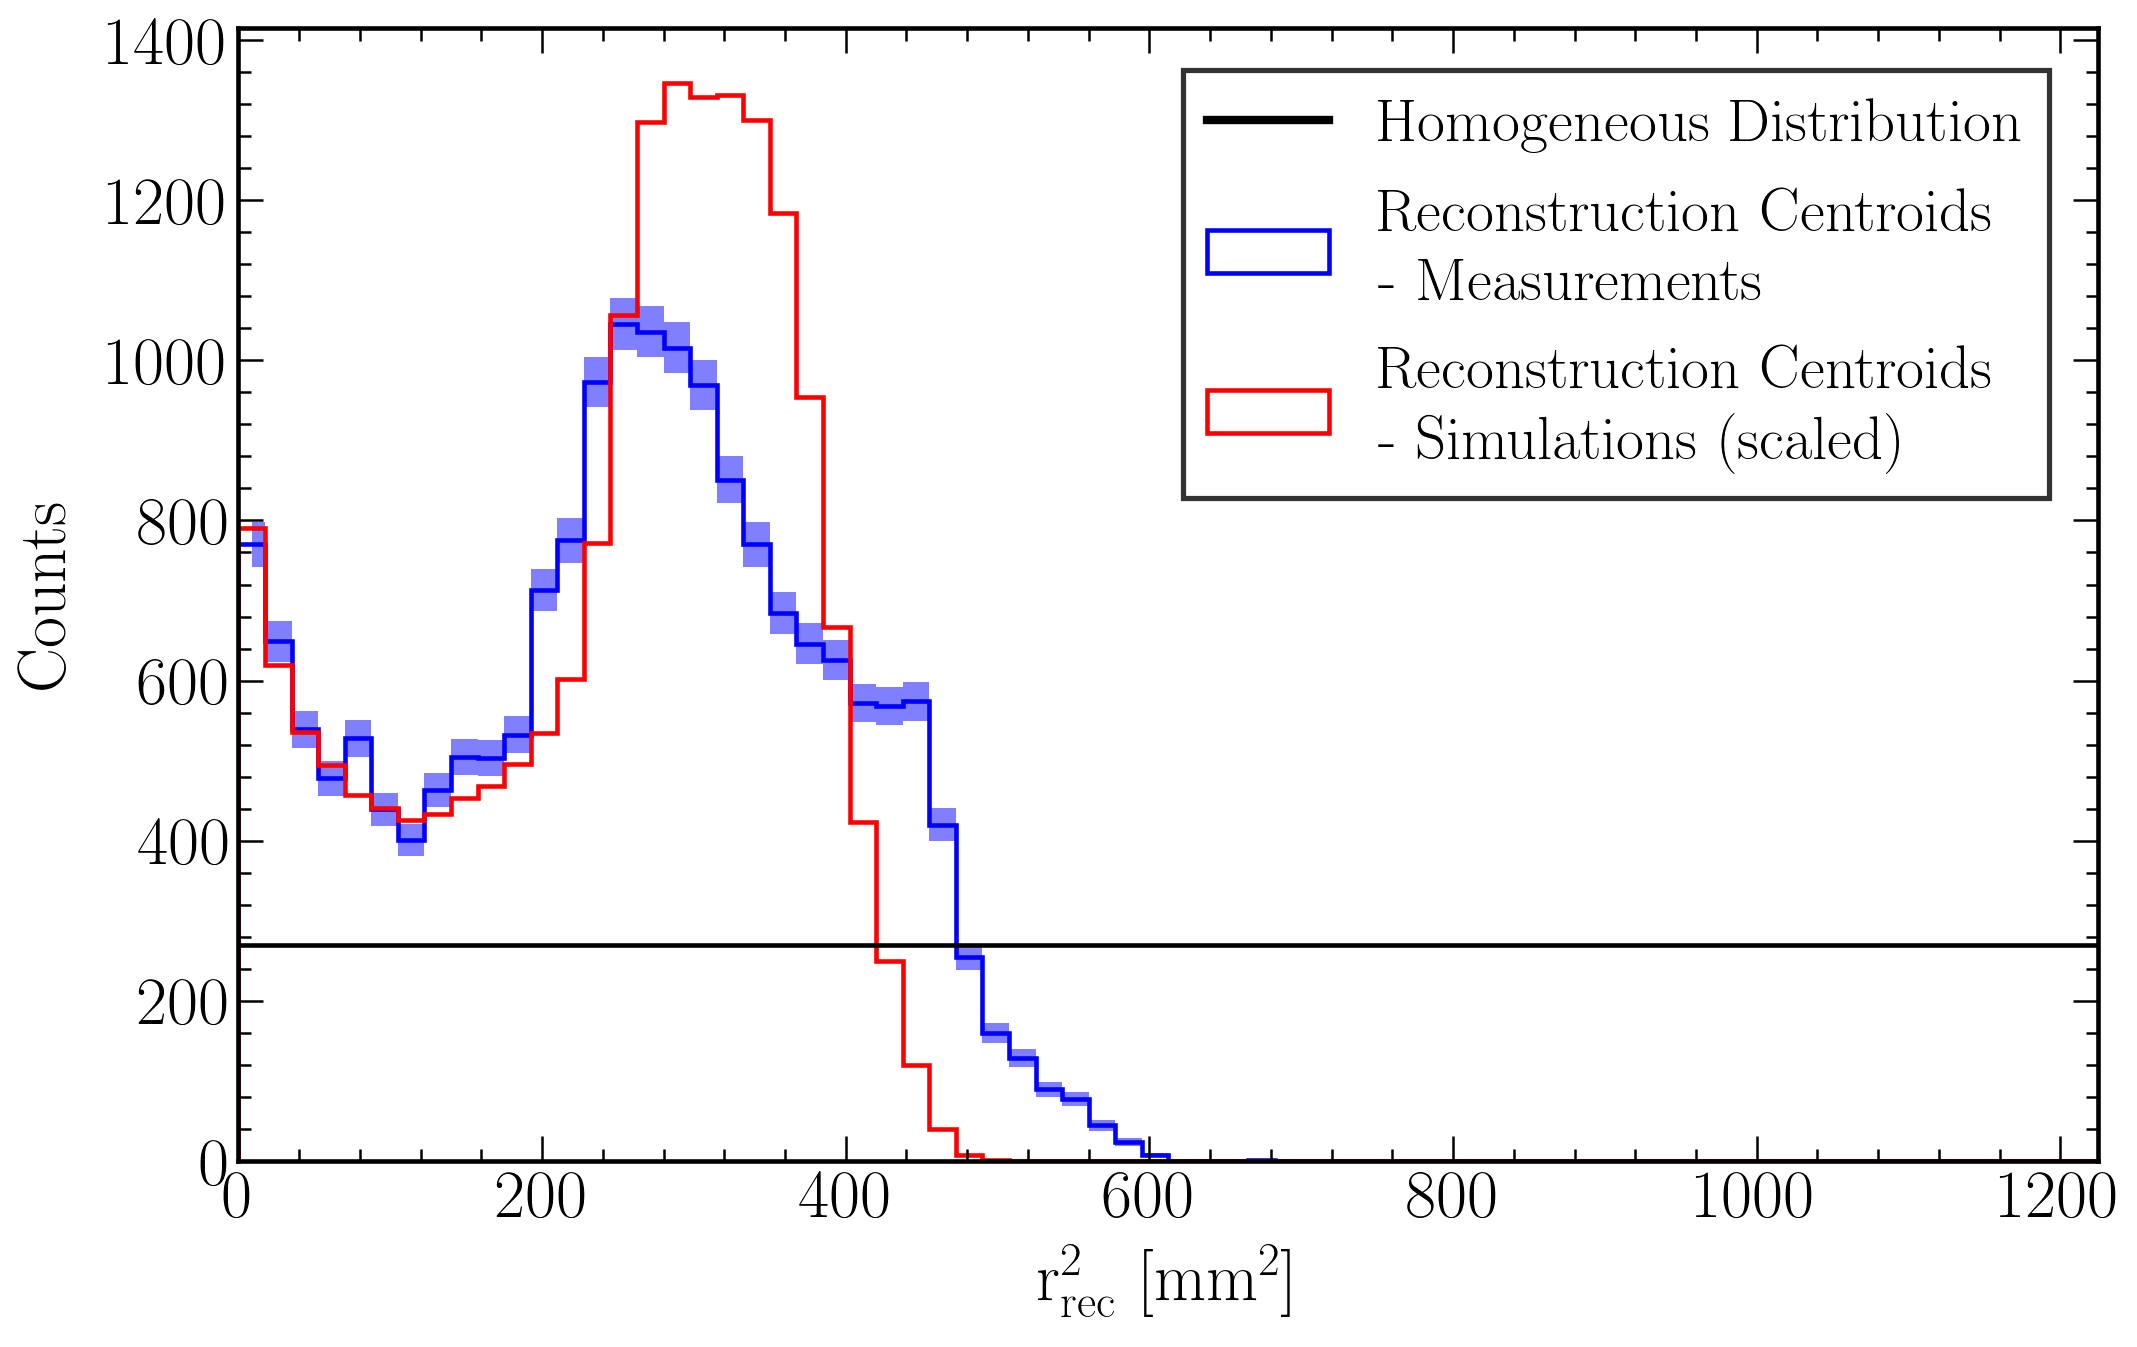

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_Centroid.shape[0] # min(x_pos_Centroid.shape[0], x_pos_Centroid_sim.shape[0])

plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid, y_pos_Centroid)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'blue', label = 'Reconstruction Centroids\n- Measurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='blue', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid_sim, y_pos_Centroid_sim)**2, bins = bns, 
         weights = [x_pos_Centroid.shape[0] / x_pos_Centroid_sim.shape[0]]*x_pos_Centroid_sim.shape[0],
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'red', label = 'Reconstruction Centroids\n- Simulations (scaled)')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, 
                 (n - np.sqrt(n)*(x_pos_Centroid.shape[0] / x_pos_Centroid_sim.shape[0])), 
                 (n + np.sqrt(n)*(x_pos_Centroid.shape[0] / x_pos_Centroid_sim.shape[0])), 
                 facecolor='red', alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_Centroids_r2spectrum_vs_simulations.png", bbox_inches = "tight")
plt.show()

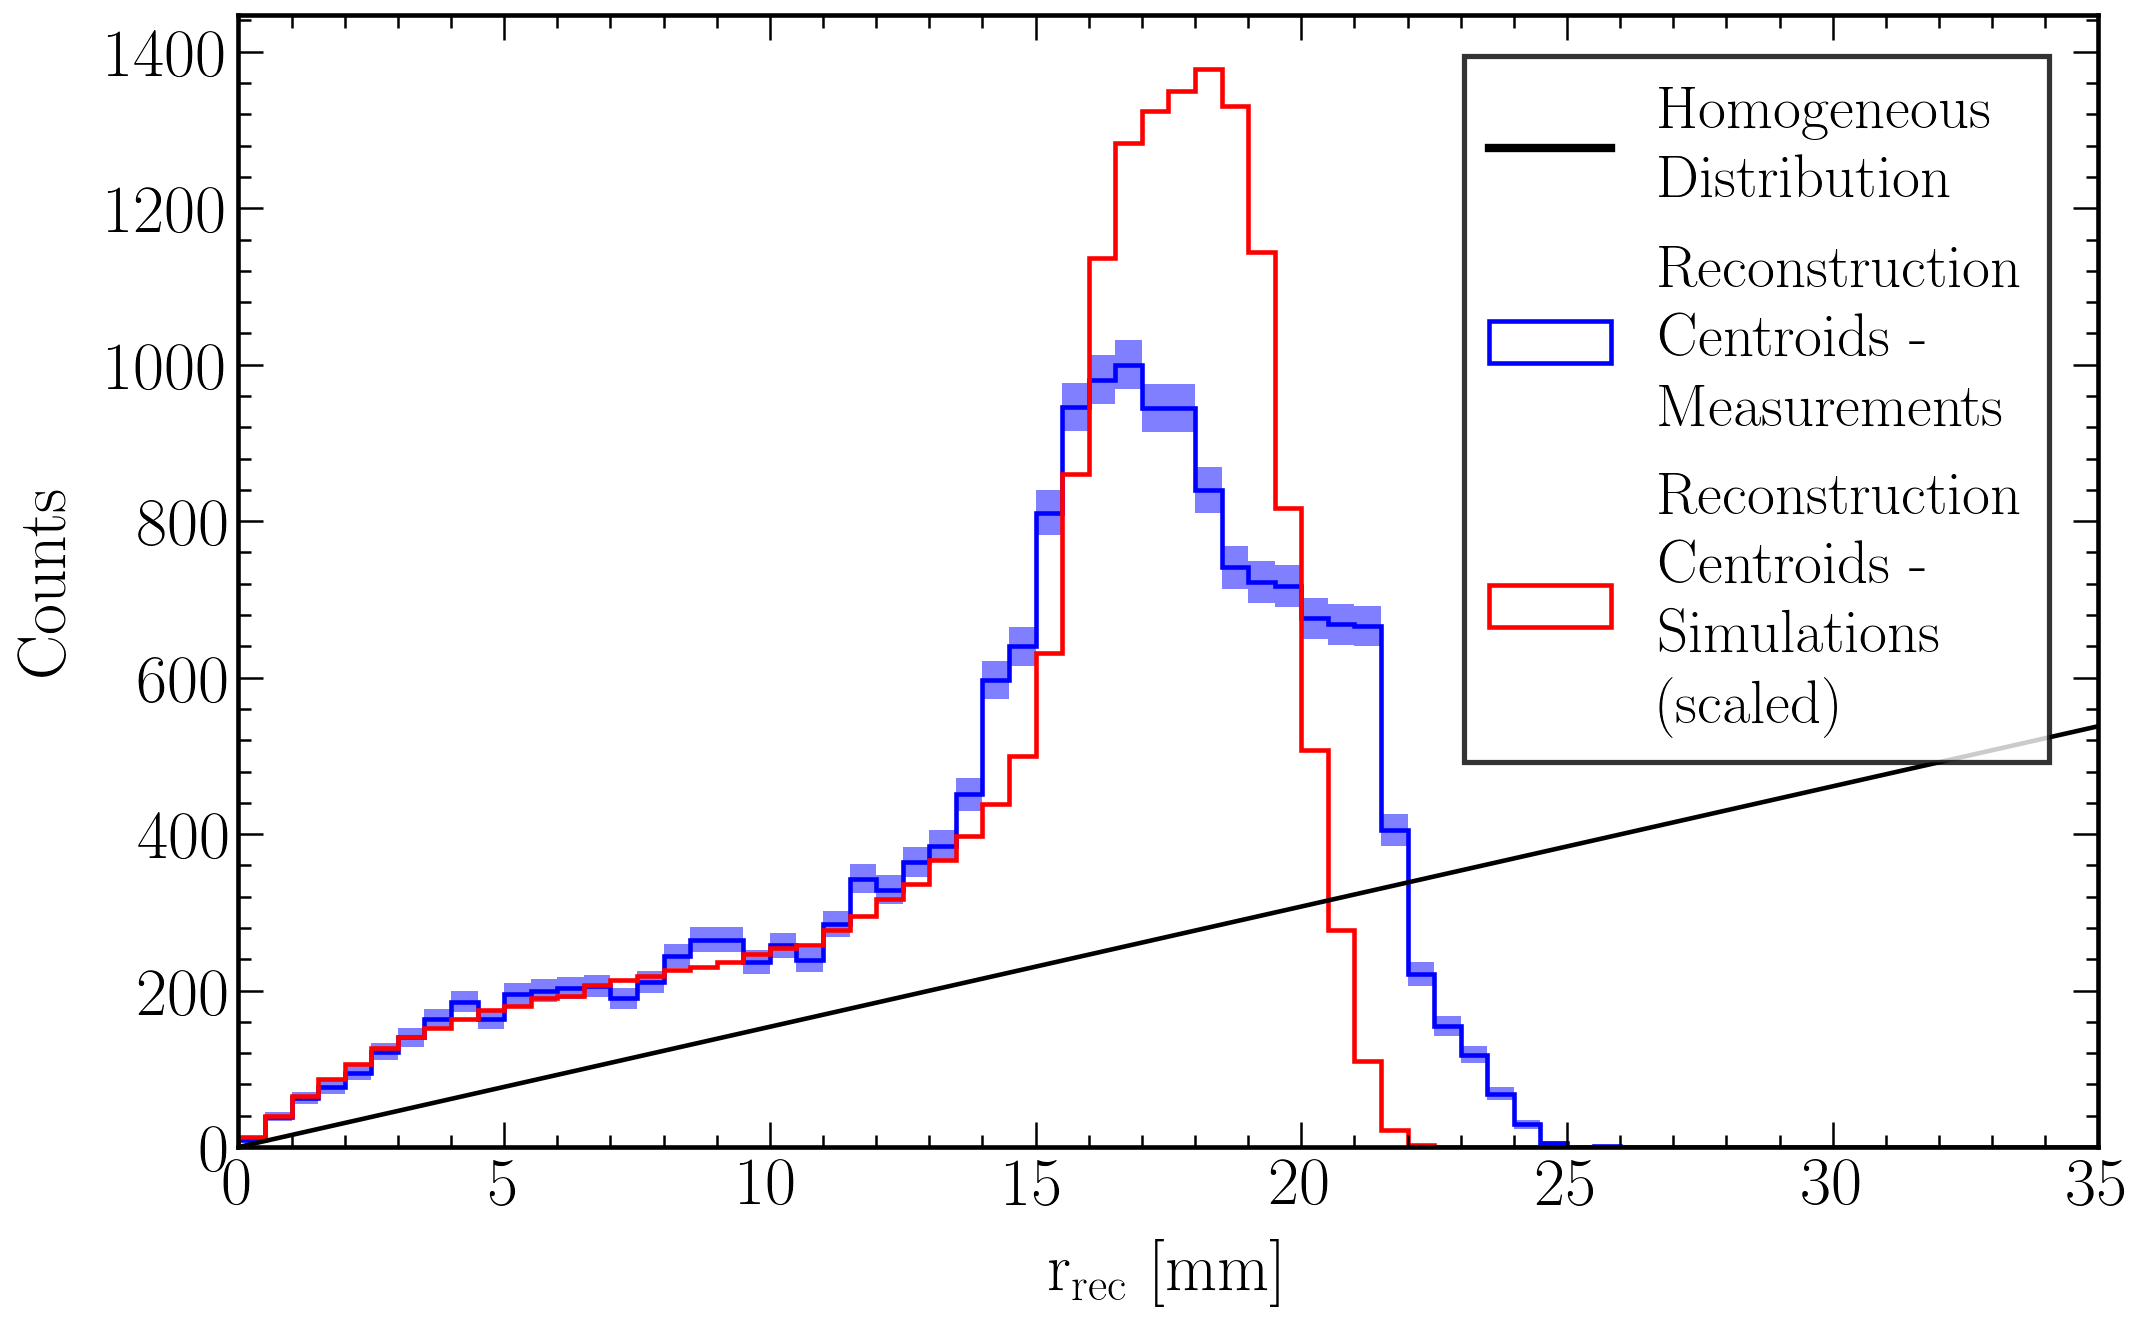

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70
cnts = x_pos_Centroid.shape[0] # min(x_pos_Centroid.shape[0], x_pos_Centroid_sim.shape[0])

plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
        label = 'Homogeneous\nDistribution')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid, y_pos_Centroid), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'blue', label = 'Reconstruction\nCentroids -\nMeasurements')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='blue', 
                 alpha=0.5, step = 'mid')

n, bins, *patches = plt.hist(np.hypot(x_pos_Centroid_sim, y_pos_Centroid_sim), bins = bns, 
         weights = [x_pos_Centroid.shape[0] / x_pos_Centroid_sim.shape[0]]*x_pos_Centroid_sim.shape[0],
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'red', label = 'Reconstruction\nCentroids -\nSimulations\n(scaled)')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, 
                 (n - np.sqrt(n)*(x_pos_Centroid.shape[0] / x_pos_Centroid_sim.shape[0])), 
                 (n + np.sqrt(n)*(x_pos_Centroid.shape[0] / x_pos_Centroid_sim.shape[0])), 
                 facecolor='red', alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_Centroids_rspectrum_vs_simulations.png", bbox_inches = "tight")
plt.show()

#### LRF

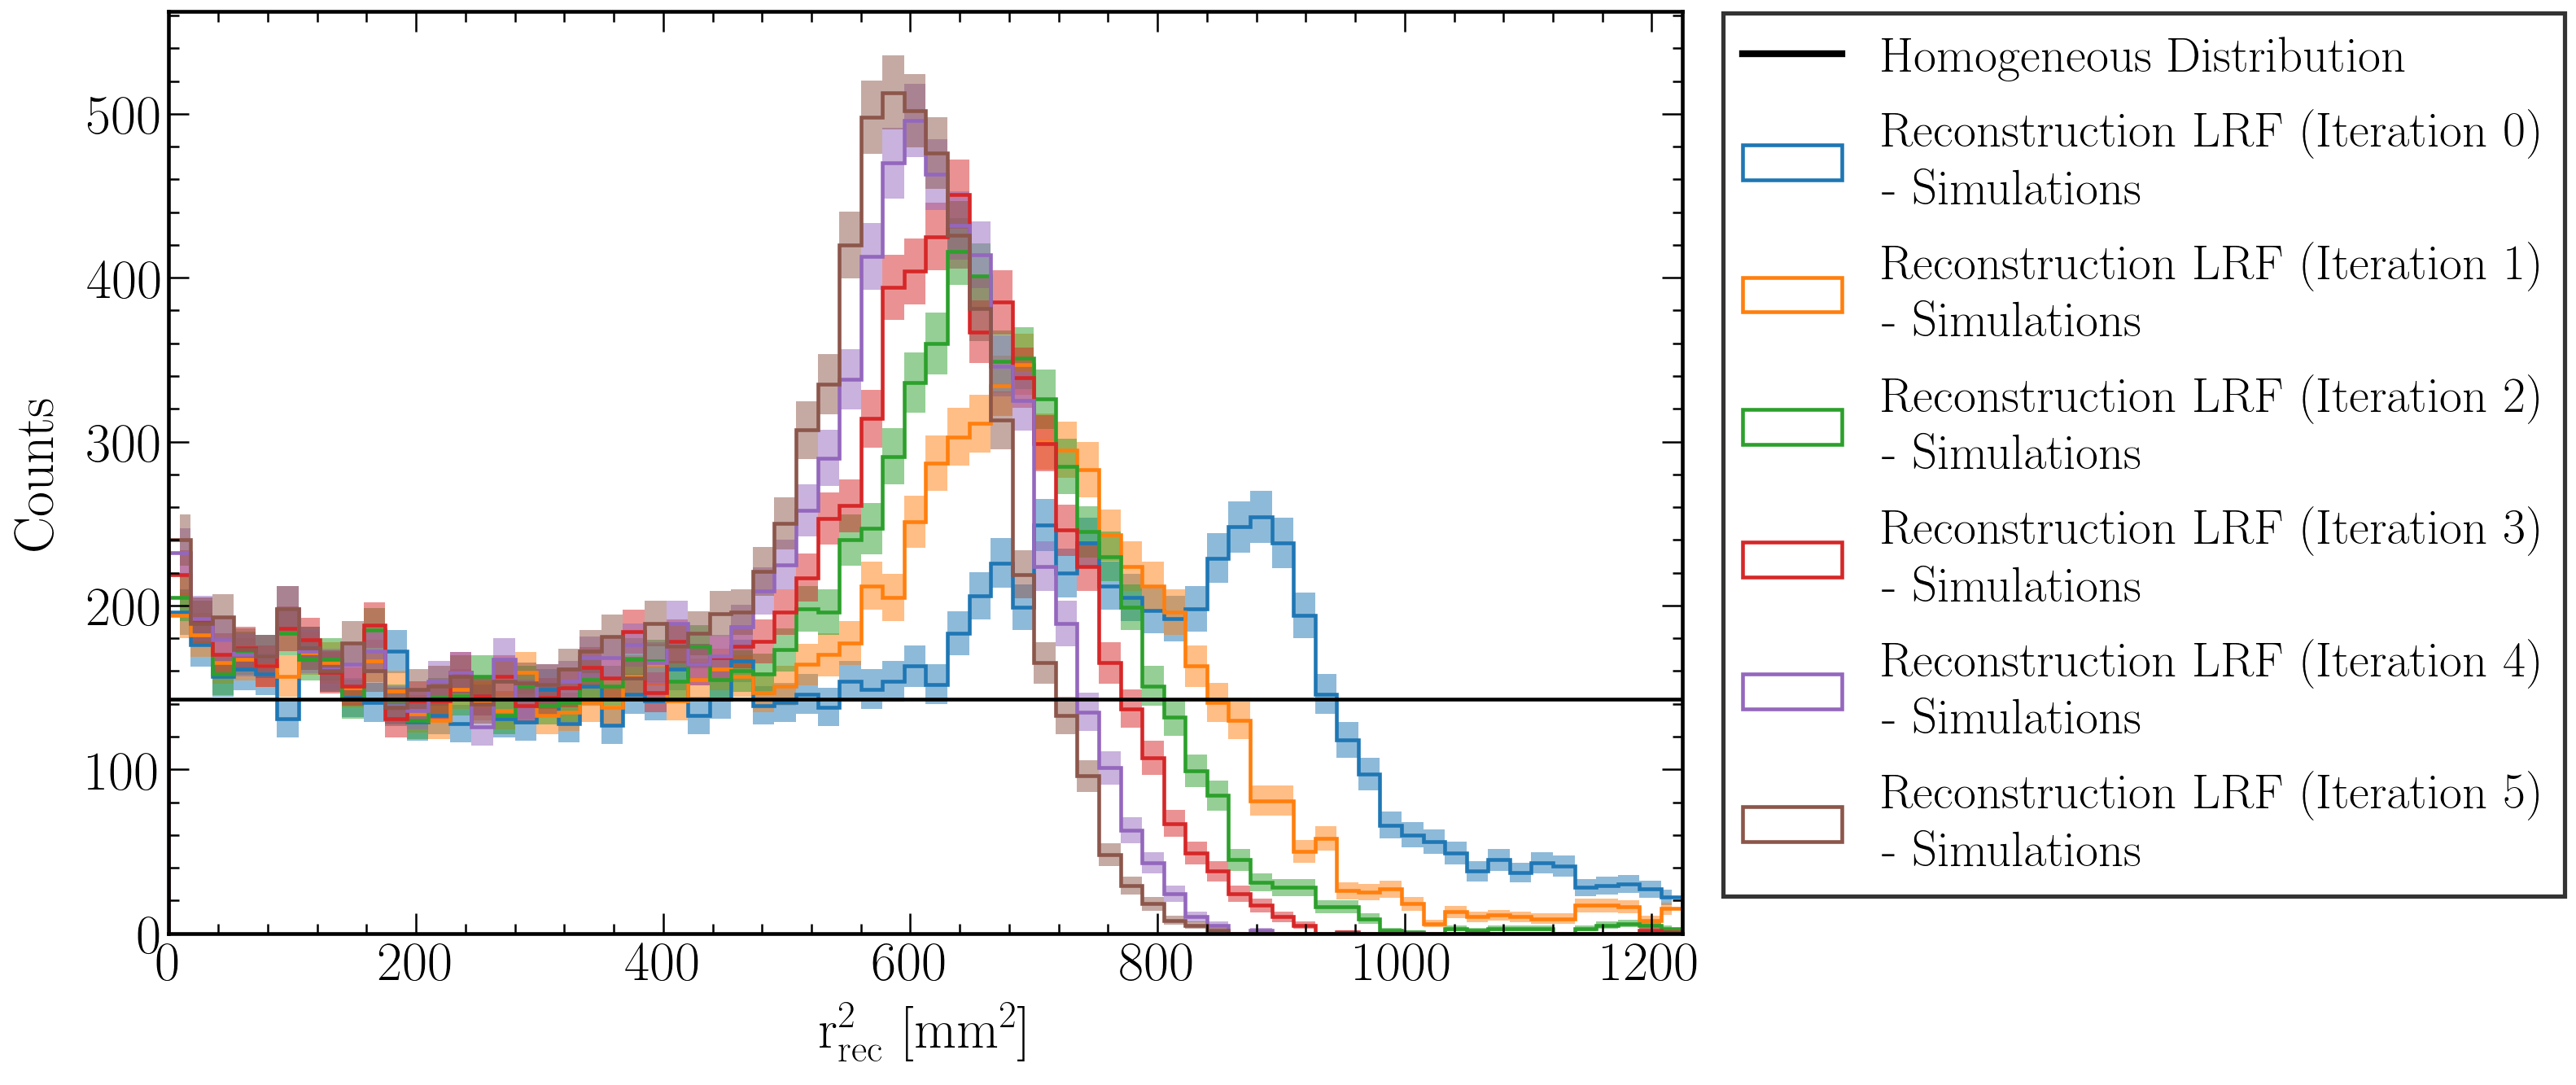

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

i = 0
cnts = eval('x_pos_LRF_iteration'+str(i)+'_sim').shape[0]

plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

for i in range(0,6):
    n, bins, *patches = plt.hist(np.hypot(eval('x_pos_LRF_iteration'+str(i)+'_sim'), 
                                          eval('y_pos_LRF_iteration'+str(i)+'_sim'))**2, 
                                 bins = bns, range = (0,35**2), density = False,
                                 histtype='step', linewidth = 2.2, color = 'C'+str(i), 
                                 label = 'Reconstruction LRF (Iteration '+str(i)+')\n- Simulations')
    bins_center = (bins[1:] + bins[:-1]) / 2
    plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C'+str(i), 
                     alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filename_LRF+"_predictions_LRF_r2spectrum.png", bbox_inches = "tight")
plt.show()

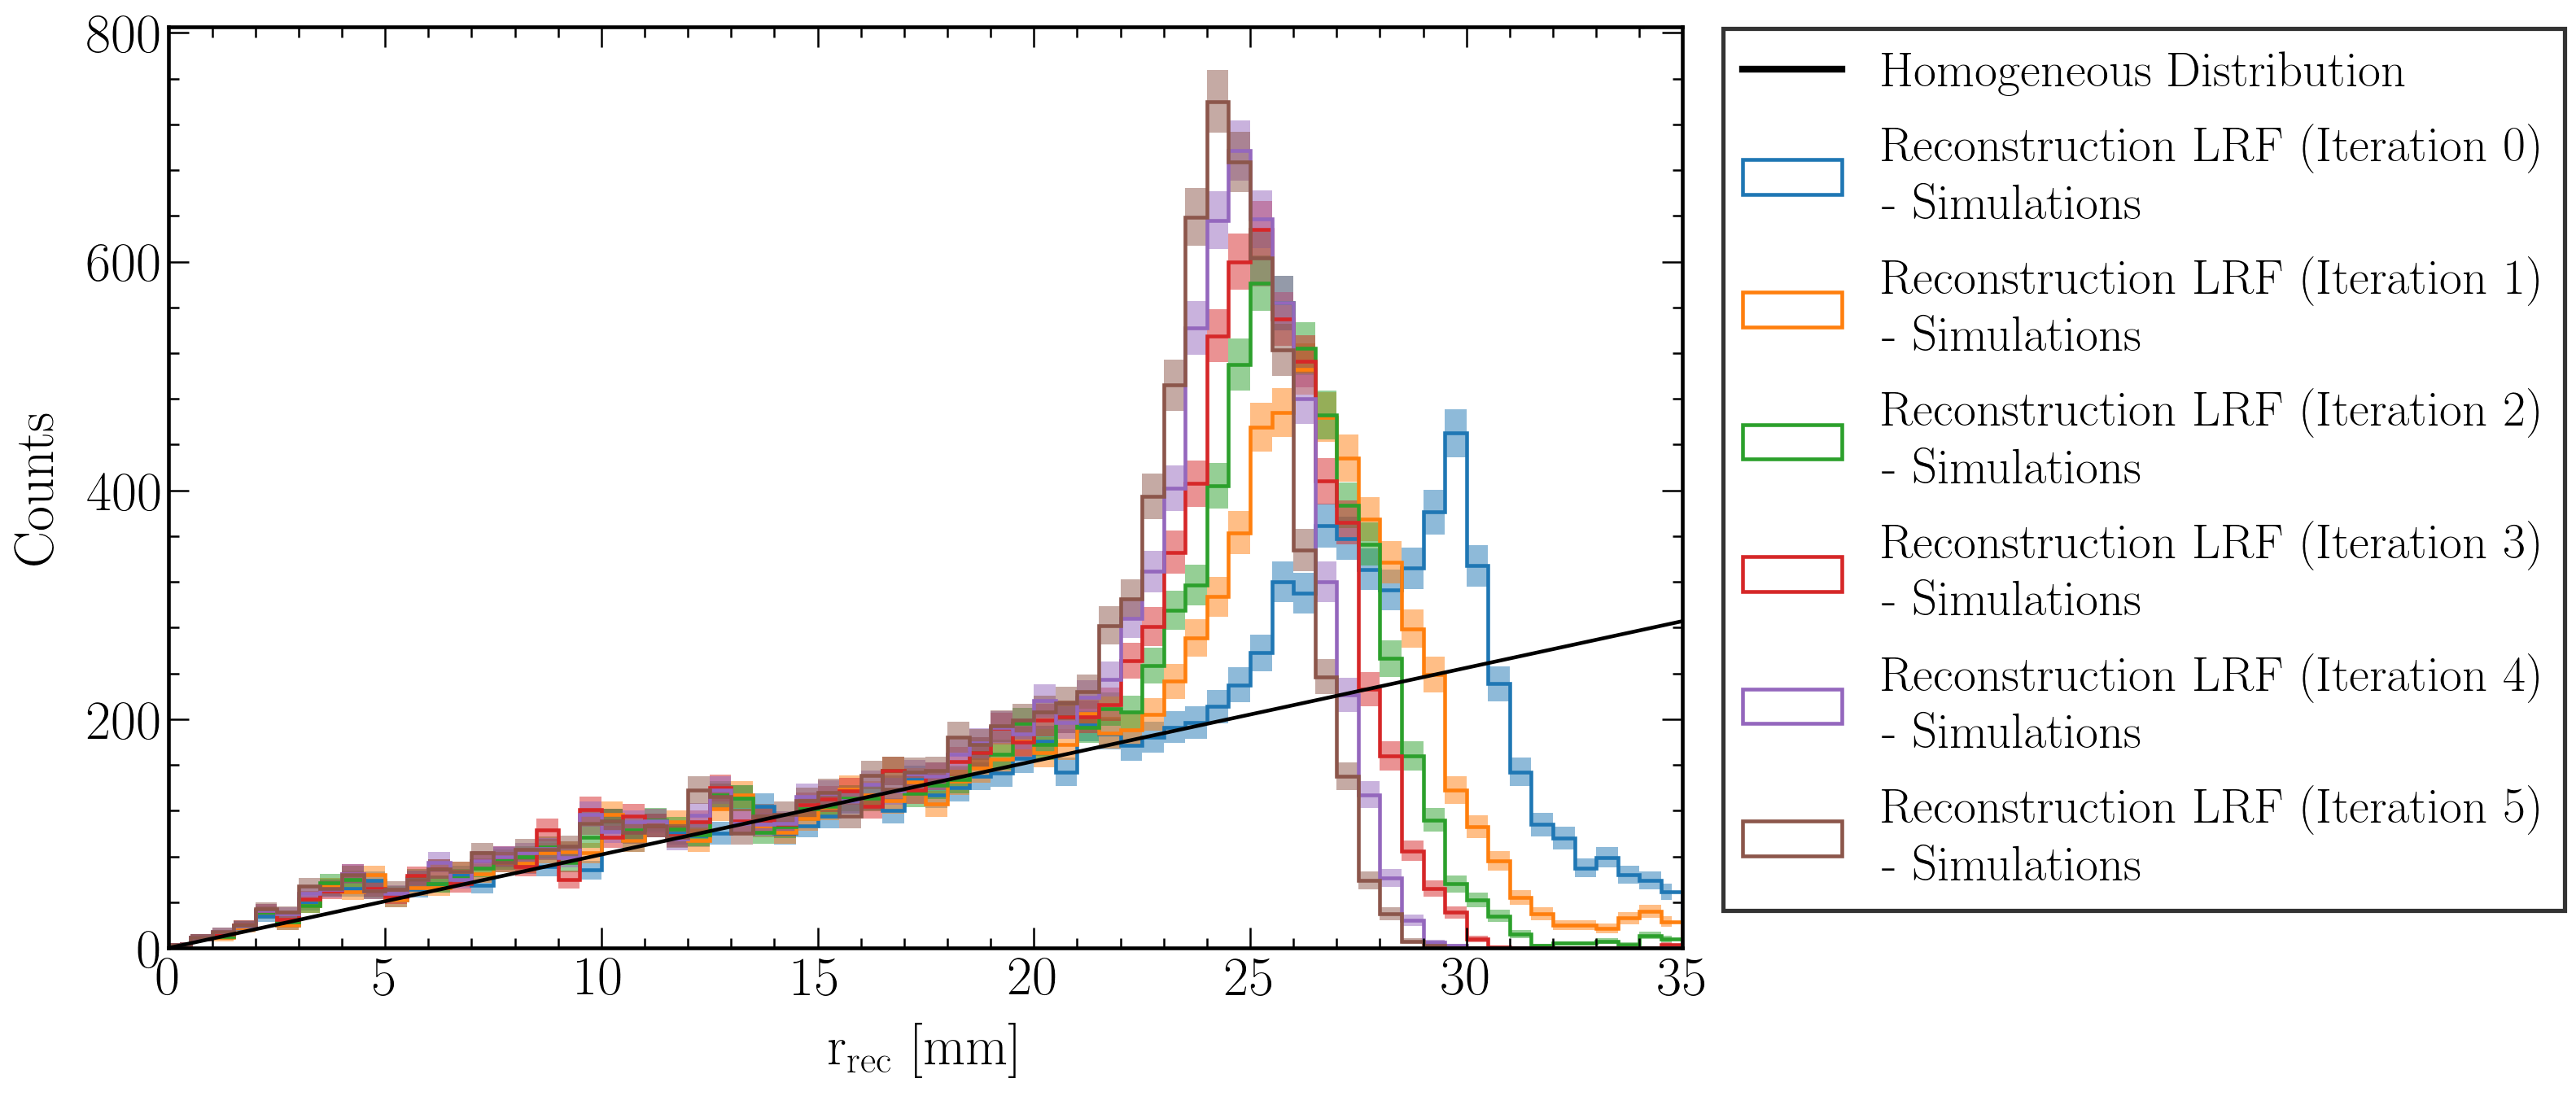

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)

#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

i = 0
cnts = eval('x_pos_LRF_iteration'+str(i)+'_sim').shape[0]

plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
        label = 'Homogeneous Distribution')

for i in range(0,6):
    n, bins, *patches = plt.hist(np.hypot(eval('x_pos_LRF_iteration'+str(i)+'_sim'), 
                                          eval('y_pos_LRF_iteration'+str(i)+'_sim')), 
                                 bins = bns, range = (0,35), density = False,
                                 histtype='step', linewidth = 2.2, color = 'C'+str(i), 
                                 label = 'Reconstruction LRF (Iteration '+str(i)+')\n- Simulations')
    bins_center = (bins[1:] + bins[:-1]) / 2
    plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C'+str(i), 
                     alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filename_LRF+"_predictions_LRF_rspectrum.png", bbox_inches = "tight")
plt.show()

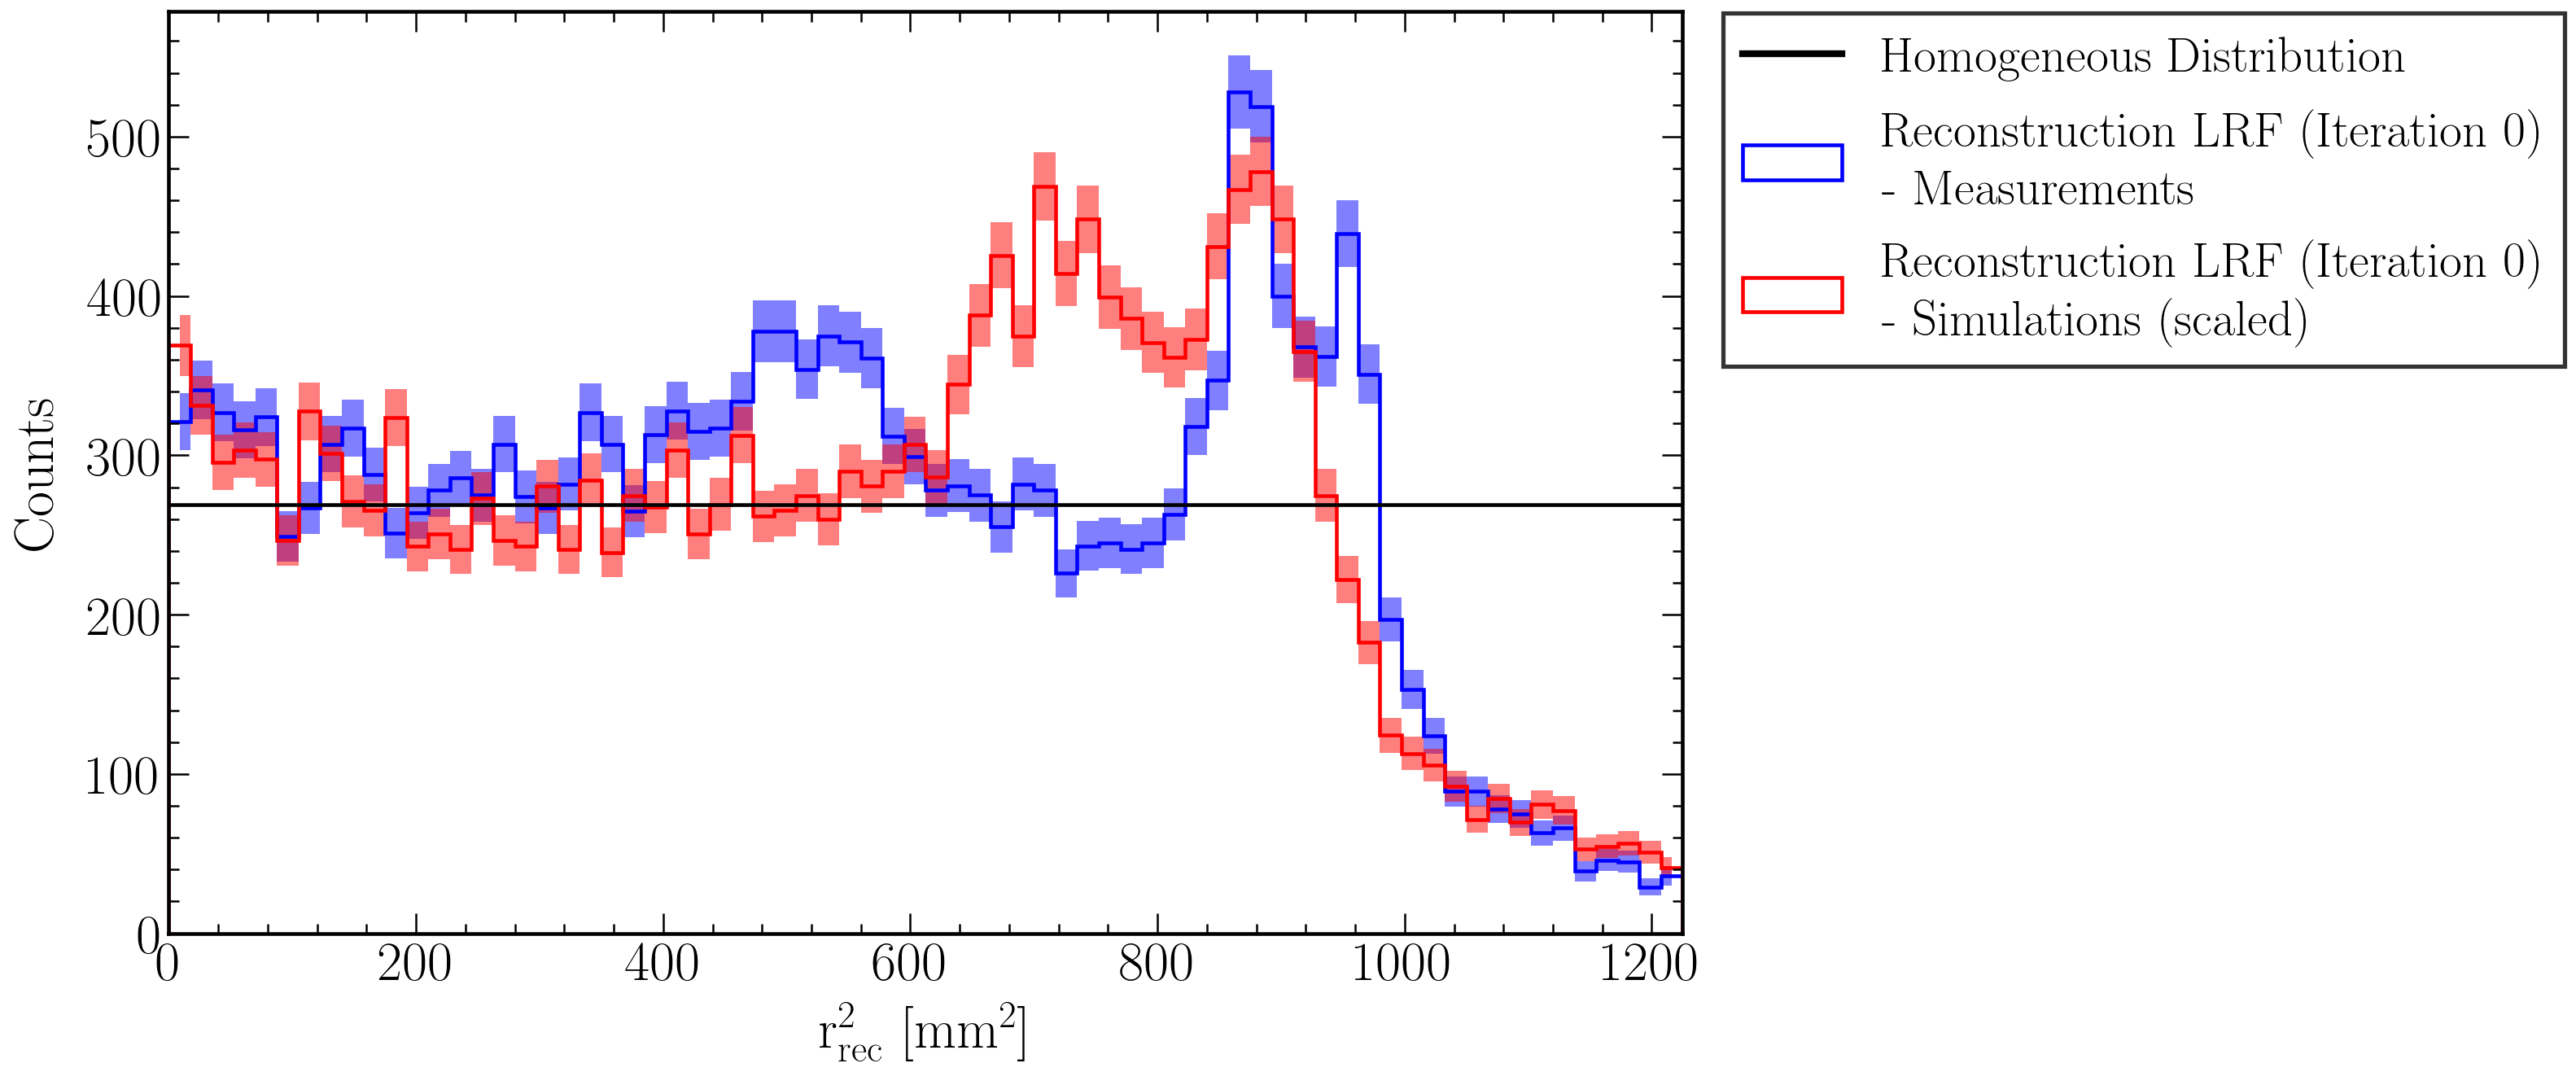

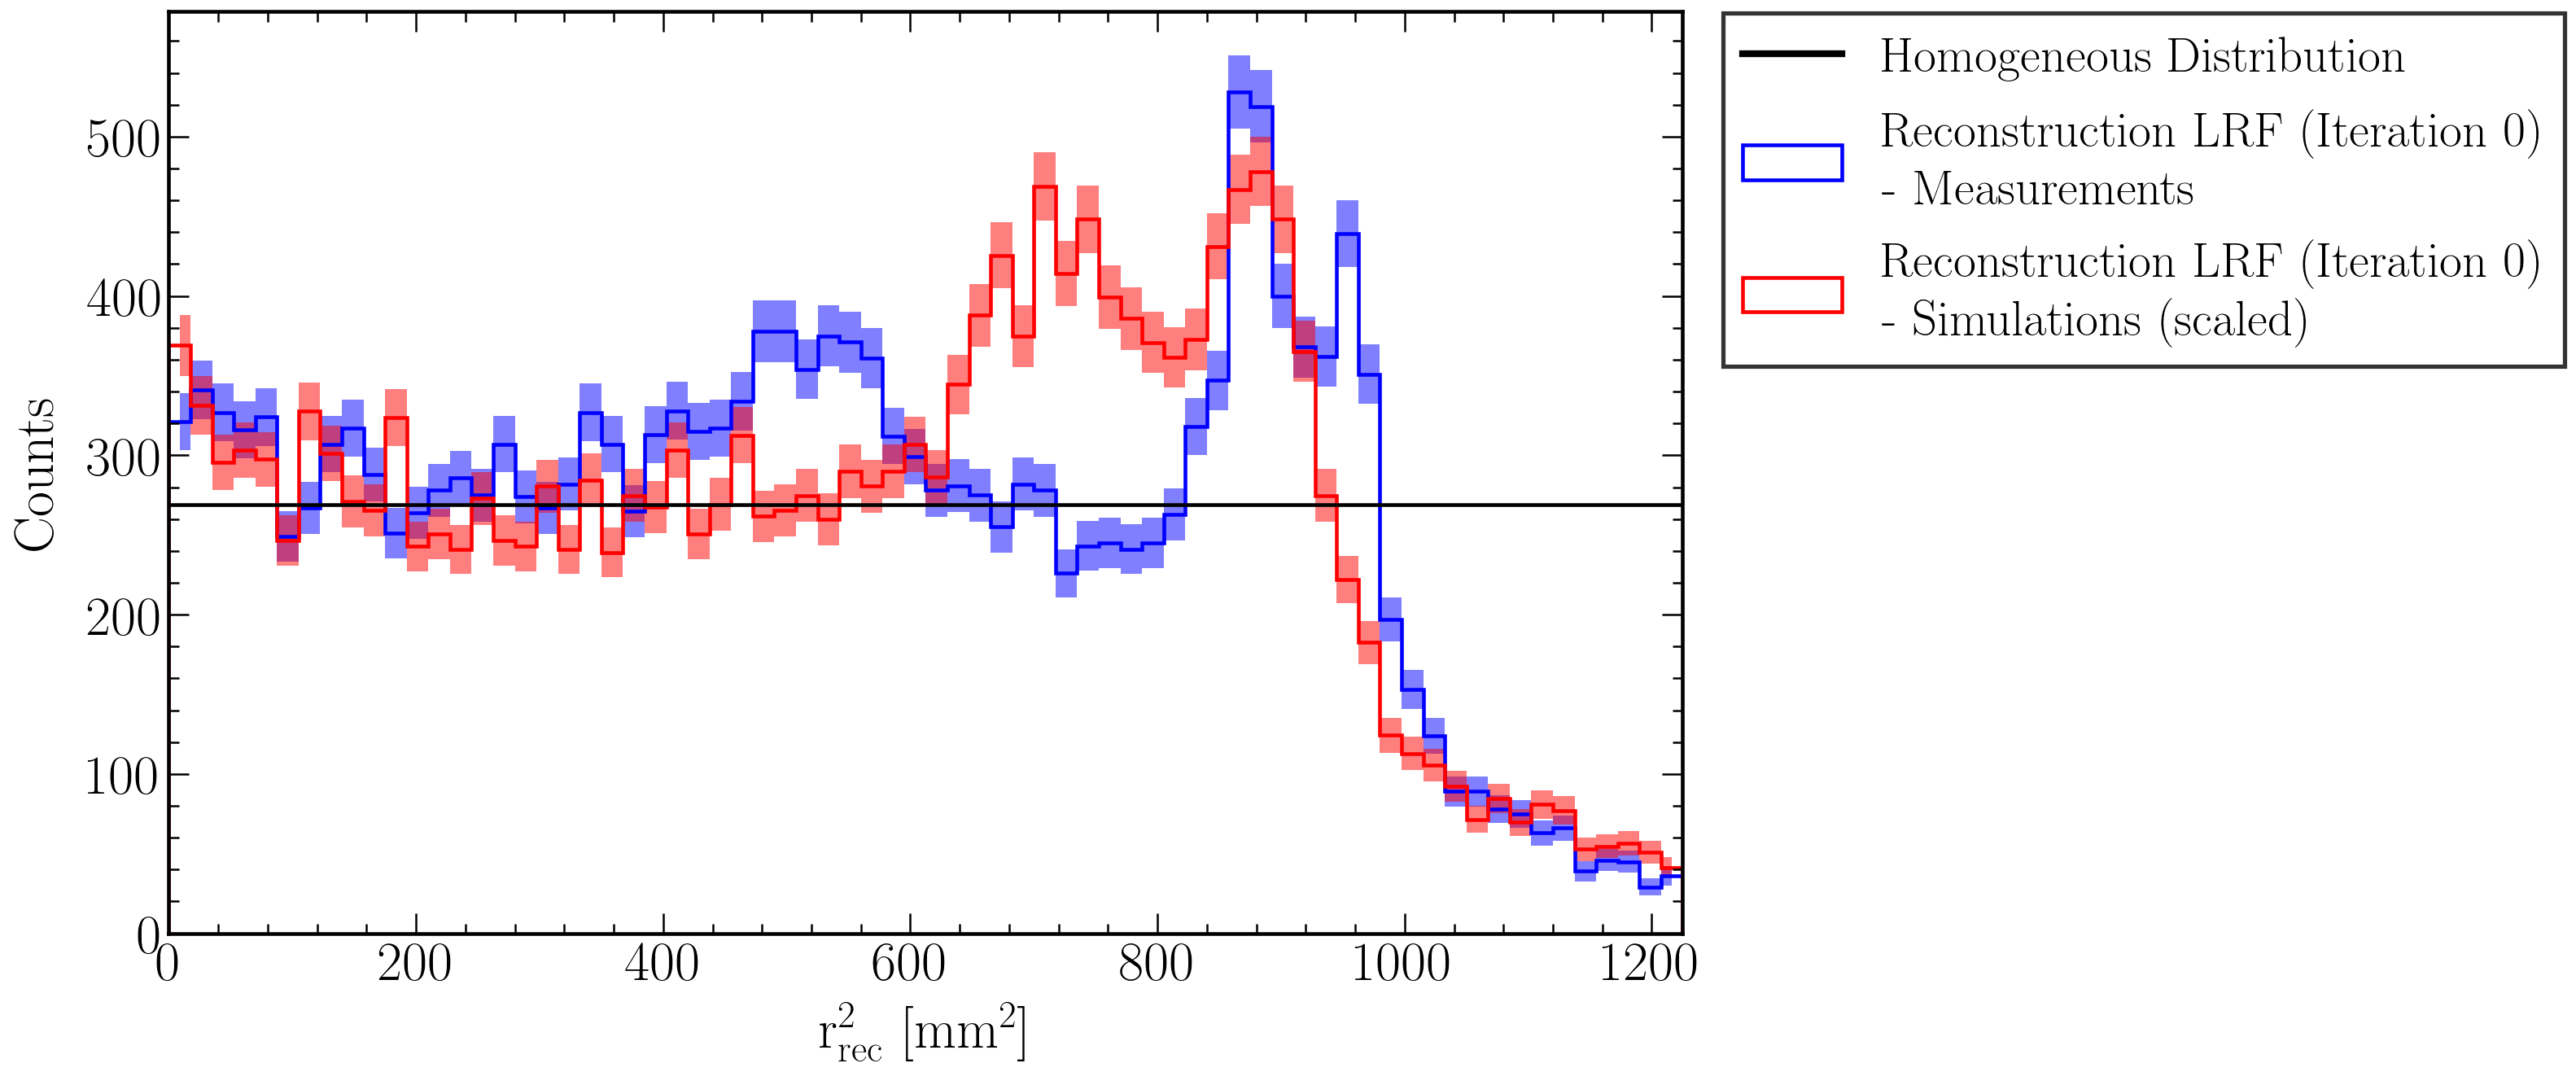

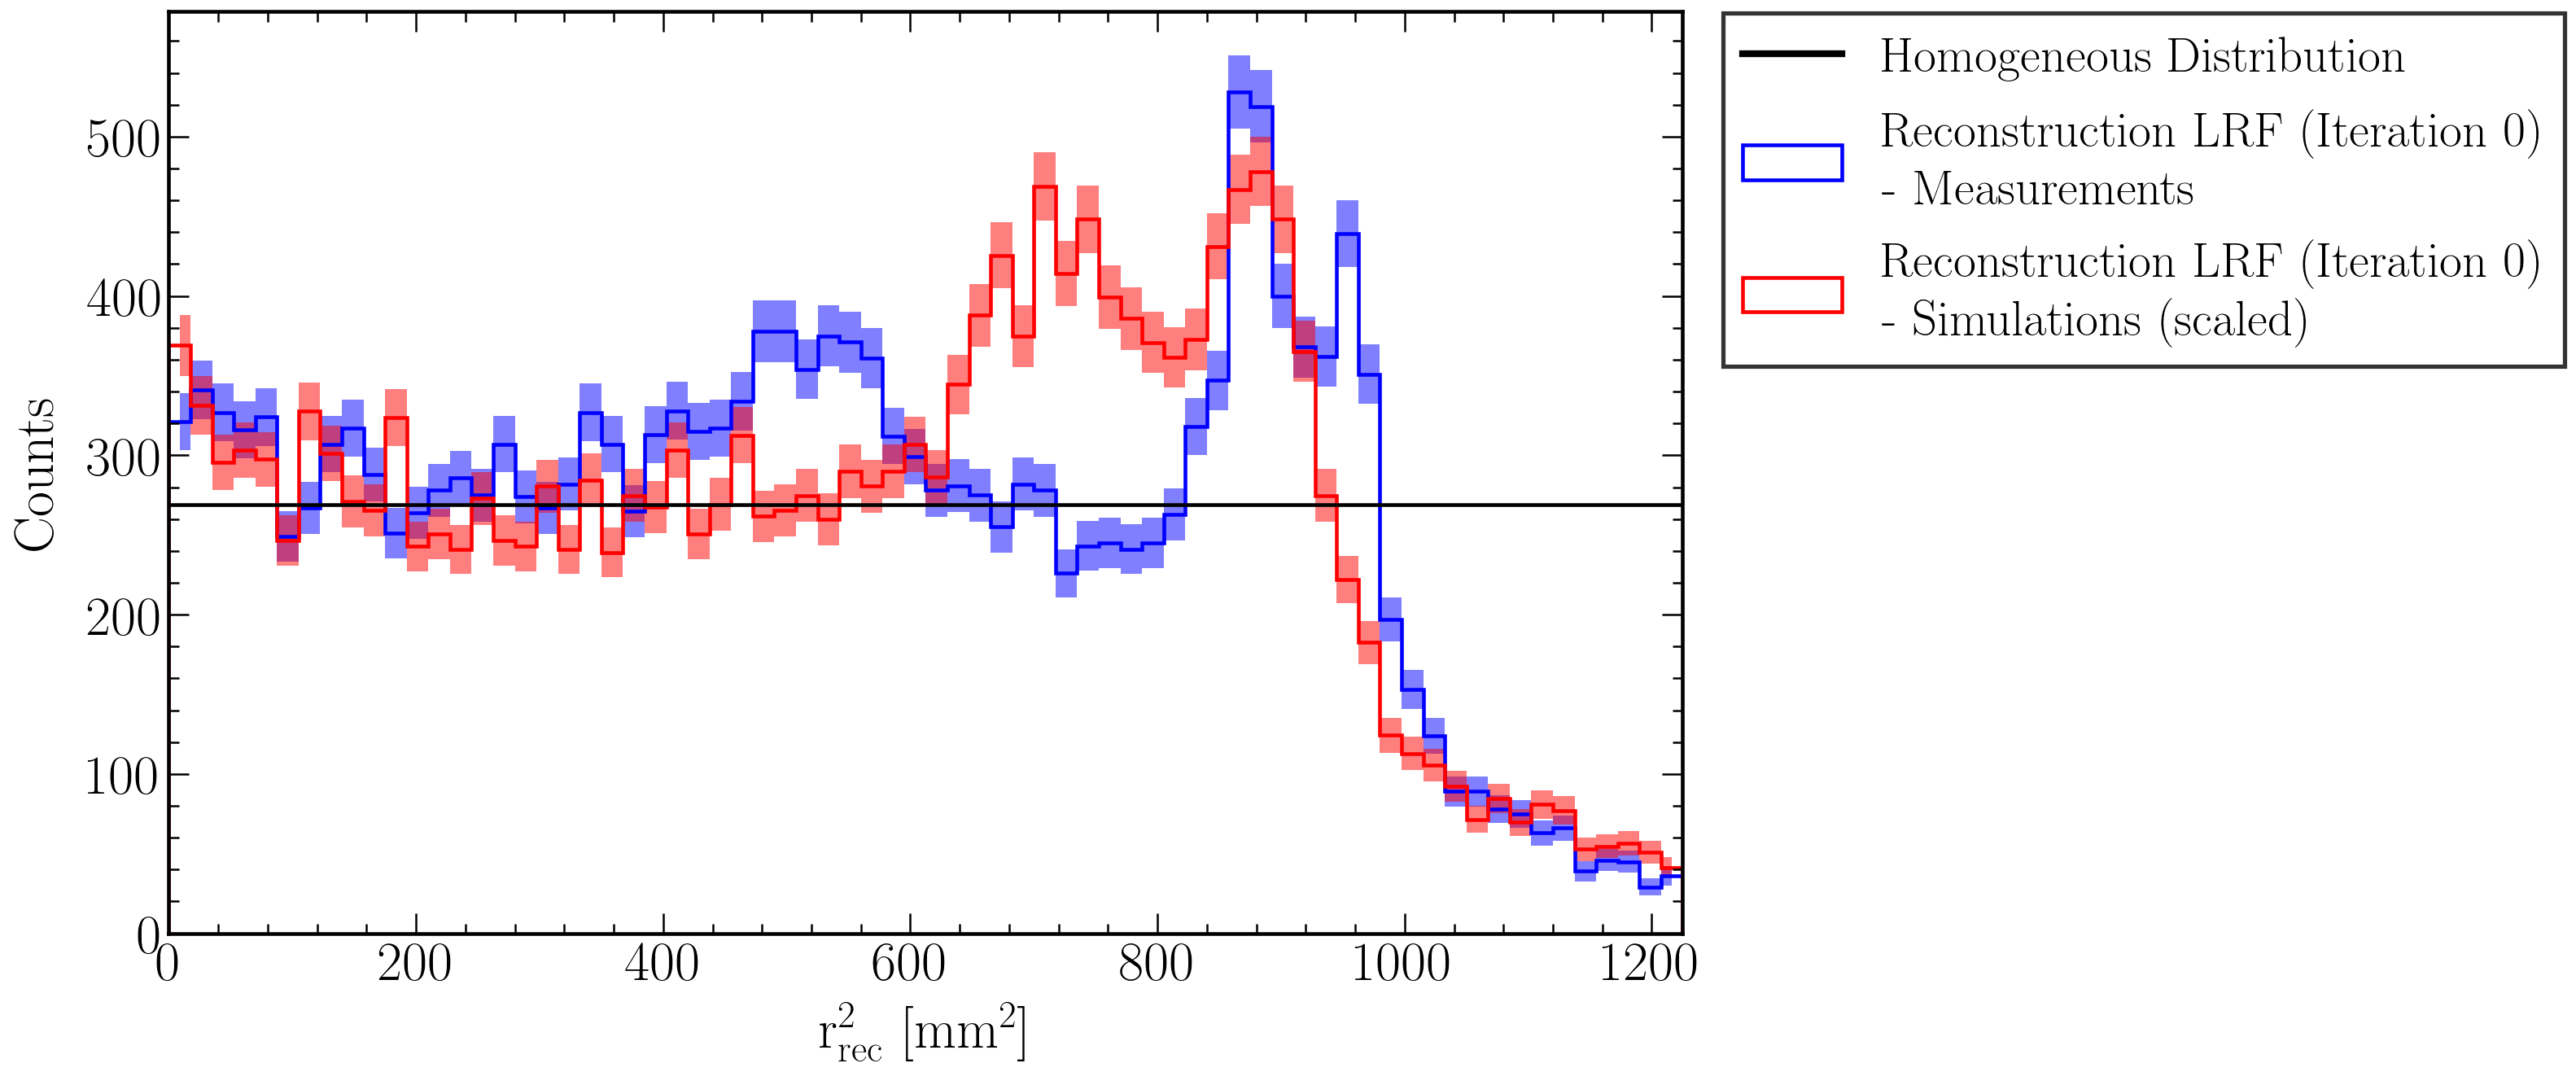

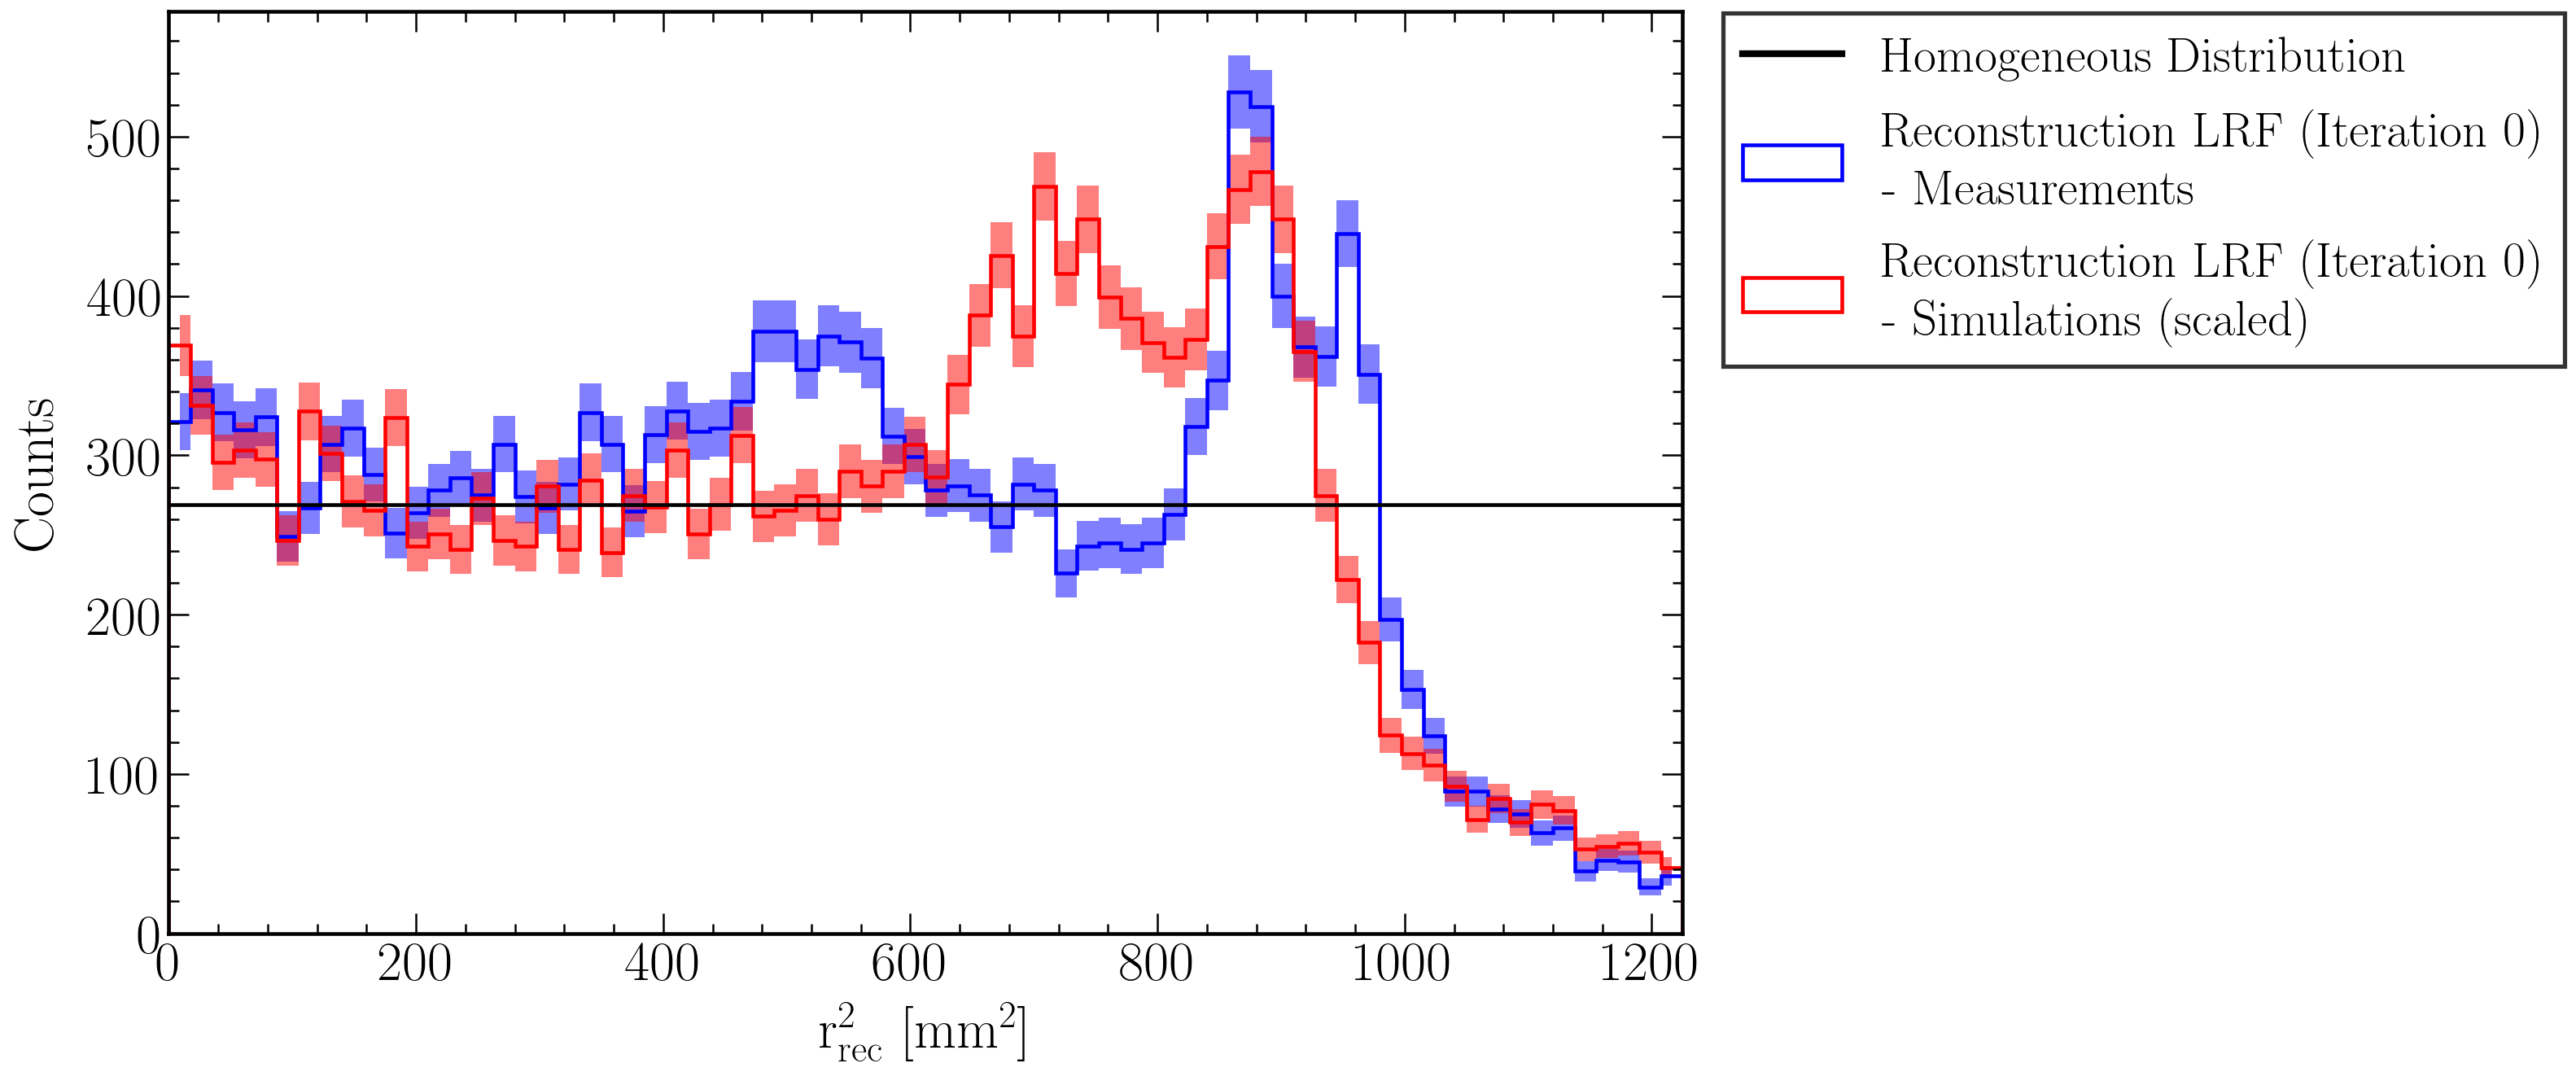

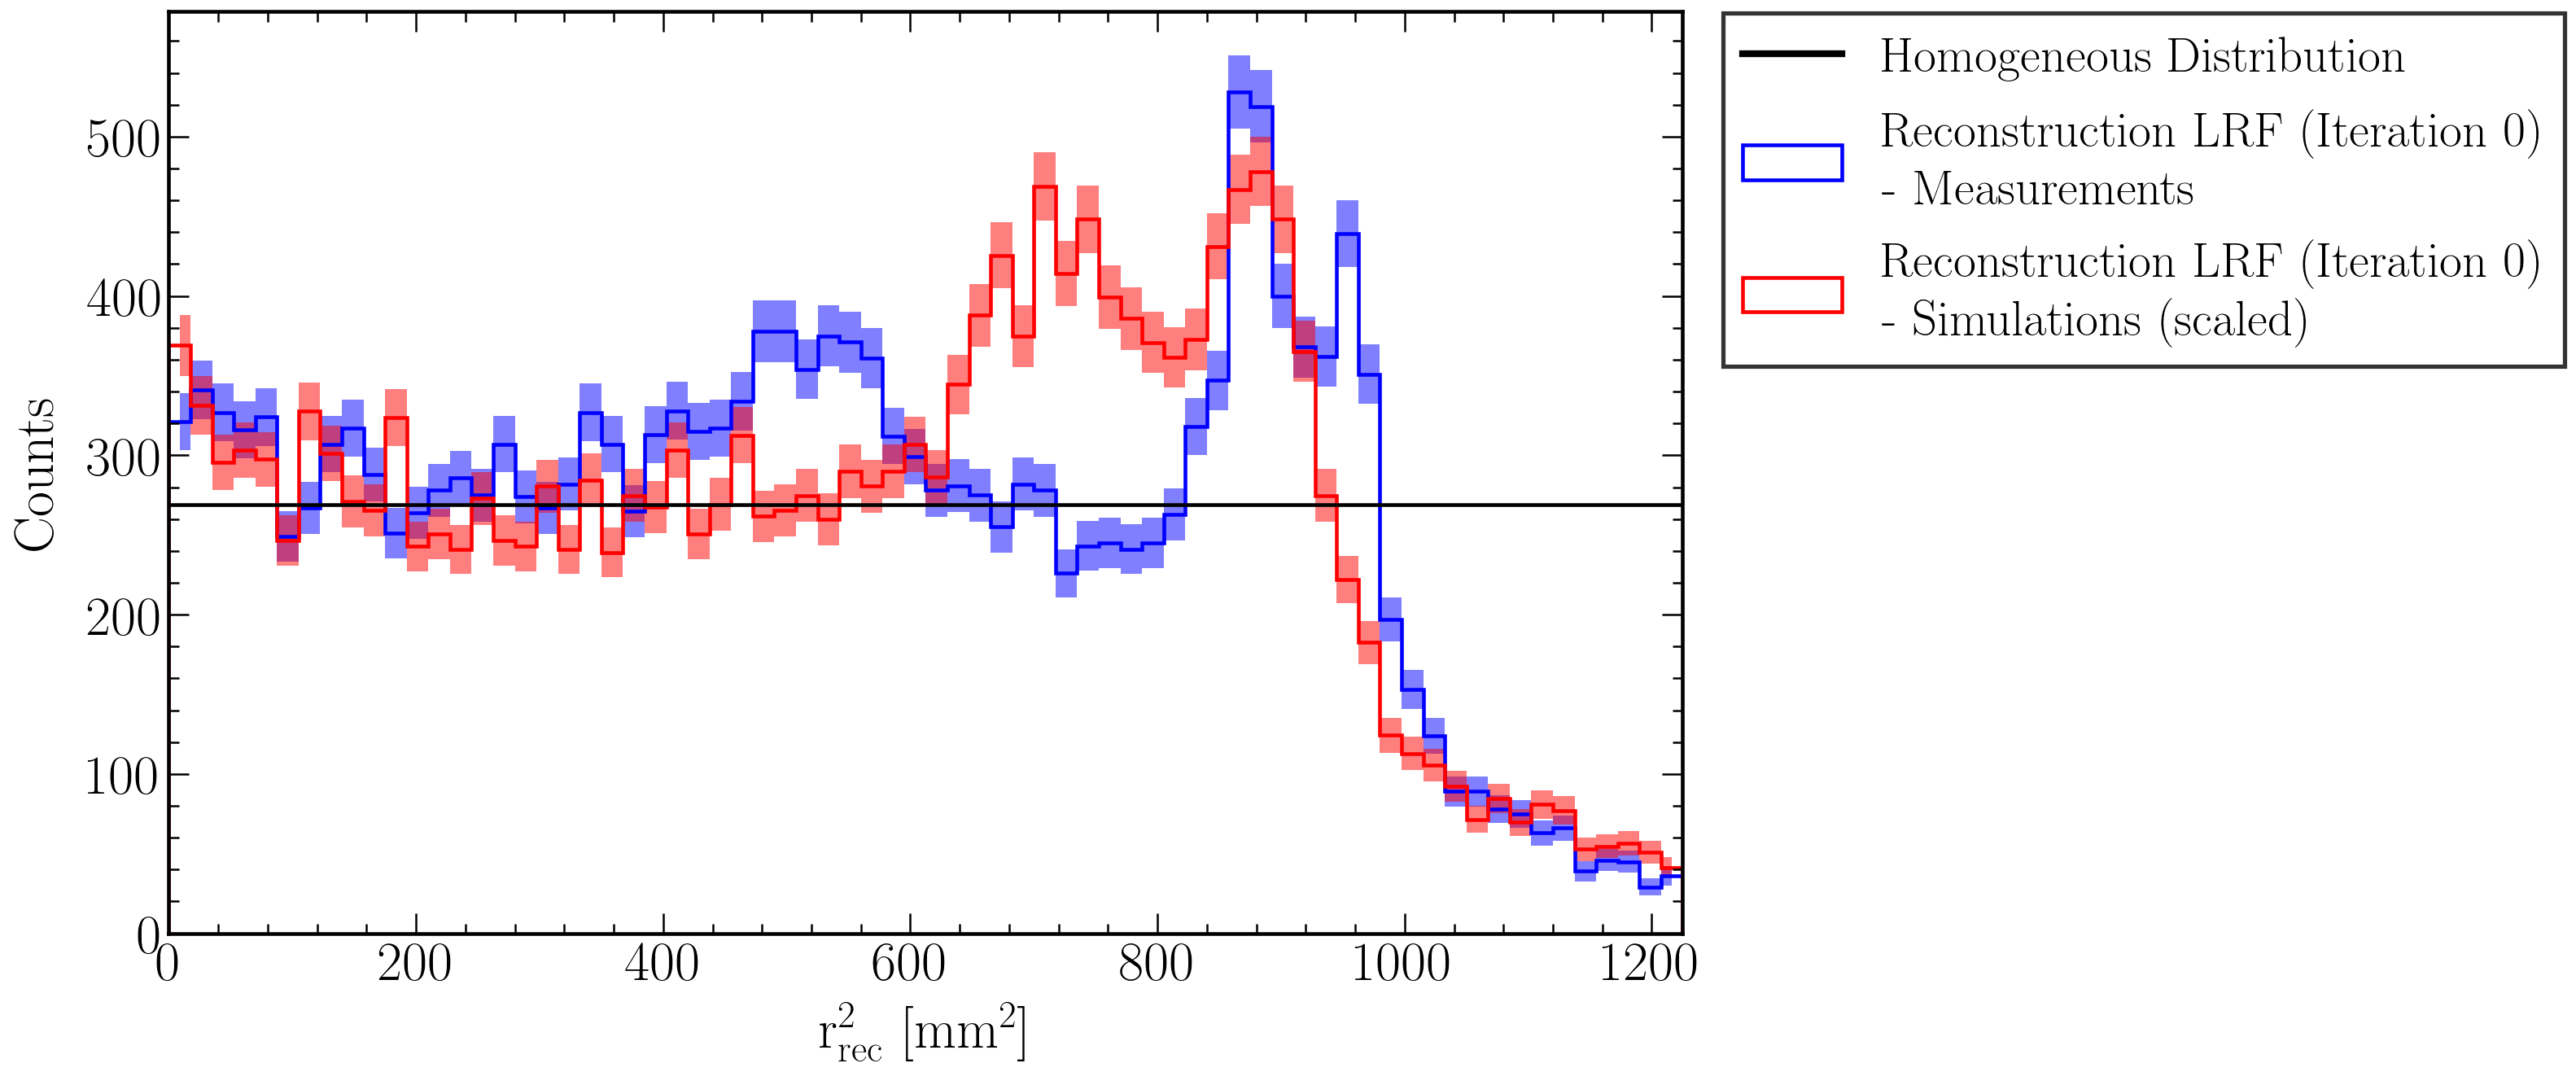

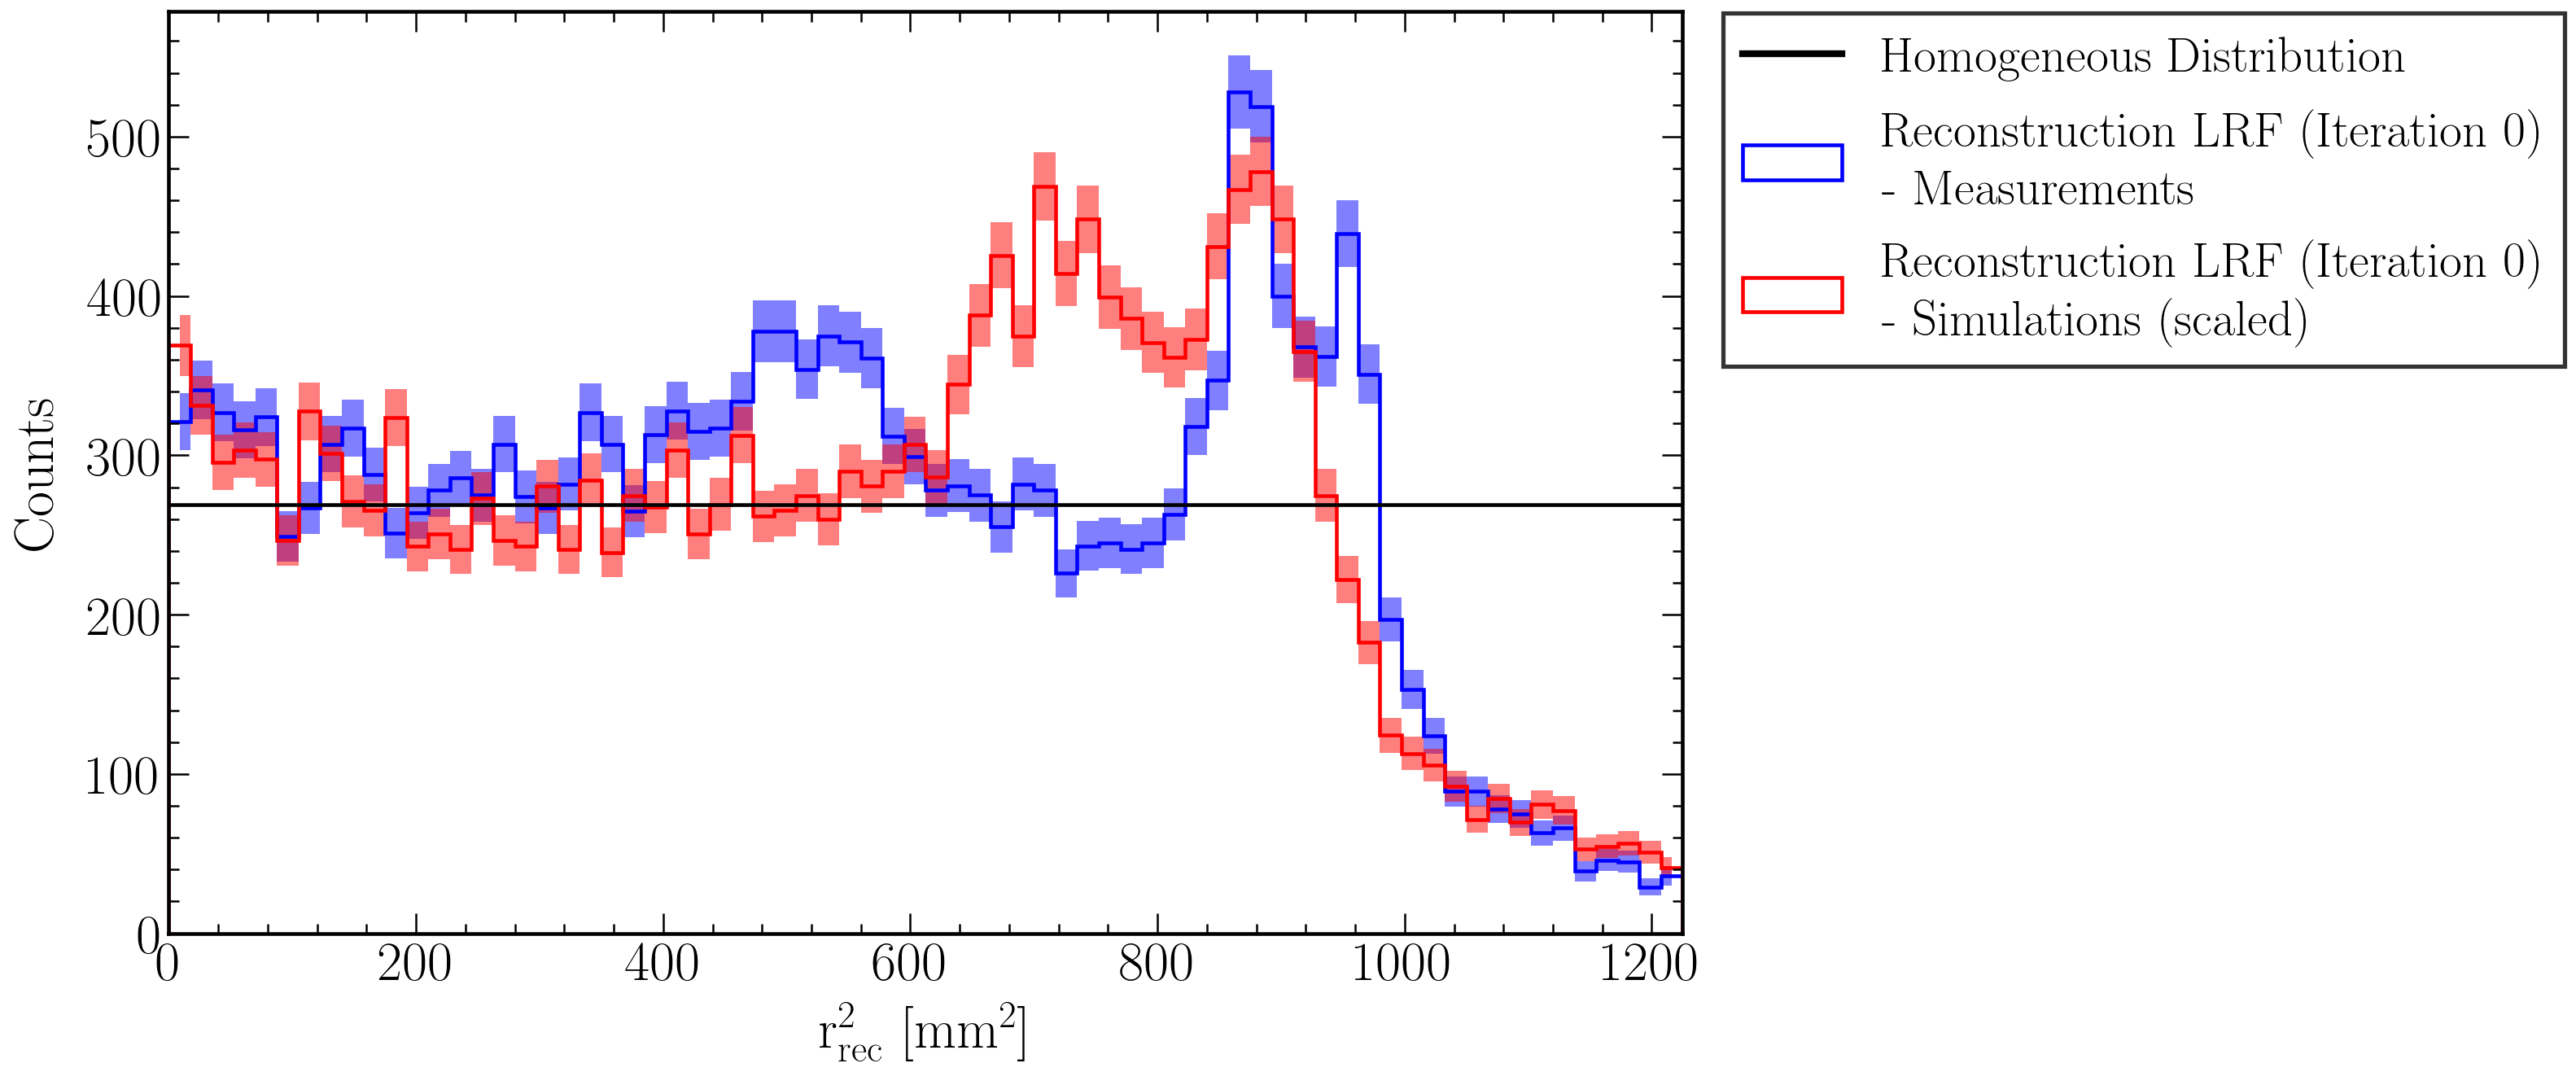

In [24]:
for i in range(0,6):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot
    bns = 70
    
    i = 0
    cnts = eval('x_pos_LRF_iteration'+str(i)).shape[0]

    plt.plot([0, 35**2], [cnts/bns]*2, linewidth = 2.2, color = 'k', 
            label = 'Homogeneous Distribution')

    n, bins, *patches = plt.hist(np.hypot(eval('x_pos_LRF_iteration'+str(i)), eval('y_pos_LRF_iteration'+str(i)))**2, bins = bns, 
             range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
             color = 'blue', label = 'Reconstruction LRF (Iteration '+str(i)+')\n- Measurements')
    bins_center = (bins[1:] + bins[:-1]) / 2
    plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='blue', 
                     alpha=0.5, step = 'mid')

    n, bins, *patches = plt.hist(np.hypot(eval('x_pos_LRF_iteration'+str(i)+'_sim'), 
                                          eval('y_pos_LRF_iteration'+str(i)+'_sim'))**2, 
                                 bins = bns, range = (0,35**2), density = False,
                                 weights = [eval('x_pos_LRF_iteration'+str(i)).shape[0] / eval('x_pos_LRF_iteration'+str(i)+'_sim').shape[0]]*eval('x_pos_LRF_iteration'+str(i)+'_sim').shape[0],
                                 histtype='step', linewidth = 2.2, color = 'red', 
                                 label = 'Reconstruction LRF (Iteration '+str(i)+')\n- Simulations (scaled)')
    bins_center = (bins[1:] + bins[:-1]) / 2
    plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='red', 
                     alpha=0.5, step = 'mid')

    plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

    plt.xlim(0, 35**2)
    plt.ylim(bottom = 0)

    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    #leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig(filenameprefix+"_predictions_LRF_iteration_"+str(i)+"_r2spectrum_vs_simulations.png", bbox_inches = "tight")
    plt.show()

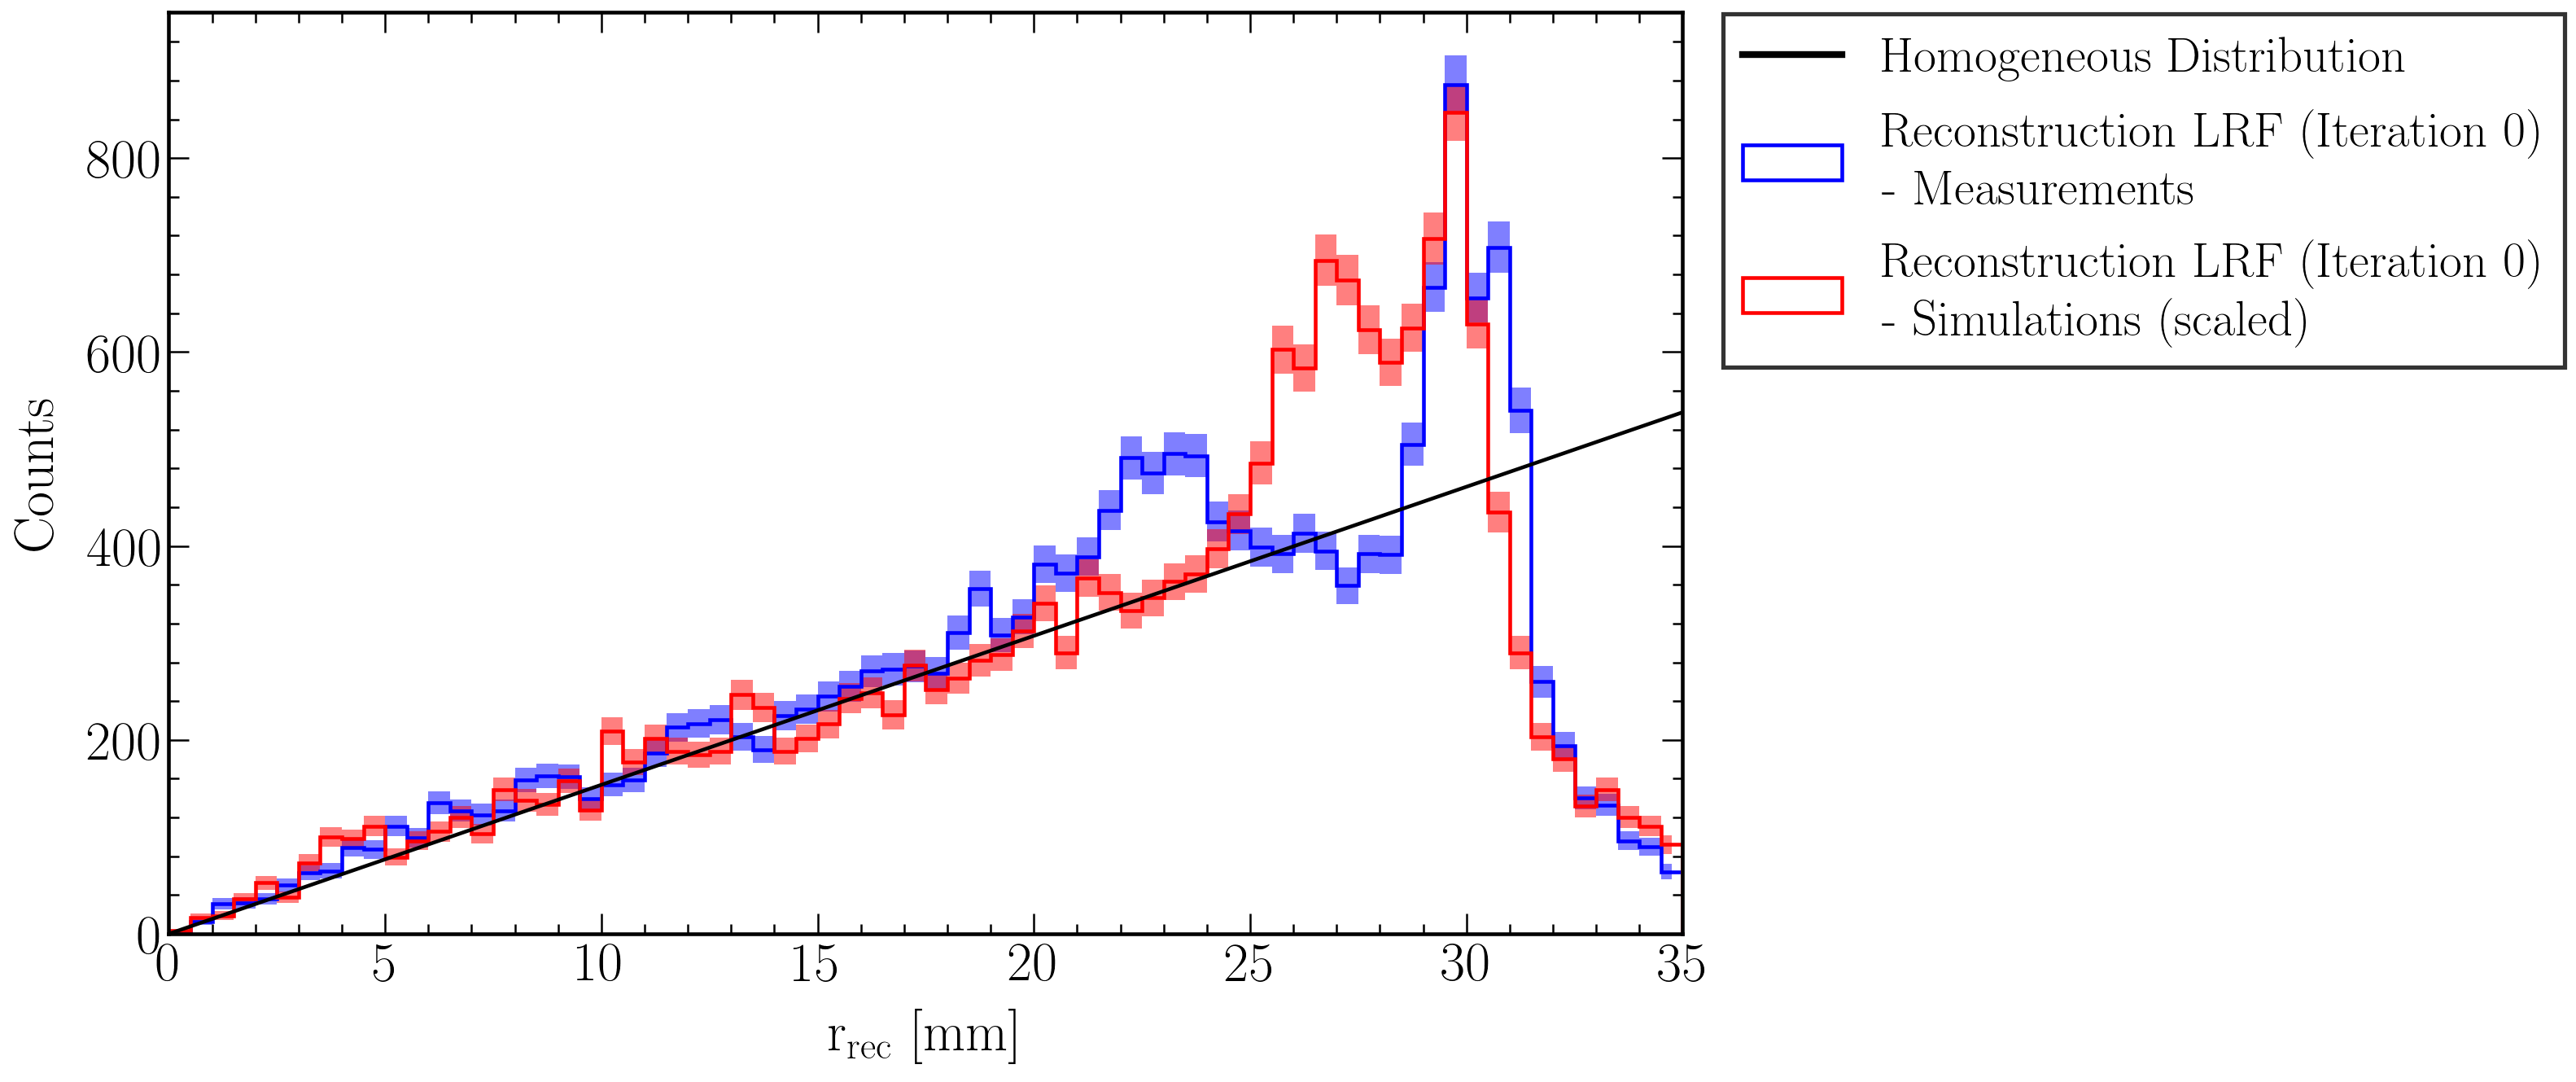

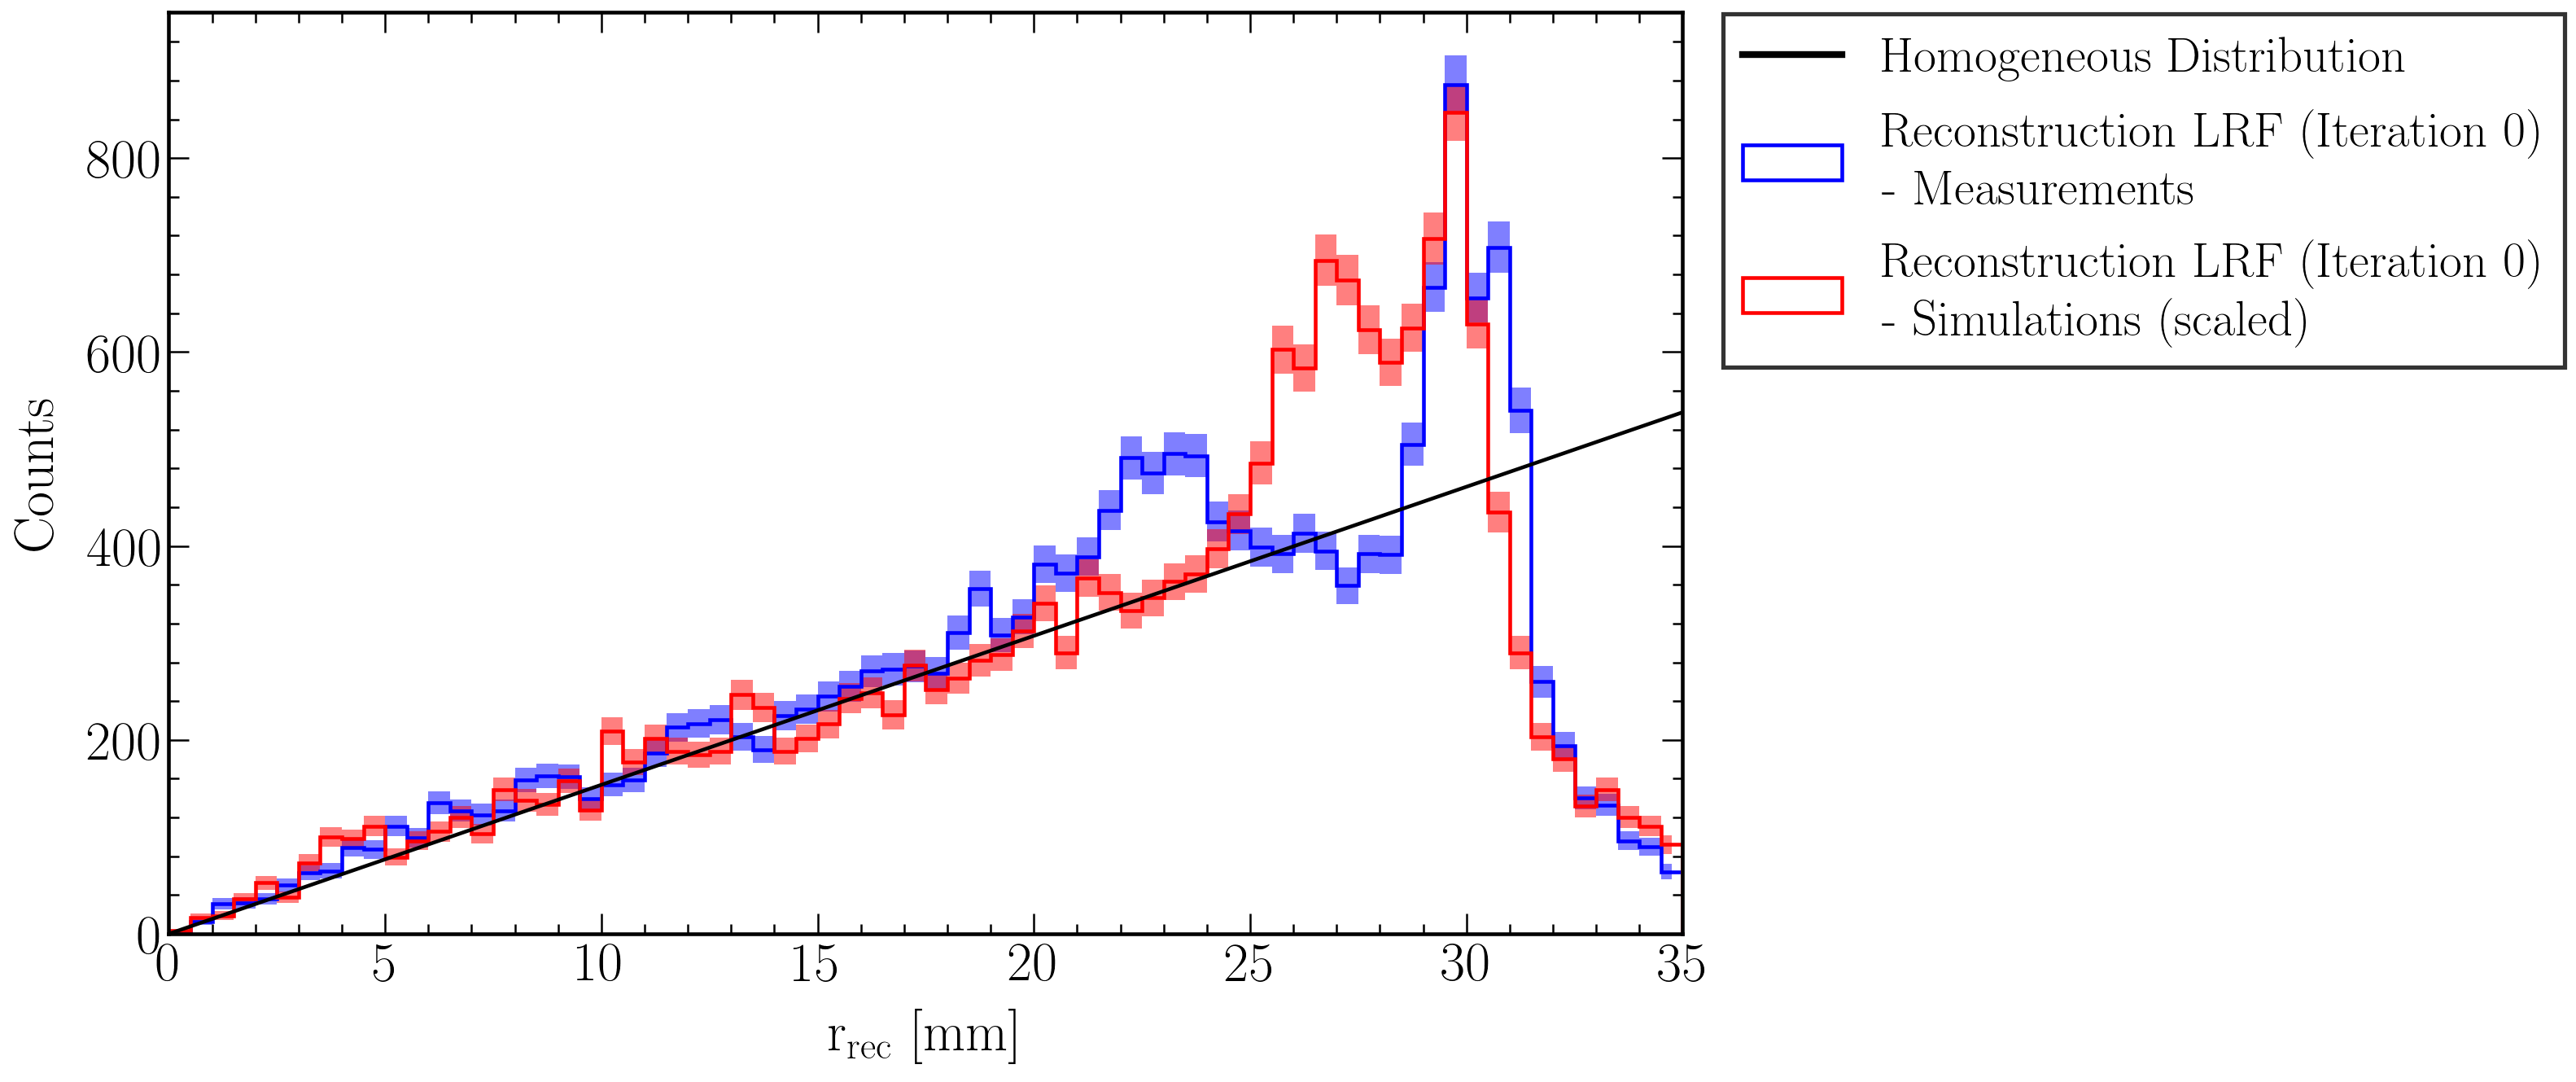

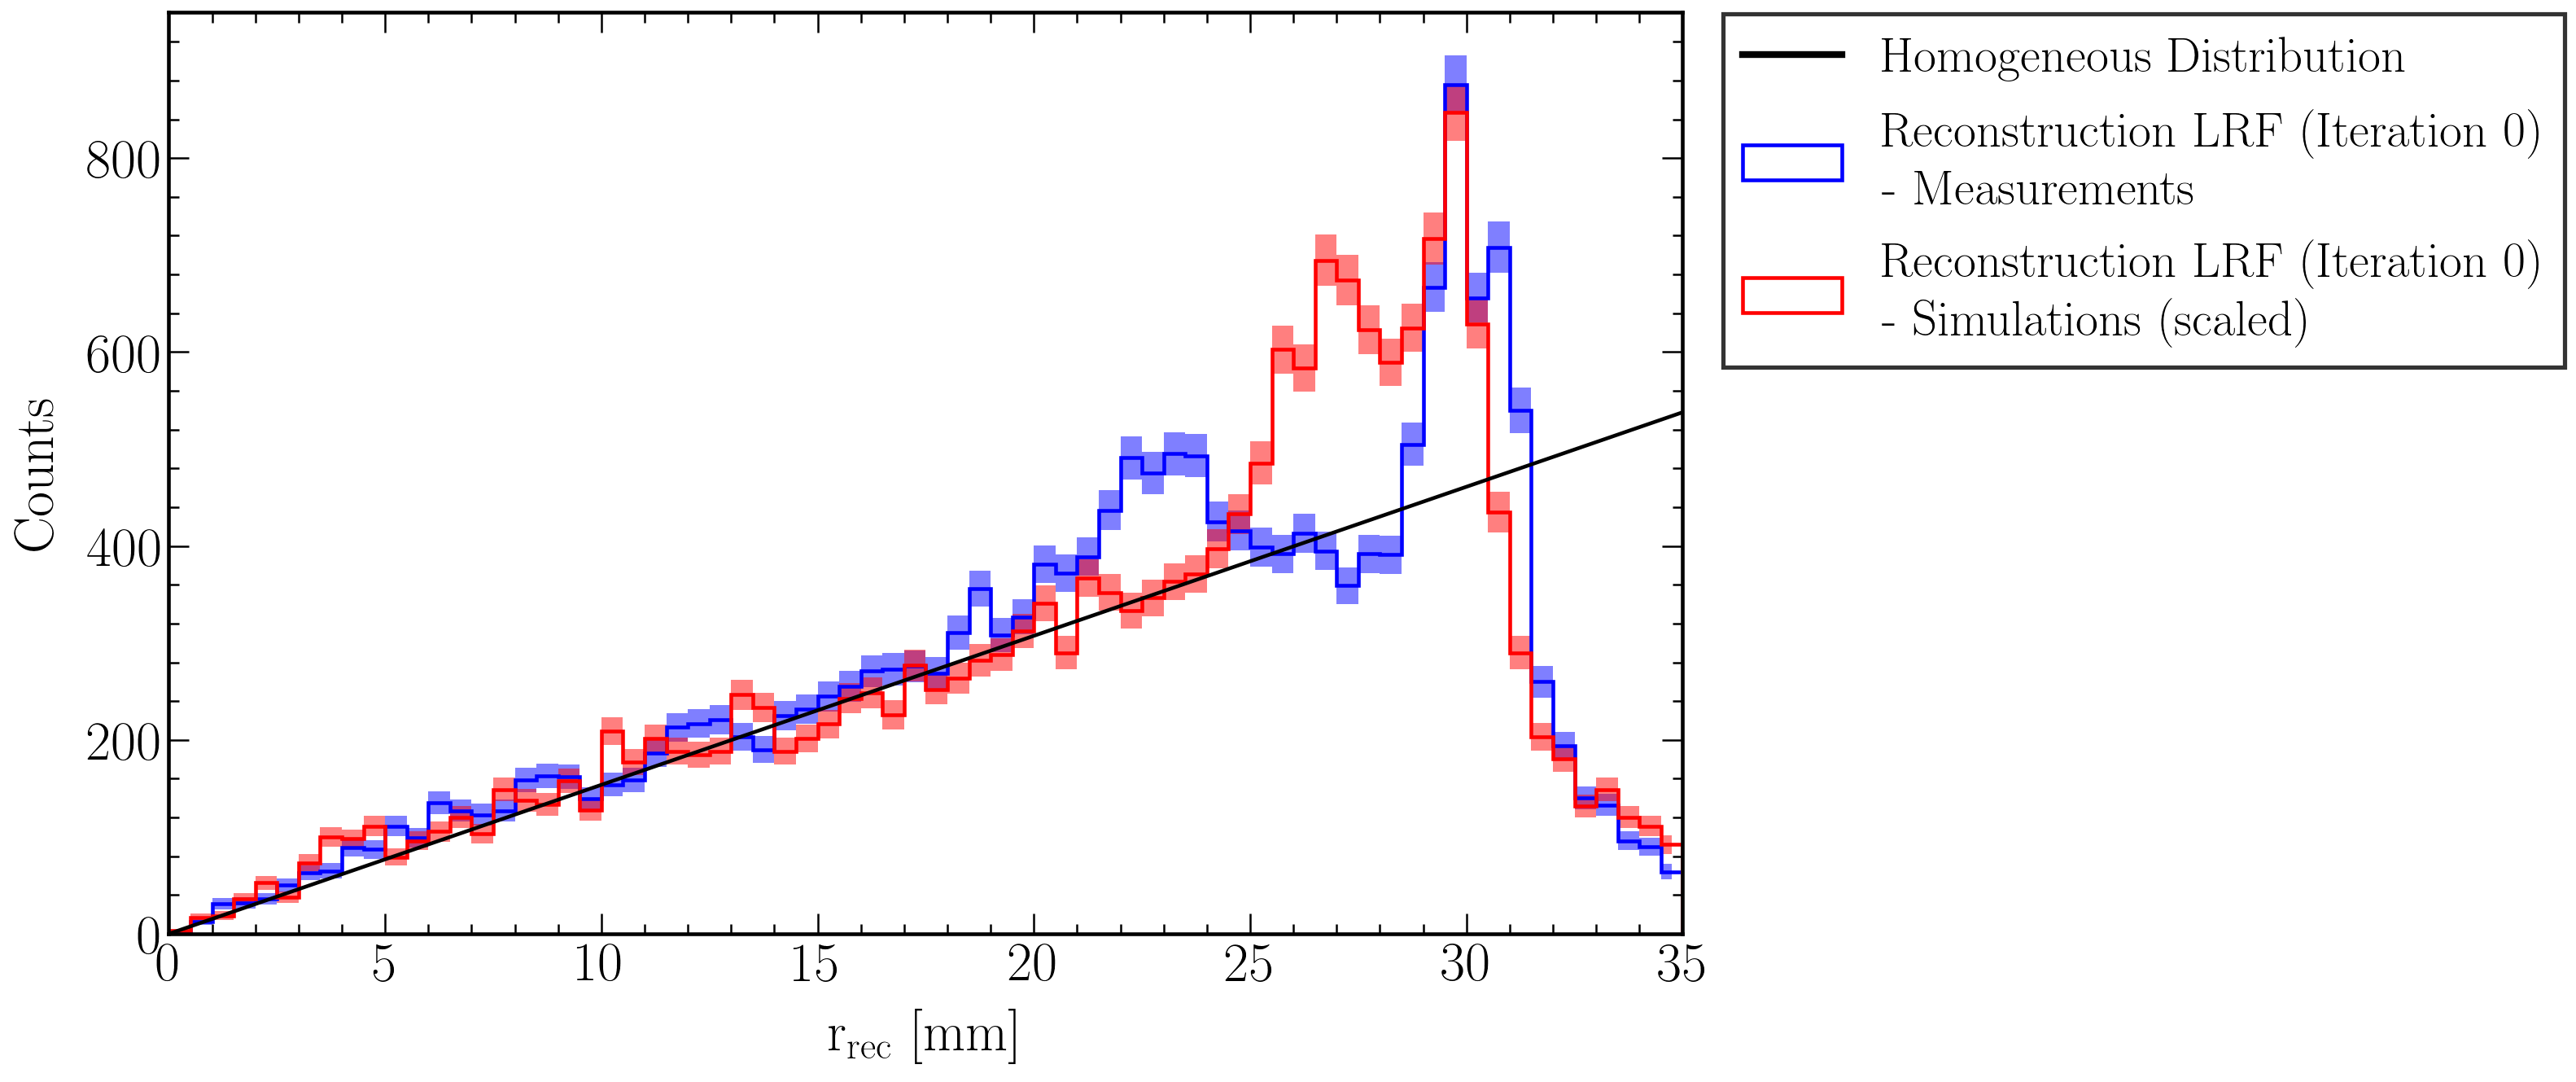

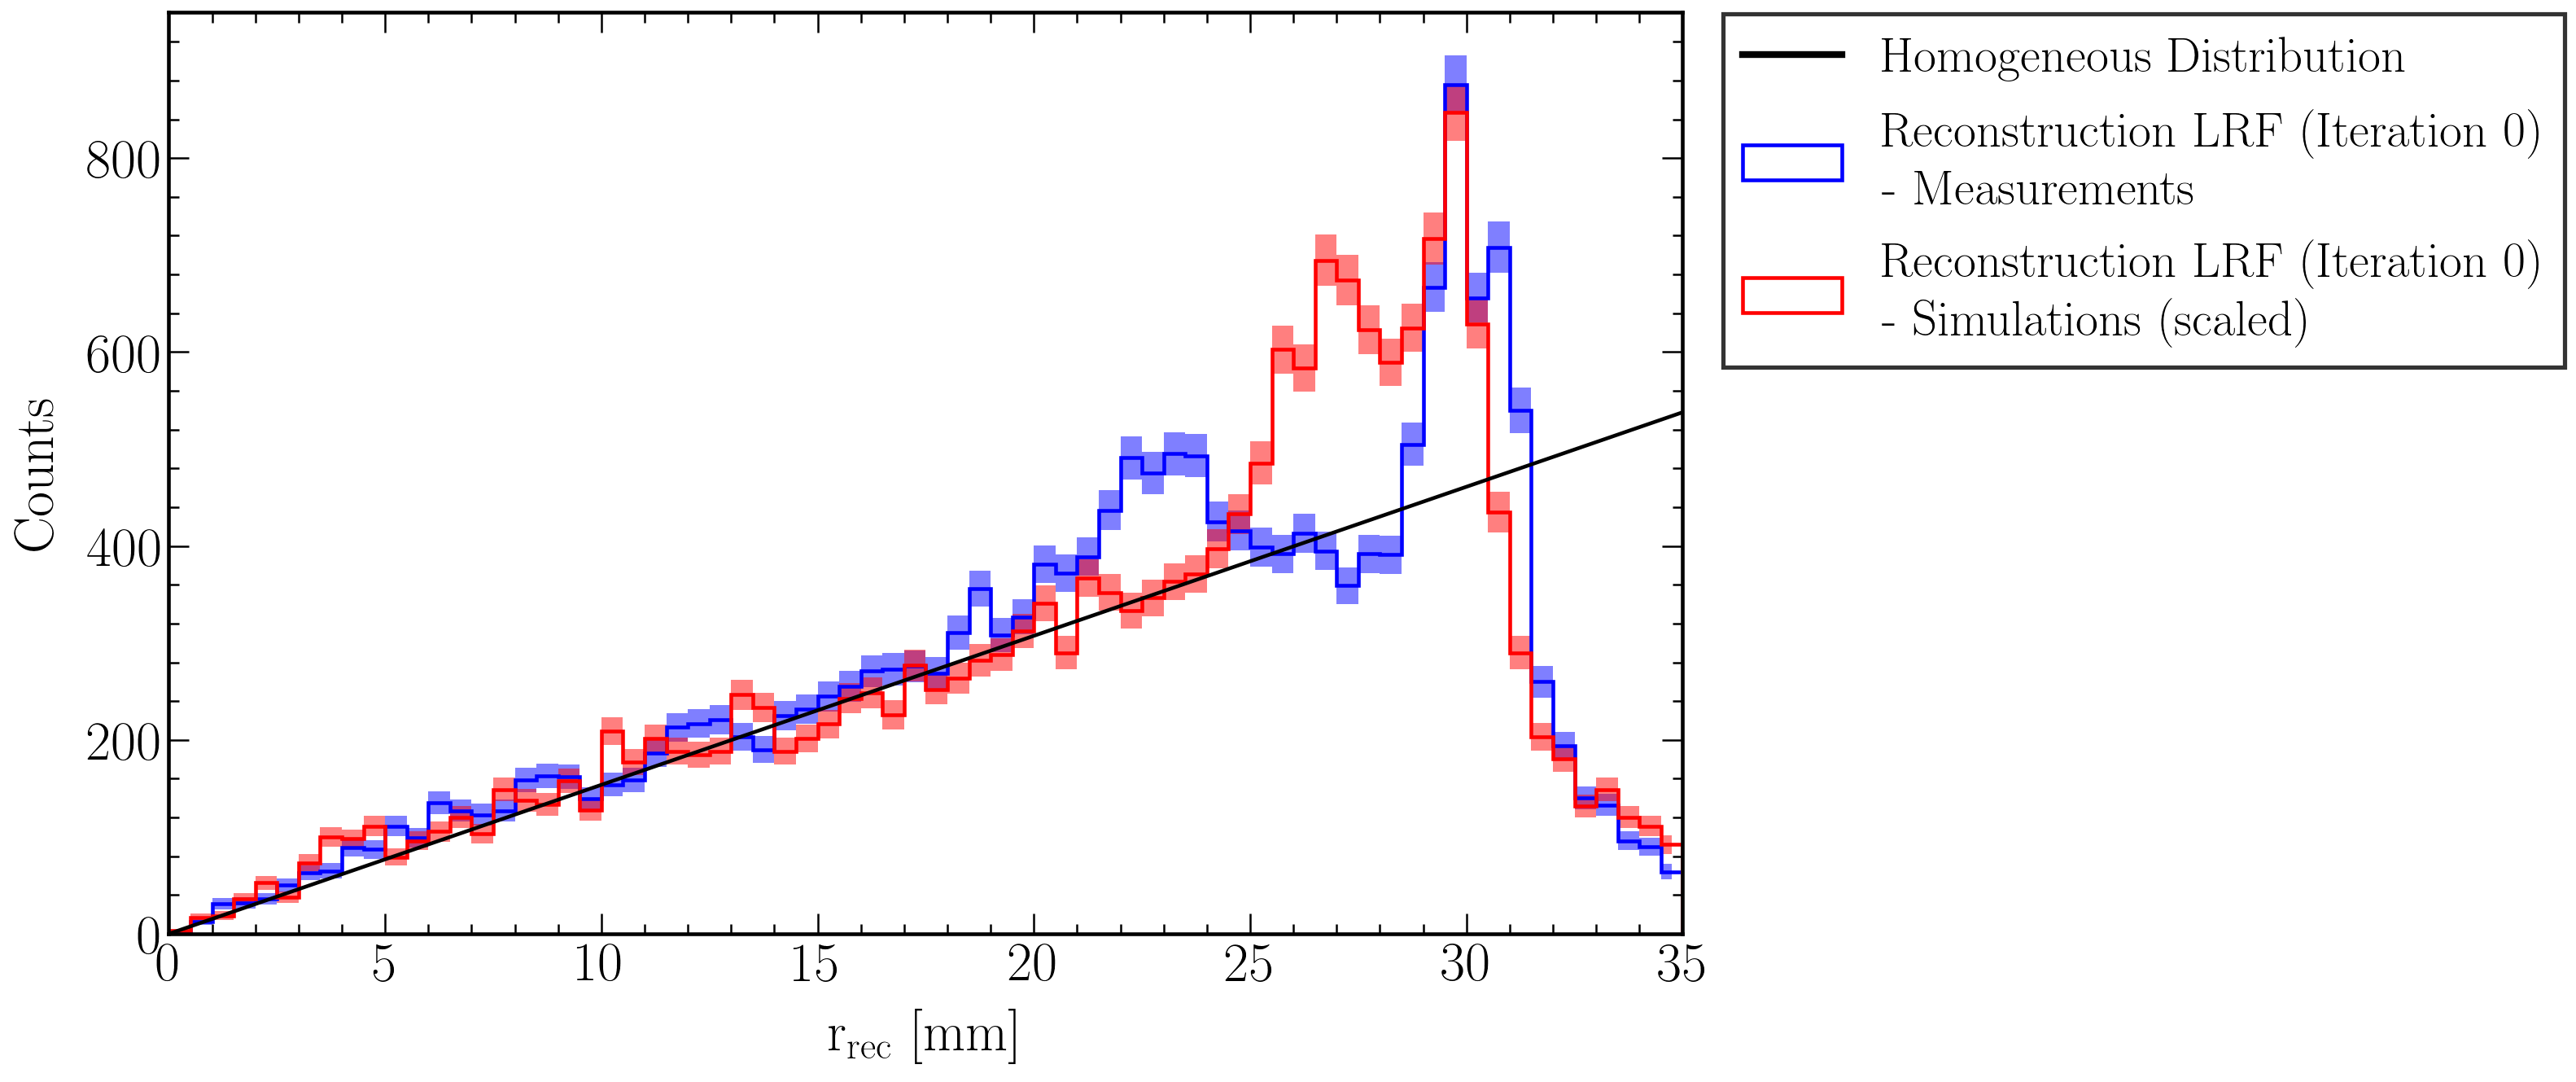

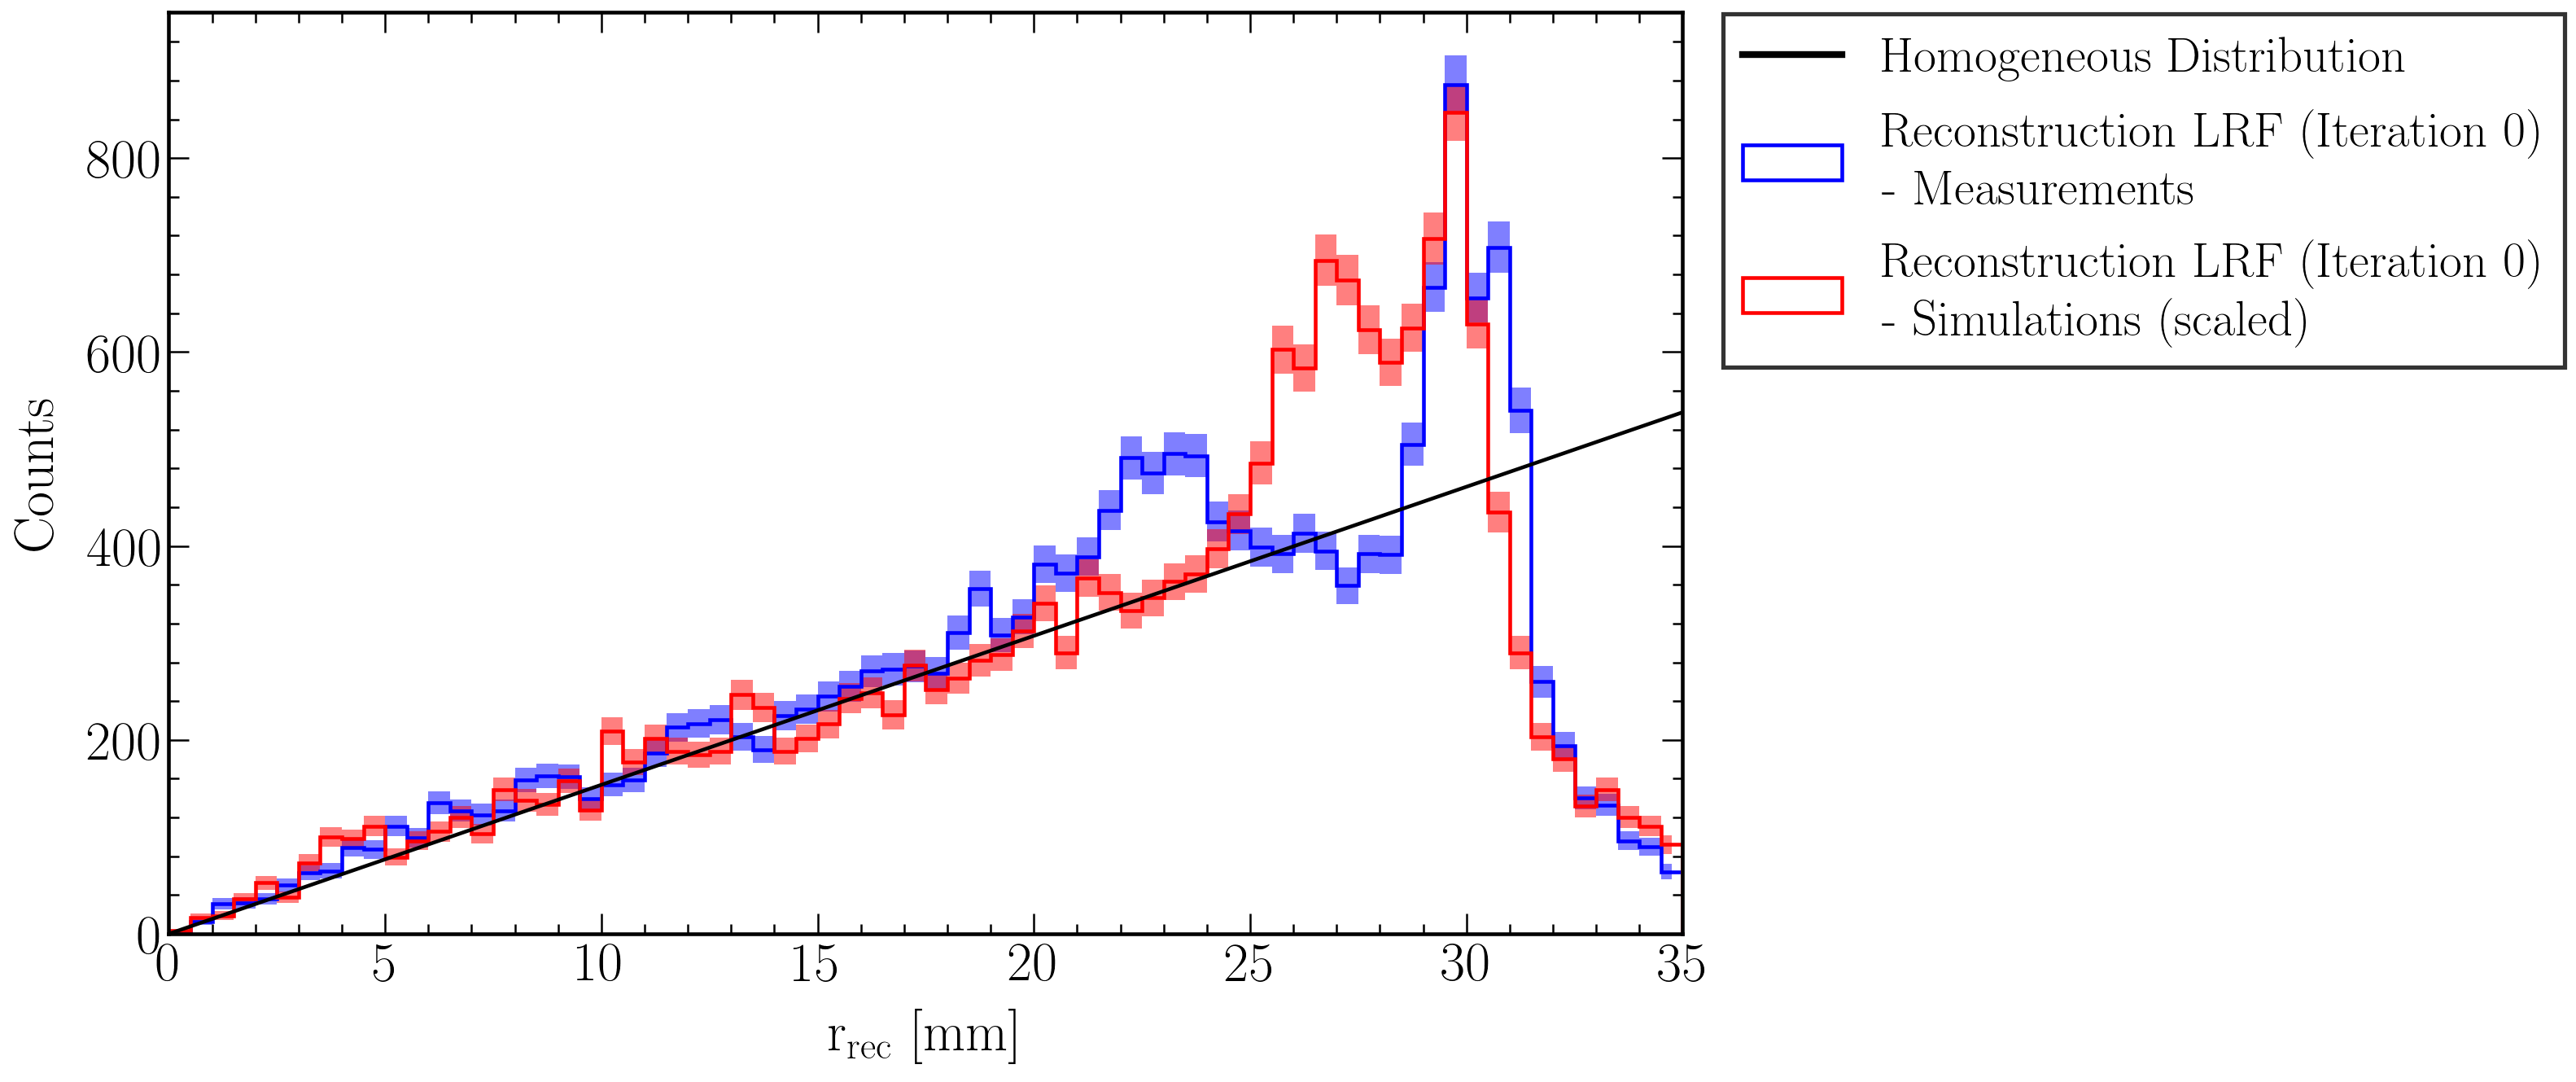

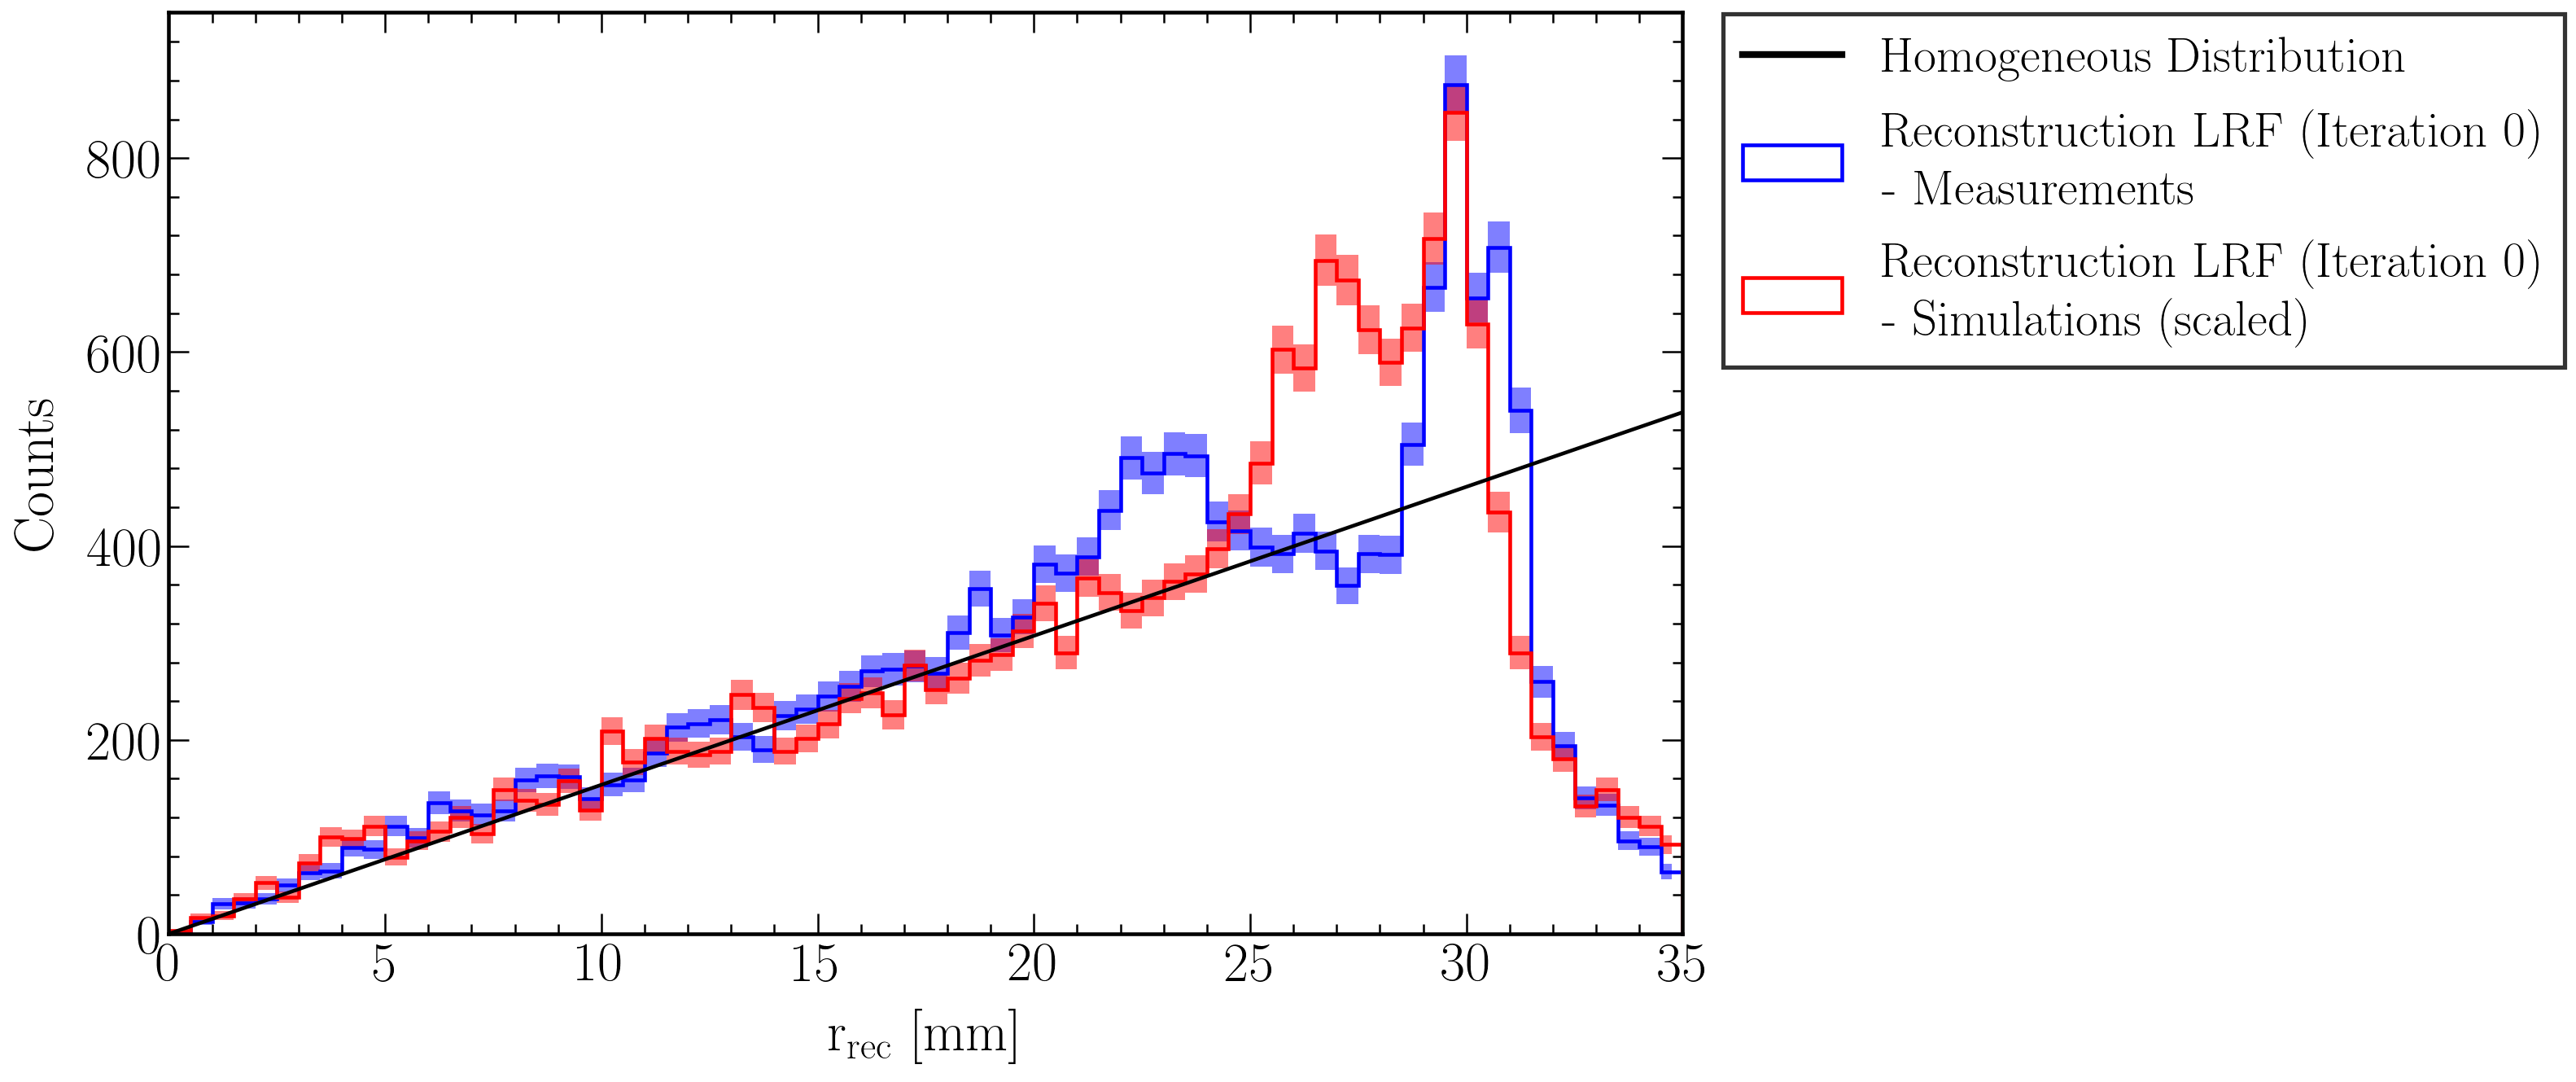

In [25]:
for i in range(0,6):

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot
    bns = 70
    
    i = 0
    cnts = eval('x_pos_LRF_iteration'+str(i)).shape[0]

    plt.plot([0, 35], [0, bns/35*cnts/bns], linewidth = 2.2, color = 'k', 
            label = 'Homogeneous Distribution')

    n, bins, *patches = plt.hist(np.hypot(eval('x_pos_LRF_iteration'+str(i)), eval('y_pos_LRF_iteration'+str(i))), bins = bns, 
             range = (0,35), density = False, histtype='step', linewidth = 2.2, 
             color = 'blue', label = 'Reconstruction LRF (Iteration '+str(i)+')\n- Measurements')
    bins_center = (bins[1:] + bins[:-1]) / 2
    plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='blue', 
                     alpha=0.5, step = 'mid')

    n, bins, *patches = plt.hist(np.hypot(eval('x_pos_LRF_iteration'+str(i)+'_sim'), 
                                          eval('y_pos_LRF_iteration'+str(i)+'_sim')), 
                                 bins = bns, range = (0,35), density = False,
                                 weights = [eval('x_pos_LRF_iteration'+str(i)).shape[0] / eval('x_pos_LRF_iteration'+str(i)+'_sim').shape[0]]*eval('x_pos_LRF_iteration'+str(i)+'_sim').shape[0],
                                 histtype='step', linewidth = 2.2, color = 'red', 
                                 label = 'Reconstruction LRF (Iteration '+str(i)+')\n- Simulations (scaled)')
    bins_center = (bins[1:] + bins[:-1]) / 2
    plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='red', 
                     alpha=0.5, step = 'mid')

    plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

    plt.xlim(0, 35)
    plt.ylim(bottom = 0)

    # Legend
    leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    #leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig(filenameprefix+"_predictions_LRF_iteration_"+str(i)+"_rspectrum_vs_simulations.png", bbox_inches = "tight")
    plt.show()